# Stellar mass estimation for the GLADE+ galaxies

This notebook contains the stellar mas estimation for the GLADE+ galaxies with two different methods, the comparison of them, some other analysis and the calculation of the merger rate of compact binaries based on the stellar mass.

The code was written by Mária Pálfi (marika97@caesar.elte.hu).

In [1]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn-white') # set figure style

# Reading the catalog

This catalog was created by the *create_working_catalog.ipynb*.

In [2]:
# reading the file to 'data' pandas dataframe
data = pd.read_csv( 'data_for_work.txt', delimiter = '\t', low_memory = False )
print( 'dataframe with the necessary columns:\n' )
data

dataframe with the necessary columns:



wiseX  w1mCorr  w1mCorrErr  fromAllSky     GWGC  \
0                         NaN      NaN         NaN         NaN  NGC4736   
1                         NaN      NaN         NaN         NaN  NGC4548   
2                         NaN      NaN         NaN         NaN  NGC6503   
3                         NaN      NaN         NaN         NaN  NGC4442   
4                         NaN      NaN         NaN         NaN  NGC4469   
...                       ...      ...         ...         ...      ...   
23181753  J235402.73+201302.6   14.902       0.034         0.0      NaN   
23181754  J235200.81+201806.7   14.153       0.029         0.0      NaN   
23181755  J235232.36+201806.2   14.678       0.033         0.0      NaN   
23181756  J235039.58+201425.6   14.686       0.032         0.0      NaN   
23181757  J235037.73+201957.3   15.094       0.037         0.0      NaN   

                              Hyp       designation type          ra  \
0                         NGC4736  12505314+4107125    G  192.721451   
1                         NGC4548  12352642+1429467    G  188.860123   
2                         NGC6503  17492651+7008396    G  267.360474   
3                         NGC4442  12280389+0948130    G  187.016220   
4                         NGC4469               NaN    G  187.367000   
...                           ...               ...  ...         ...   
23181753  SDSSJ235402.72+201302.6               NaN    G  358.511000   
23181754  SDSSJ235200.81+201806.7               NaN    G  358.003000   
23181755  SDSSJ235232.35+201806.5               NaN    G  358.135000   
23181756  SDSSJ235039.56+201426.0               NaN    G  357.665000   
23181757  SDSSJ235037.73+201957.3               NaN    G  357.657000   

                dec   Kmag      W1      W2         z       lumdis  lumdis_err  \
0         41.120152  5.169     NaN     NaN  0.000991     4.392418         NaN   
1         14.496320  7.368     NaN     NaN  0.004120    11.201905         NaN   
2         70.144341  7.382     NaN     NaN  0.001000     9.020106         NaN   
3          9.803620  7.381     NaN     NaN  0.003557     9.499651         NaN   
4          8.749890    NaN     NaN     NaN  0.004139    10.817553         NaN   
...             ...    ...     ...     ...       ...          ...         ...   
23181753  20.217400    NaN  14.902  14.744  0.308475  1654.841013         NaN   
23181754  20.301880    NaN  14.153  13.819  0.200333  1014.188600         NaN   
23181755  20.301830    NaN  14.678  14.284  0.201158  1018.845712         NaN   
23181756  20.240560    NaN  14.686  14.440  0.356846  1959.611688         NaN   
23181757  20.332600    NaN  15.094  14.811  0.397962  2226.809938         NaN   

          k_m_ext  k_msig_ext  
0           5.106       0.016  
1           7.115       0.031  
2           7.296       0.021  
3           7.294       0.024  
4             NaN         NaN  
...           ...         ...  
23181753      NaN         NaN  
23181754      NaN         NaN  
23181755      NaN         NaN  
23181756      NaN         NaN  
23181757      NaN         NaN  

[23181758 rows x 18 columns]

## Filtration

In [3]:
# We need only the galaxies, therefore we filtrate the
# globular clusters ('C') and the quasars ('Q'):
data_new = copy.deepcopy( data[ data.type != 'C' ] )
print('Length without globular clusters:', data_new.shape[0])
data_new = data_new[ data_new.type != 'Q' ]
print('Length with galaxies only:', data_new.shape[0])
#data_new = data_new[ ~np.isnan(data_new.z) ]
#print( 'Length with known redshift:', data_new.shape[0])
# We need the luminosity distance data which are larger than 0:
#print( data_new.type.unique() )
data_new = data_new[ ~np.isnan(data_new.lumdis) ] # we have to have luminosity distance
print( 'Length with known luminosty distance:', data_new.shape[0])

# Then we filtrate out the nan Kmag values, because it is essential 
# to the Cappellari's method (see below), but we save into a 
# new dataframe:
data_new2 = data_new[ ~np.isnan(data_new.Kmag) ]
print('Length with Kmag:', data_new2.shape[0])

# We need the WISE magnitude (from the original dataframe):
data_new = data_new[ ~np.isnan(data_new.W1) ]
print('Length with W1:', data_new.shape[0])
data_new = data_new[ ~np.isnan(data_new.W2) ]
print('Length with W2:',data_new.shape[0])
# Cluver's method is valid for galaxies having redshift z < 0.15: 
#data_new = data_new[ data_new.z < 0.15 ]
#print('Length for galaxies with z < 0.15:', data_new.shape[0])

# Let's see how many galaxies have both WISE and Ks magnitudes:
data_new3 = copy.deepcopy( data_new[ ~np.isnan(data_new.Kmag) ] )
print('Length with both magnitudes:', data_new3.shape[0])

# Kettlety et al. also filtrated the z < 0.003 galaxies,
# because they may be stellar contamintaion.
print( 'Number of galaxies with z < 0.003:', len( data_new[data_new.z < 0.003 ] ))

Length without globular clusters: 23181758
Length with galaxies only: 22431348
Length with known luminosty distance: 21884661
Length with Kmag: 992784
Length with W1: 20410484
Length with W2: 20410484
Length with both magnitudes: 188609
Number of galaxies with z < 0.003: 2335


## Estimaing the stellar mass via Kettlety's method
Kettlety et al. 2018. (MNRAS 473, 776–783 (2018), doi:10.1093/mnras/stx2379)

for passive galaxies

$$M_*/L_{W1} = 0.65 \pm 0.07$$

$$M_* = 0.65 \cdot L_{W1}$$

This is best for z $\leq$ 0.15.

$$L_{W1} (L_{Sun}) = 10^{−0.4(M −M_{Sun} )},$$  

$$M_{Sun} = 3.24$$ 

$M$ is the absolute magnitude measured in the W1 filter, $W1-W2$ is rest-frame color.


(It was first published in Norris et al. (2014) (Norris M. A., Meidt S., van de Ven G., Schinnerer E, Groves B., Querejeta M., 2014, ApJ, 797, 55).)

The stellar mass can be calculated from the WISE W1 magnitude (m) as:
$$M_* = 0.65 \cdot 10^{-0.4[m+5-5\lg d + 7.1\lg(1+z)-3.24]}$$

I calculate the absolute magnitude:

$$m-M = -5+5 \lg d,$$ 

$$M = m+5-5 \lg d,$$

where $m$ is the apparent magnitude, $d$ is the distance (luminosity distance).

### K correction

With the K correction of the absolute magnitude we can take into account the shifting of the band because of the expansion of the Universe. This means that we measure the light emitted in an 'x' band in other 'y' band. 

According to Hogg et al. 2002. (https://arxiv.org/abs/astro-ph/0210394):

$$m_R = M_Q + DM + K_{QR},$$

where $m_R$ is the apparent magnitude measured in the band $R$, $M_Q$ is the absolute magnitude emitted in band $Q$, $K_{QR}$ is the K correction and DM is the distance modulus:

$$DM = 5 \cdot \lg \frac{D_L}{10 ~pc},$$

where $D_L$ is the luminosity distance.

In Kettlety et al. 2018.:

$$K_ {W1} = - 7.1 \lg( 1 + z )$$


### The uncertainty:
$$\Delta M_*(a,m,d,z) = M_* \cdot \sqrt{ \left(\frac{\Delta a}{a} \right)^2 + |0.4 \cdot \ln(10)|^2 \cdot \Delta m^2+4\cdot \left( \frac{\Delta d}{d}\right)^2 + (0.4\cdot 0.71)^2 \cdot \left( \frac{\Delta z}{|1+z|}\right)^2},$$
where $\Delta a = 0.07$.

In [4]:
# absolute magnitude in the W1 band without K correction:
M1_wKc = data_new.W1 + 5 - 5 * np.log10( data_new.lumdis*1e6 )
print( 'absolute magnitude in the W1 band without K correction:' )
print( M1_wKc[:5] )

# K correction for W1 magnitudes according to Kettlety:
M1_Kettlety = M1_wKc + 7.1 * np.log10(1+data_new.z) 
print( '\nK corrected absolute W1 magnitudes according to Kettlety:' )
print( M1_Kettlety[:5] )

# W1 band luminosity:
M_sun = 3.24
print( '\n$L_{W1}$ luminosity:' )
L_W1_Kettlety = 10**( -0.4 * ( M1_Kettlety - M_sun ) )
print( L_W1_Kettlety[:5] )

# stellar mass:
print( '\nThe stellar mass:' )
M_Kettlety = 0.65*L_W1_Kettlety
M_Kettlety[:5]

absolute magnitude in the W1 band without K correction:
2765732   -24.277610
2765733   -23.841373
2765734   -25.746217
2765735   -26.053218
2765736   -25.561244
dtype: float64

K corrected absolute W1 magnitudes according to Kettlety:
2765732   -23.958807
2765733   -23.613478
2765734   -25.208070
2765735   -25.507247
2765736   -25.104899
dtype: float64

$L_{W1}$ luminosity:
2765732    7.577446e+10
2765733    5.513039e+10
2765734    2.394572e+11
2765735    3.154270e+11
2765736    2.177508e+11
dtype: float64

The stellar mass:


2765732    4.925340e+10
2765733    3.583475e+10
2765734    1.556472e+11
2765735    2.050275e+11
2765736    1.415380e+11
dtype: float64

In [5]:
# filtrating the small stellar masses:
data_new = data_new[ M_Kettlety > 1e5 ]
M_Kettlety = M_Kettlety[ M_Kettlety > 1e5]

#### Error estimation

If there is no W1 mag error, I use the mean $\Delta m$.

In [6]:
len( data_new[np.isnan(data_new.w1mCorrErr)] )

9522

In [7]:
np.mean(data_new.w1mCorrErr)

0.04361963485413286

In [8]:
data_new.w1mCorrErr = data_new.w1mCorrErr.fillna(0.04)

Where do the luminosity distances come from?

In [9]:
GWGC_idx = np.argwhere( data_new.GWGC.values.astype(str) != 'nan' ).flatten()
Hyp_idx = np.argwhere( data_new.Hyp.values.astype(str) != 'nan' ).flatten()
twoMASS_idx = np.argwhere( data_new.designation.values.astype(str) != 'nan' ).flatten()

cat_flag_W = 4*np.ones( len(data_new), dtype = np.int8 )
cat_flag_W[twoMASS_idx] = 3
cat_flag_W[Hyp_idx] = 2
cat_flag_W[GWGC_idx] = 1

data_new['cat_flag'] = cat_flag_W
data_new.head()

wiseX  w1mCorr  w1mCorrErr  fromAllSky GWGC      Hyp  \
2765732  J000056.39-020523.3   14.308       0.056         0.0  NaN  1102028   
2765733  J235917.43-014213.2   13.936       0.027         0.0  NaN  1112296   
2765734  J000014.50-013858.7   14.165       0.027         0.0  NaN  1113689   
2765735  J235816.01-013739.3   13.896       0.027         0.0  NaN      NaN   
2765736  J235755.05-014005.8   13.922       0.027         0.0  NaN  1113236   

              designation type          ra       dec    Kmag      W1      W2  \
2765732  00005632-0205221    G    0.234695 -2.089495  13.827  14.308  14.035   
2765733  23591740-0142134    G  359.822540 -1.703735  13.889  13.936  13.822   
2765734               NaN    G    0.060450 -1.649560     NaN  14.165  13.836   
2765735  23581606-0137396    G  359.566925 -1.627676  13.638  13.896  13.485   
2765736  23575503-0140058    G  359.479309 -1.668278  14.267  13.922  13.722   

                z      lumdis  lumdis_err  k_m_ext  k_msig_ext  cat_flag  
2765732  0.108924  521.341075         NaN   13.633       0.172         2  
2765733  0.076708  359.314386         NaN   13.724       0.191         2  
2765734  0.190681  959.938689         NaN      NaN         NaN         2  
2765735  0.193706  976.885557         NaN   13.293       0.203         3  
2765736  0.159509  788.222607         NaN   13.887       0.235         2

Number of galaxies in the different catalogs.

In [10]:
(cat_flag_W == 1).sum(), (cat_flag_W == 2).sum(), (cat_flag_W == 3).sum(), (cat_flag_W == 4).sum()

(11073, 897393, 44018, 19457811)

Relative luminosity distance errors in the different catalogs:

In [11]:
rel_lumdis_err = np.zeros( len(data_new) )

rel_lumdis_err[cat_flag_W == 1] = 0.2
rel_lumdis_err[cat_flag_W == 2] = 0.36
rel_lumdis_err[cat_flag_W == 3] = 0.15
rel_lumdis_err[cat_flag_W == 4] = 0.011

data_new['rel_lumdis_err'] = rel_lumdis_err

Relative redshift errors in the different catalogs:

In [12]:
rel_z_err = np.zeros( len(data_new) )

rel_z_err[cat_flag_W == 1] = 0.19
rel_z_err[cat_flag_W == 2] = 0.36
rel_z_err[cat_flag_W == 3] = 0.15
rel_z_err[cat_flag_W == 4] = 0.033

data_new['rel_z_err'] = rel_z_err

The terms in the error propagation:

In [13]:
sigma_a = (0.07/0.65)**2
sigma_m = (0.4 * np.log(10) * data_new.w1mCorrErr)**2
sigma_d = 4*data_new.rel_lumdis_err**2
sigma_z = (0.4*0.71*1/np.abs(1+data_new.z)*data_new.rel_z_err*data_new.z)**2

Calculating the errors:

In [14]:
rel_err_M_Kettlety = np.sqrt(sigma_a+sigma_m+sigma_d+sigma_z)
err_M_Kettlety = M_Kettlety*rel_err_M_Kettlety

Checking the calculations:

In [15]:
(np.abs(err_M_Kettlety/M_Kettlety - rel_err_M_Kettlety) > 1e-13).sum()

0

Function for plotting:

In [16]:
def hist_form( ytext = '$\lg M_{*}$ [$M_\odot$]', logscale = True ):
    fig = plt.figure( figsize = (18, 12), dpi = 100 )
    plt.xlabel( ytext, fontsize = 47 )
    plt.ylabel( 'Frequency', fontsize = 47 )
    if logscale == True:
        plt.yscale('log')
        plt.ylim([1e-1, 1e5])
    plt.xticks( fontsize = 43 )
    plt.yticks( fontsize = 43 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )

### Histogram of relative uncertainty

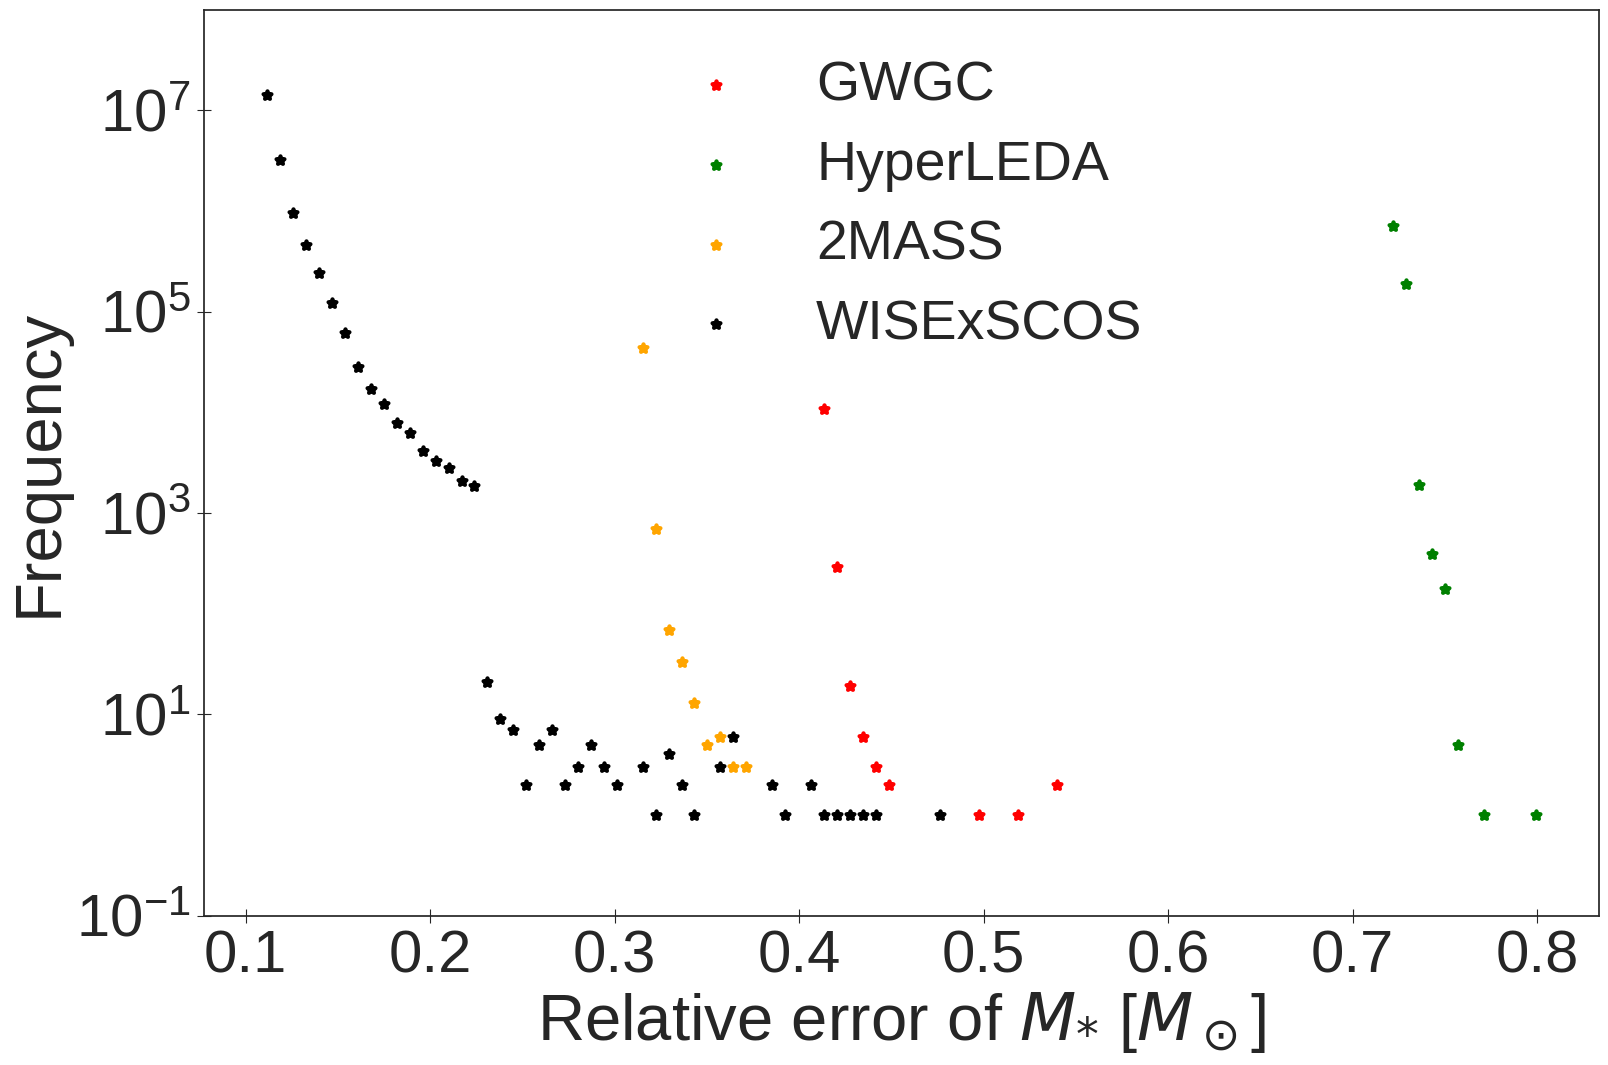

In [17]:
spec_bins = np.linspace(np.min(rel_err_M_Kettlety), np.max(rel_err_M_Kettlety), 100 )
hist_form()
plt.xlabel( 'Relative error of $M_{*}$ [$M_\odot$]' )
plt.ylim( [1e-1, 1e8] )

freq, bins = np.histogram( rel_err_M_Kettlety[cat_flag_W == 1],  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red',
            label = 'GWGC' )

freq, bins = np.histogram( rel_err_M_Kettlety[cat_flag_W == 2],  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'green',
            label = 'HyperLEDA' )

freq, bins = np.histogram( rel_err_M_Kettlety[cat_flag_W == 3],  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'orange',
            label = '2MASS' )

freq, bins = np.histogram( rel_err_M_Kettlety[cat_flag_W == 4],  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'black',
            label = 'WISExSCOS' )

plt.legend( fontsize = 40 ) # set legend

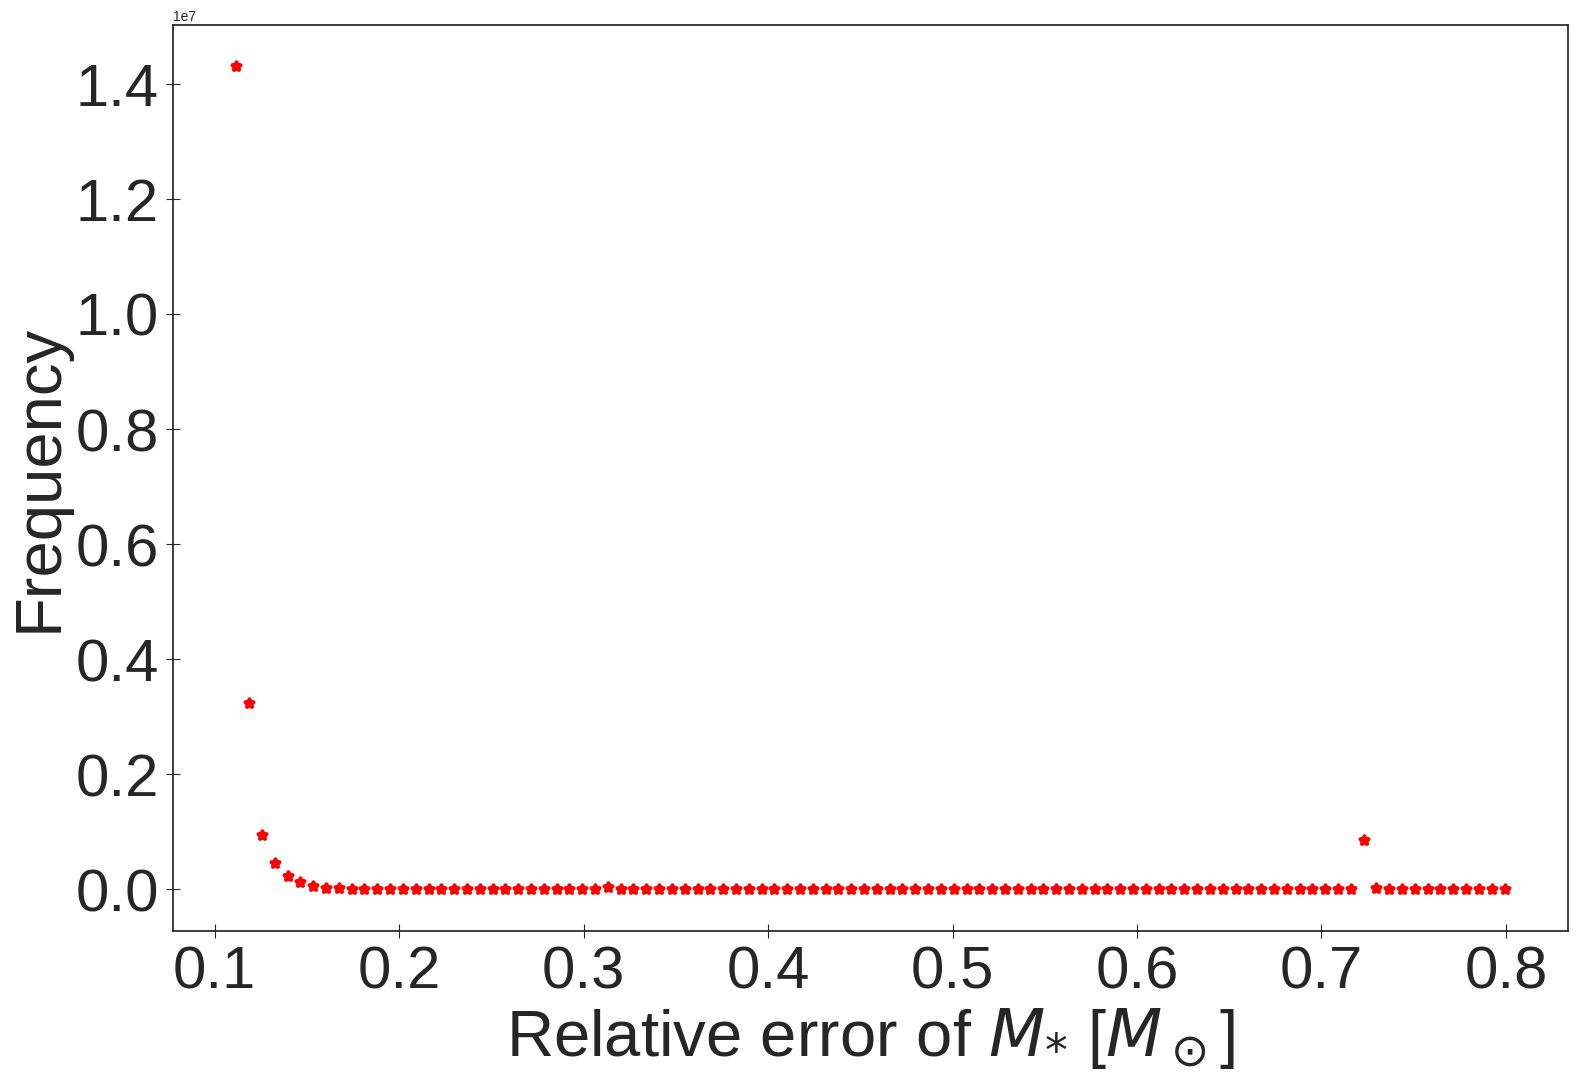

In [18]:
hist_form()
plt.xlabel( 'Relative error of $M_{*}$ [$M_\odot$]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( rel_err_M_Kettlety,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

### Histogram of the contribution of the terms ($\sigma$-s)

$\mathbf{\sigma_a}$

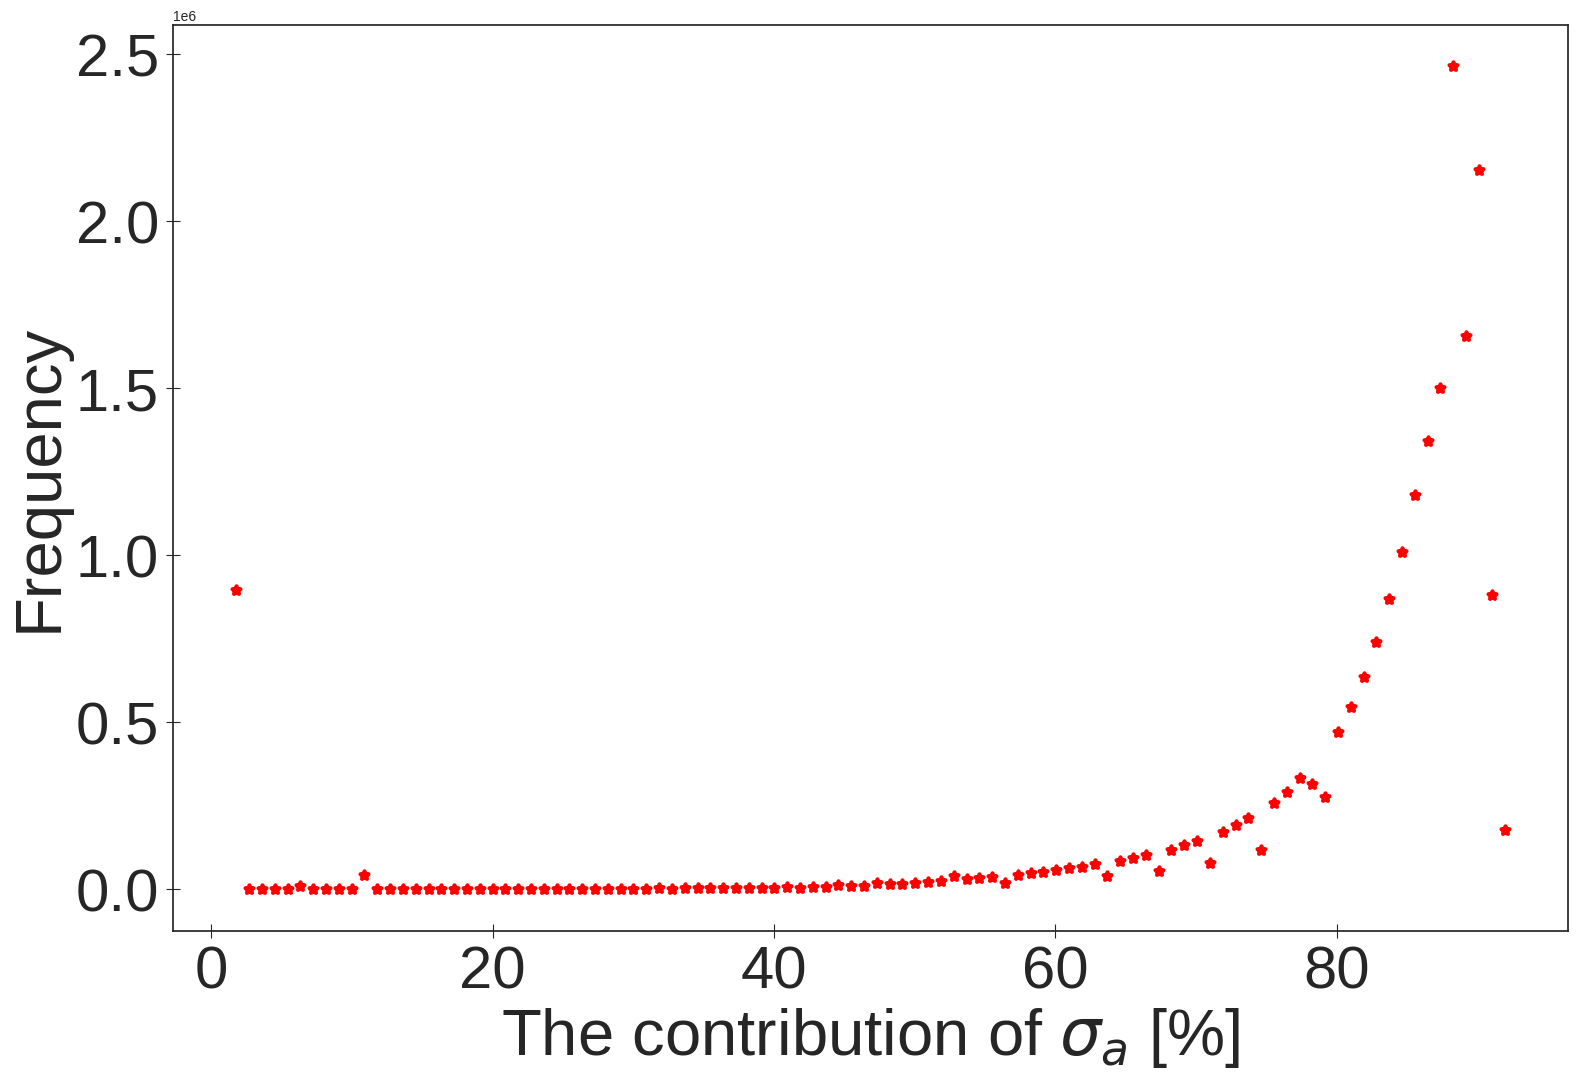

In [19]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_a$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_a/rel_err_M_Kettlety**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [20]:
np.mean( 100*sigma_a/rel_err_M_Kettlety**2 )

80.17561418655194

$\mathbf{\sigma_m}$

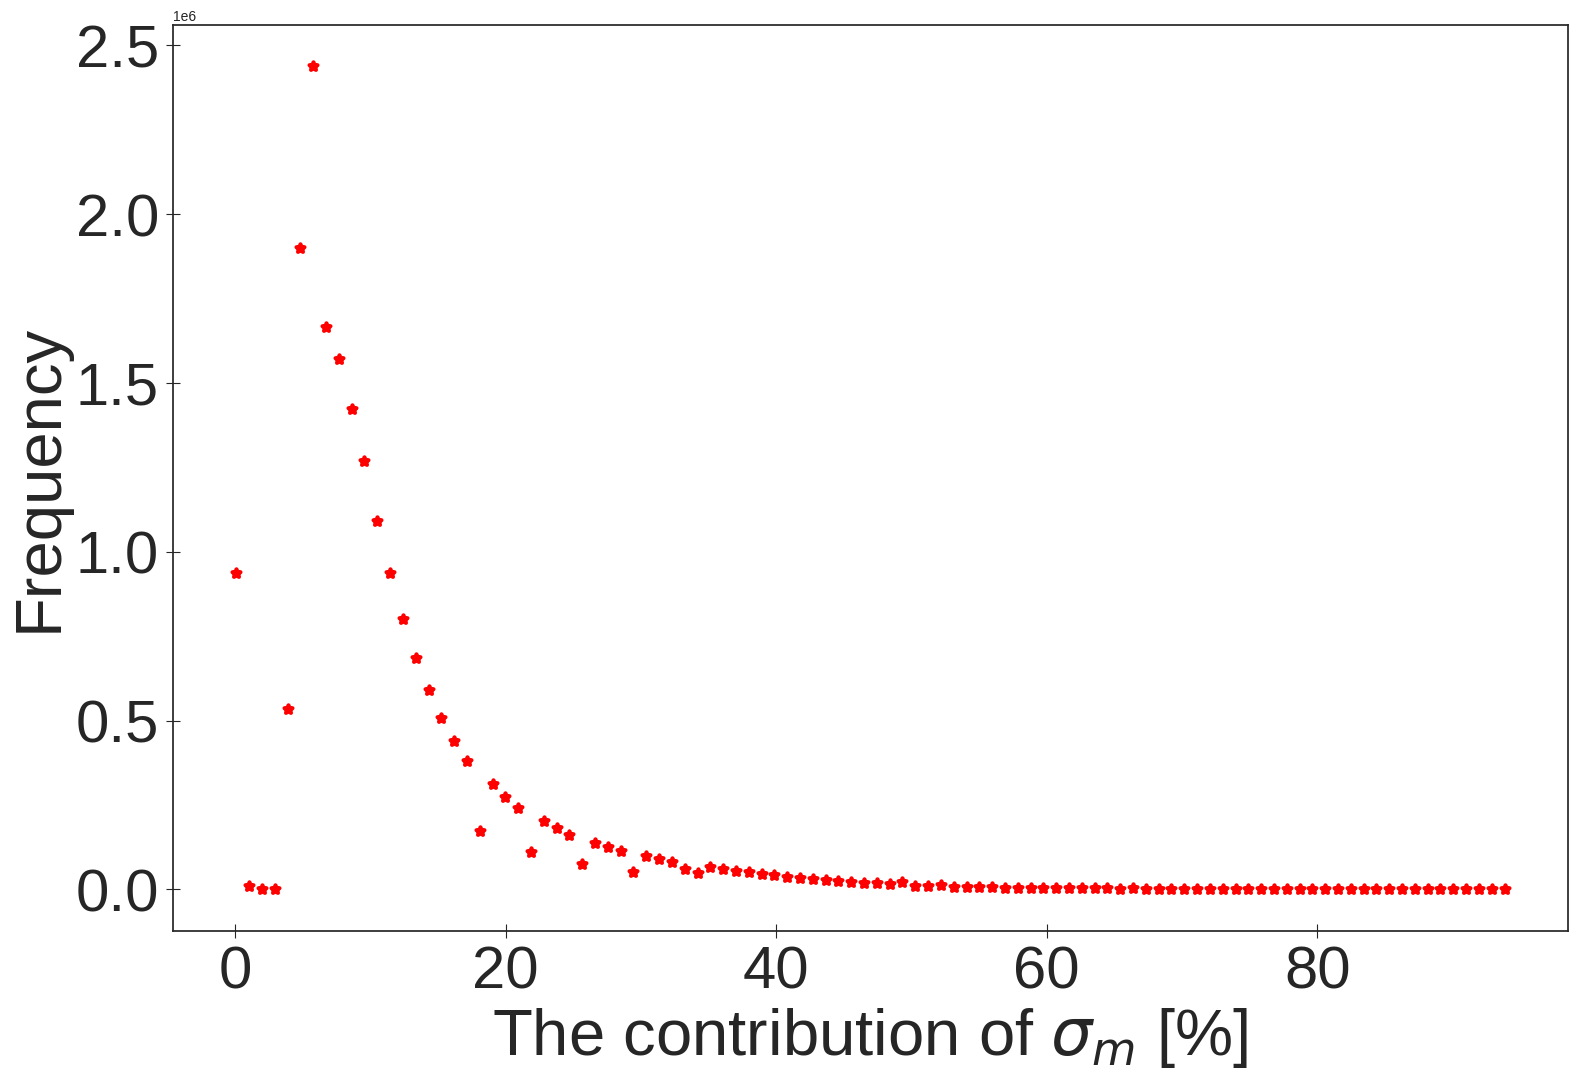

In [21]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_m$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_m/rel_err_M_Kettlety**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [22]:
np.mean( 100*sigma_m/rel_err_M_Kettlety**2 )

11.93352896931953

$\mathbf{\sigma_d}$

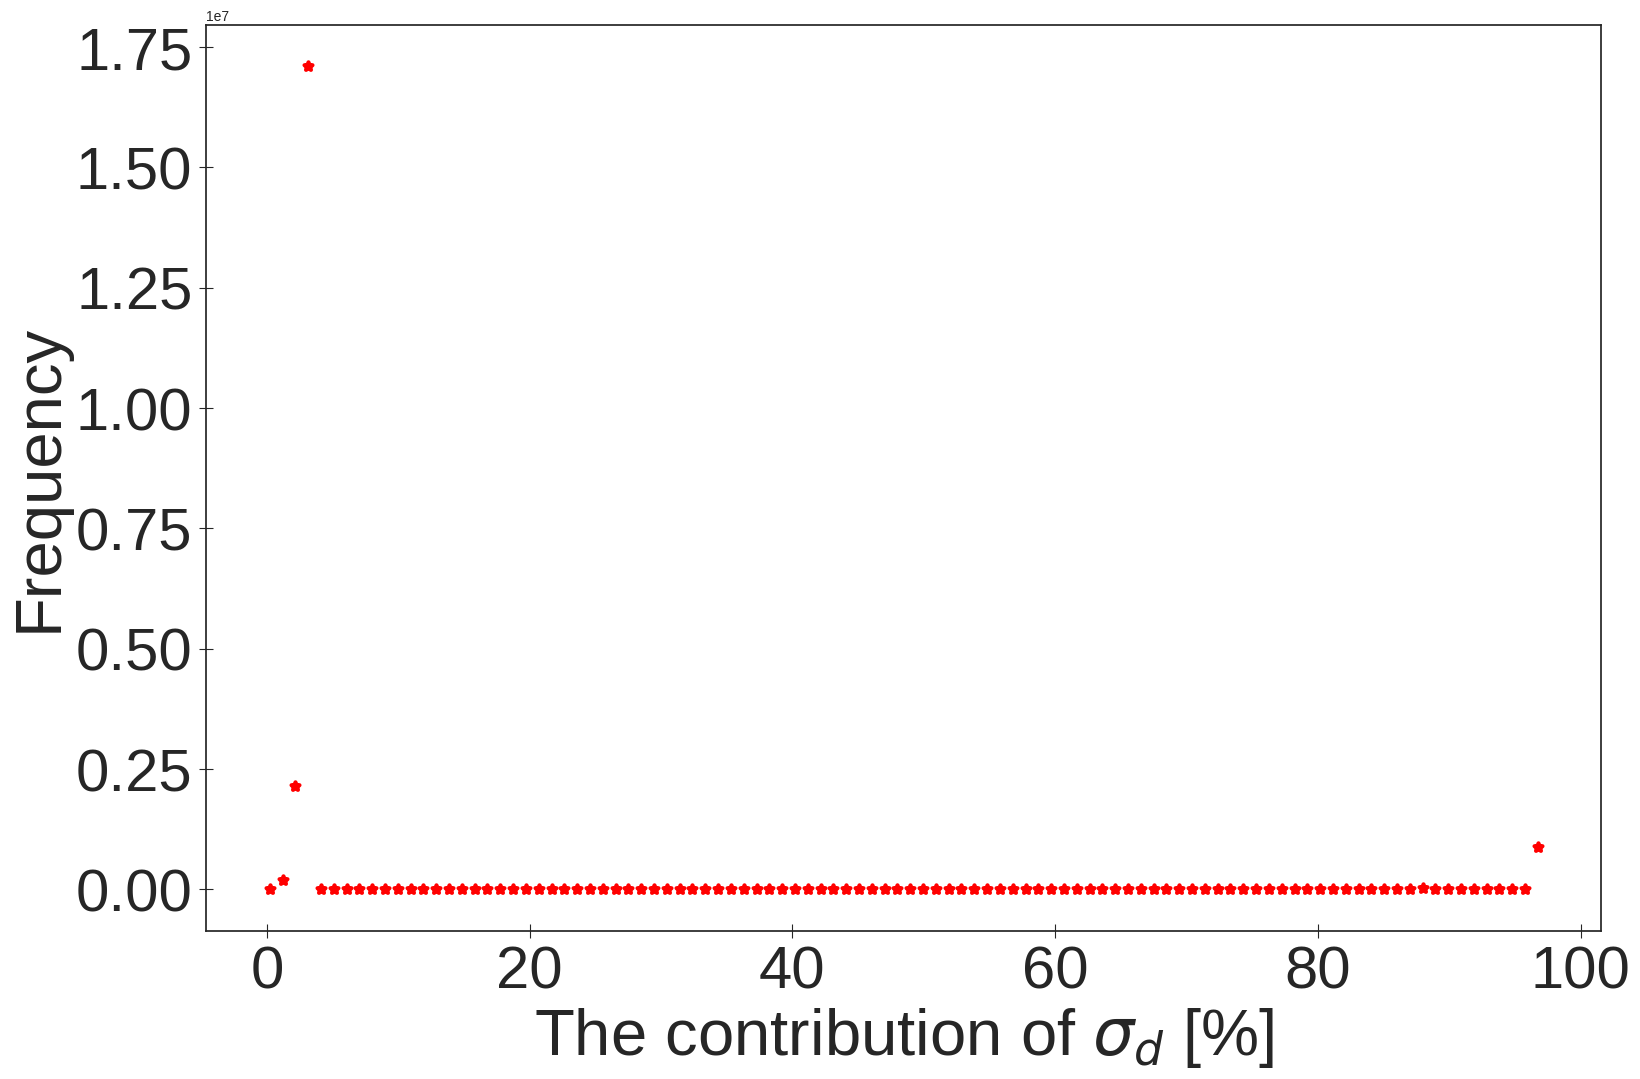

In [23]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_d$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_d/rel_err_M_Kettlety**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [24]:
np.mean( 100*sigma_d/rel_err_M_Kettlety**2 )

7.87068259624057

$\mathbf{\sigma_z}$

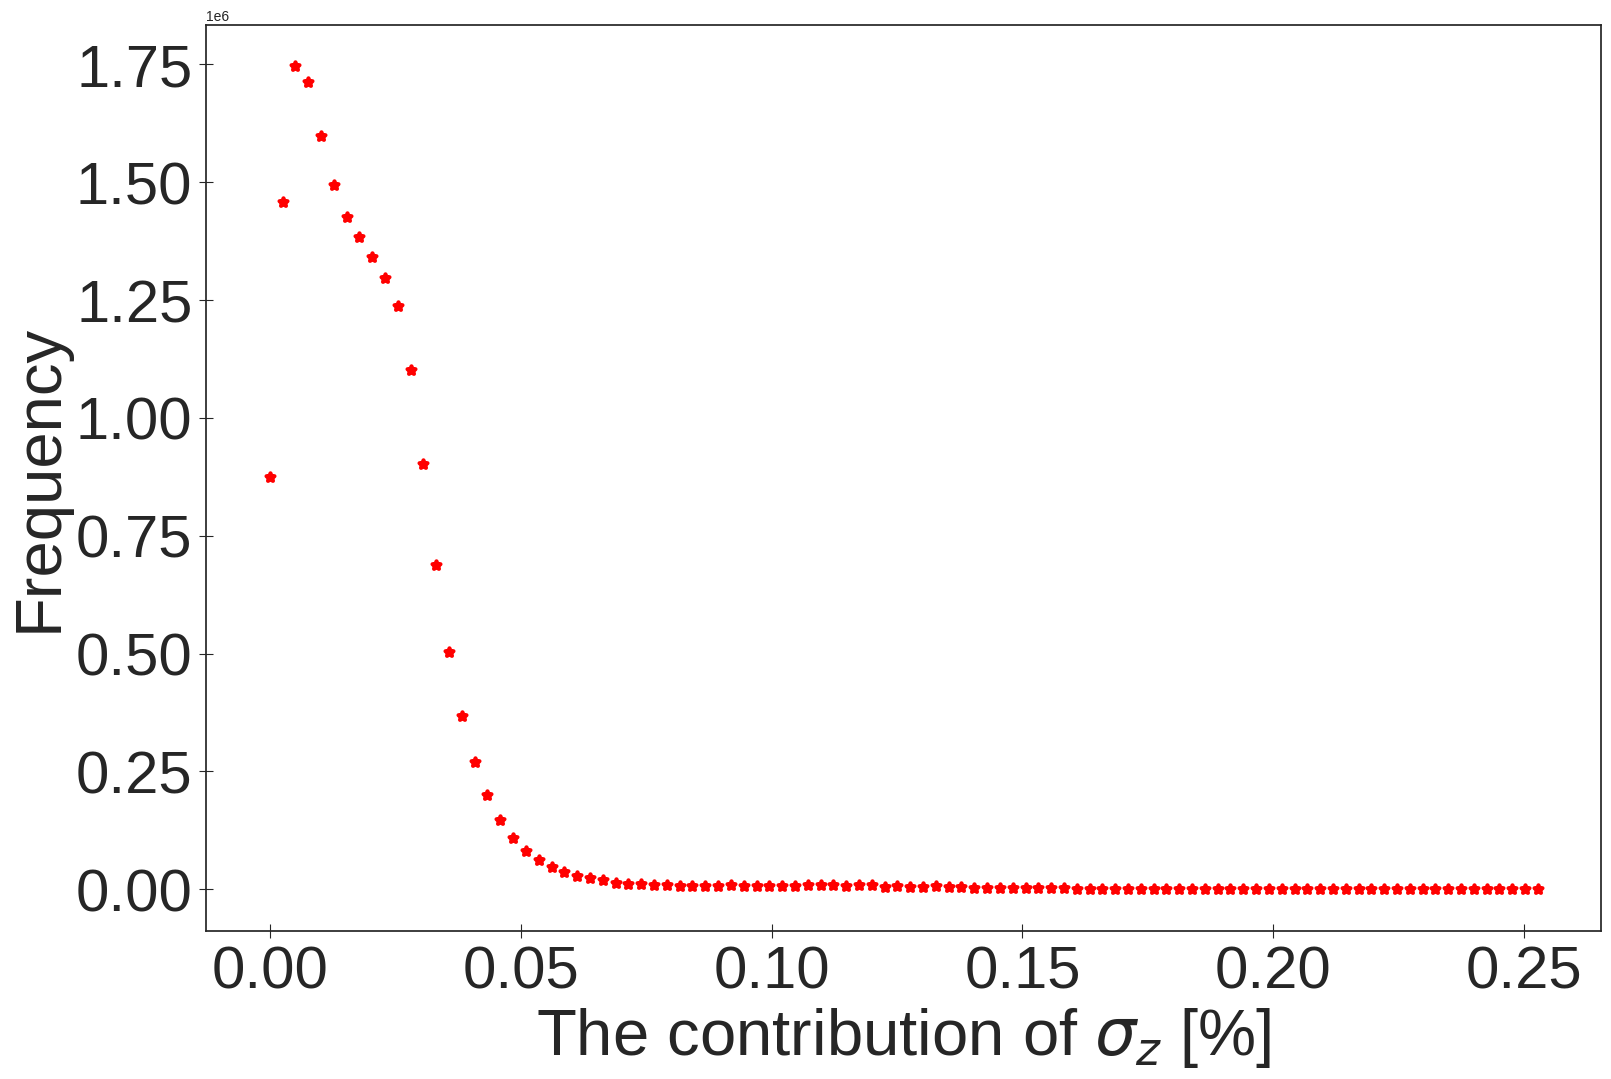

In [25]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_z$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_z/rel_err_M_Kettlety**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [26]:
np.mean( 100*sigma_z/rel_err_M_Kettlety**2 )

0.020174247894943625

The sum of the percental contribution (sould be close to 100):

In [27]:
80.2+11.9+7.9

100.00000000000001

Checking the calculation:

In [28]:
(np.abs( (sigma_a + sigma_m + sigma_d+ sigma_z)/rel_err_M_Kettlety**2 - 1 ) > 1e-13 ).sum()

0

**The mean of the error in the whoe sample and in the different catalogs:**

In [29]:
print( np.mean( rel_err_M_Kettlety ),
      np.mean( rel_err_M_Kettlety[ cat_flag_W == 1] ), np.mean( rel_err_M_Kettlety[ cat_flag_W == 2] ),
      np.mean( rel_err_M_Kettlety[ cat_flag_W == 3] ), np.mean( rel_err_M_Kettlety[ cat_flag_W == 4] ) )

0.14556732185115961 0.416075979494408 0.7288873298669664 0.3200052325689529 0.11811608171556218


How many galaxies have stellar mass from this method?

In [30]:
len(M_Kettlety)

20410295

Mean and median error:

In [31]:
np.mean(rel_err_M_Kettlety), np.median(rel_err_M_Kettlety)

(0.14556732185115961, 0.11592840534553243)

## Cappellari's method:

Cappellari 2013. ( ApJL 778 L2, 2013, doi:10.1088/2041-8205/778/1/L2)

$$\lg M_∗ ≈ 10.58 − 0.44 (M_{K_s} + 23),$$

where $M_{K_s}$ is the absolute magnitude, but we have the apparent magnitude ($m$), so:

$$M_{K_s} = m+5-5 \lg d.$$

$$ M_* = 10^{10.583-0.445(M_{K_s}+23)}$$

$$\Delta f(a, b, m, c) =  f \cdot \ln(10) \cdot \sqrt{\Delta a^2 + \Big|-(M_{K_s}+23)\Big|^2 \Delta b^2+ |-b|^2 \Delta m^2 +\Big|- \frac{5\cdot b}{\ln(10) \cdot d}\Big|^2 \Delta d^2},$$

I did not found the error of extinction correction.

### Query extinctions from the dustmap of Schlegel, Finkbeiner & Davis (1998)

In [32]:
%%time
from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

# filter out galaxies which does not have a counterpart in the 2MASS
filt = data_new2.designation.notnull() == True
glade_2MASS = data_new2[filt]

ra = glade_2MASS['ra']
dec = glade_2MASS['dec']

coords = SkyCoord(ra, dec, unit='deg', frame='icrs')

sfd = SFDQuery()
ebv = sfd(coords)

CPU times: user 26.1 s, sys: 438 ms, total: 26.5 s
Wall time: 27.2 s


In order to convert SFD values of E(B-V) to extinction, one should use the conversions provided in Table 6 of Schlafly
& Finkbeiner (2011).

According to Chung-Pei Ma, Jenny E. Greene, Nicholas McConnell, Ryan Janish, John P. Blakeslee, Jens Tho-
mas, and Jeremy D. Murphy. THE MASSIVE SURVEY. i. a VOLUME-LIMITED INTEGRAL-
FIELD SPECTROSCOPIC STUDY OF THE MOST MASSIVE EARLY-TYPE GALAXIES
WITHIN 108 mpc. The Astrophysical Journal, 795(2):158, oct 2014.:

"We compute the absolute K-band magnitudes using
$$M_K = K − 5 \lg D − 25 − 0.11 A_V,$$
where $K$ is given by k_m_ext, and $D$ is the distance in Mpc described in Sec 2.2. We use galactic extinction $A_V$ (Landolt V) from Schlafly & Finkbeiner (2011) and the reddening relation of Fitzpatrick (1999) with $R_V = A_V/E_{B−V} = 3.1$. The values of $K$, $A_V$, and $M_K$ for all galaxies are listed in Table 3. These K−band magnitudes
form the basis for our selection and are used to estimate stellar masses (§ 3.1)."

In Table 6 of Schlafly & Finkbeiner (2011) there is 2.742 in the row of Landolt V and in the column where $R_V$ is 3.1. So I will calculate the extinction as 
$$A_V = 2.742 \cdot E_{B-V},$$
here $E_{B-V}$ is ebv.

In [33]:
ext = 2.742 * ebv 
glade_2MASS['ext'] = ext

### Calculating the absolute magnitude and the stellar mass

In [34]:
print( 'Absolute K_s magnitudes with extinction:' )
abs_m_Ks_E = glade_2MASS.k_m_ext - 5*np.log10(glade_2MASS.lumdis) - 25 - 0.11 * ext 
print( abs_m_Ks_E[:5] )

print( '\nFiltration:  M_K_s < -21.5 mag')
glade_2MASS = glade_2MASS[abs_m_Ks_E < -21.5]
abs_m_Ks_E = abs_m_Ks_E[abs_m_Ks_E < -21.5]
print( abs_m_Ks_E[:5] )

print( '\nStellar masses from K_s magnitudes:')
M_Cappellari= 10**( 10.58 - 0.44 * (abs_m_Ks_E + 23) )
print( M_Cappellari[:5] )

Absolute K_s magnitudes with extinction:
0   -23.112881
1   -23.142946
2   -22.489689
3   -22.601173
5   -21.332579
dtype: float64

Filtration:  M_K_s < -21.5 mag
0     -23.112881
1     -23.142946
2     -22.489689
3     -22.601173
185   -24.008104
dtype: float64

Stellar masses from K_s magnitudes:
0      4.262534e+10
1      4.394366e+10
2      2.267061e+10
3      2.538143e+10
185    1.055761e+11
dtype: float64


#### Error estimation

Where there are no $\Delta m$, I use the mean $\Delta m$.

In [35]:
len( glade_2MASS[np.isnan(glade_2MASS.k_msig_ext)] )

41

In [36]:
np.min(glade_2MASS.k_msig_ext), np.max(glade_2MASS.k_msig_ext), np.mean(glade_2MASS.k_msig_ext)

(0.001, 0.994, 0.15470547983673127)

In [37]:
glade_2MASS.k_msig_ext = glade_2MASS.k_msig_ext.fillna(0.15)

Where do the luminosity distances come from?

In [38]:
GWGC_idx = np.argwhere( glade_2MASS.GWGC.values.astype(str) != 'nan' ).flatten()
Hyp_idx = np.argwhere( glade_2MASS.Hyp.values.astype(str) != 'nan' ).flatten()
twoMASS_idx = np.argwhere( glade_2MASS.designation.values.astype(str) != 'nan' ).flatten()

cat_flag_K = np.zeros( len(glade_2MASS), dtype = np.int8 )
cat_flag_K[twoMASS_idx] = 3
cat_flag_K[Hyp_idx] = 2
cat_flag_K[GWGC_idx] = 1

glade_2MASS['cat_flag'] = cat_flag_K
glade_2MASS.head()

wiseX  w1mCorr  w1mCorrErr  fromAllSky     GWGC      Hyp  \
0     NaN      NaN         NaN         NaN  NGC4736  NGC4736   
1     NaN      NaN         NaN         NaN  NGC4548  NGC4548   
2     NaN      NaN         NaN         NaN  NGC6503  NGC6503   
3     NaN      NaN         NaN         NaN  NGC4442  NGC4442   
185   NaN      NaN         NaN         NaN  NGC3034  NGC3034   

          designation type          ra        dec   Kmag  W1  W2         z  \
0    12505314+4107125    G  192.721451  41.120152  5.169 NaN NaN  0.000991   
1    12352642+1429467    G  188.860123  14.496320  7.368 NaN NaN  0.004120   
2    17492651+7008396    G  267.360474  70.144341  7.382 NaN NaN  0.001000   
3    12280389+0948130    G  187.016220   9.803620  7.381 NaN NaN  0.003557   
185  09555243+6940469    G  148.968460  69.679703  4.691 NaN NaN  0.000908   

        lumdis  lumdis_err  k_m_ext  k_msig_ext       ext  cat_flag  
0     4.392418         NaN    5.106       0.016  0.048756         1  
1    11.201905         NaN    7.115       0.031  0.104424         1  
2     9.020106         NaN    7.296       0.021  0.087555         1  
3     9.499651         NaN    7.294       0.024  0.060315         1  
185   5.311111         NaN    4.665       0.015  0.428884         1

In [39]:
(cat_flag_K == 1).sum(), (cat_flag_K == 2).sum(), (cat_flag_K == 3).sum(), (cat_flag_K == 4).sum()

(21767, 584775, 372780, 0)

Relative luminosity distance errors in the different catalogs:

In [40]:
rel_lumdis_err = np.zeros( len(glade_2MASS) )

rel_lumdis_err[cat_flag_K == 1] = 0.2
rel_lumdis_err[cat_flag_K == 2] = 0.36
rel_lumdis_err[cat_flag_K == 3] = 0.15
rel_lumdis_err[cat_flag_K == 4] = 0.011

glade_2MASS['rel_lumdis_err'] = rel_lumdis_err

The terms of error propagation:

In [41]:
sigma_a = (0.009)**2
sigma_b = (abs_m_Ks_E+23)**2*0.009**2
sigma_m = 0.445**2*glade_2MASS.k_msig_ext**2
sigma_d = (5*0.445/np.log(10))**2*glade_2MASS.rel_lumdis_err**2

Calculating the errors:

In [42]:
rel_err_M_Cappellari = np.sqrt(sigma_a+sigma_b+sigma_m+sigma_d)
err_M_Cappellari = M_Cappellari*rel_err_M_Cappellari*np.log(10)

Checking the calculations:

In [43]:
(np.abs(err_M_Cappellari/M_Cappellari - rel_err_M_Cappellari*np.log(10)) > 1e-13).sum()

0

### Histogram of the relative uncertainty

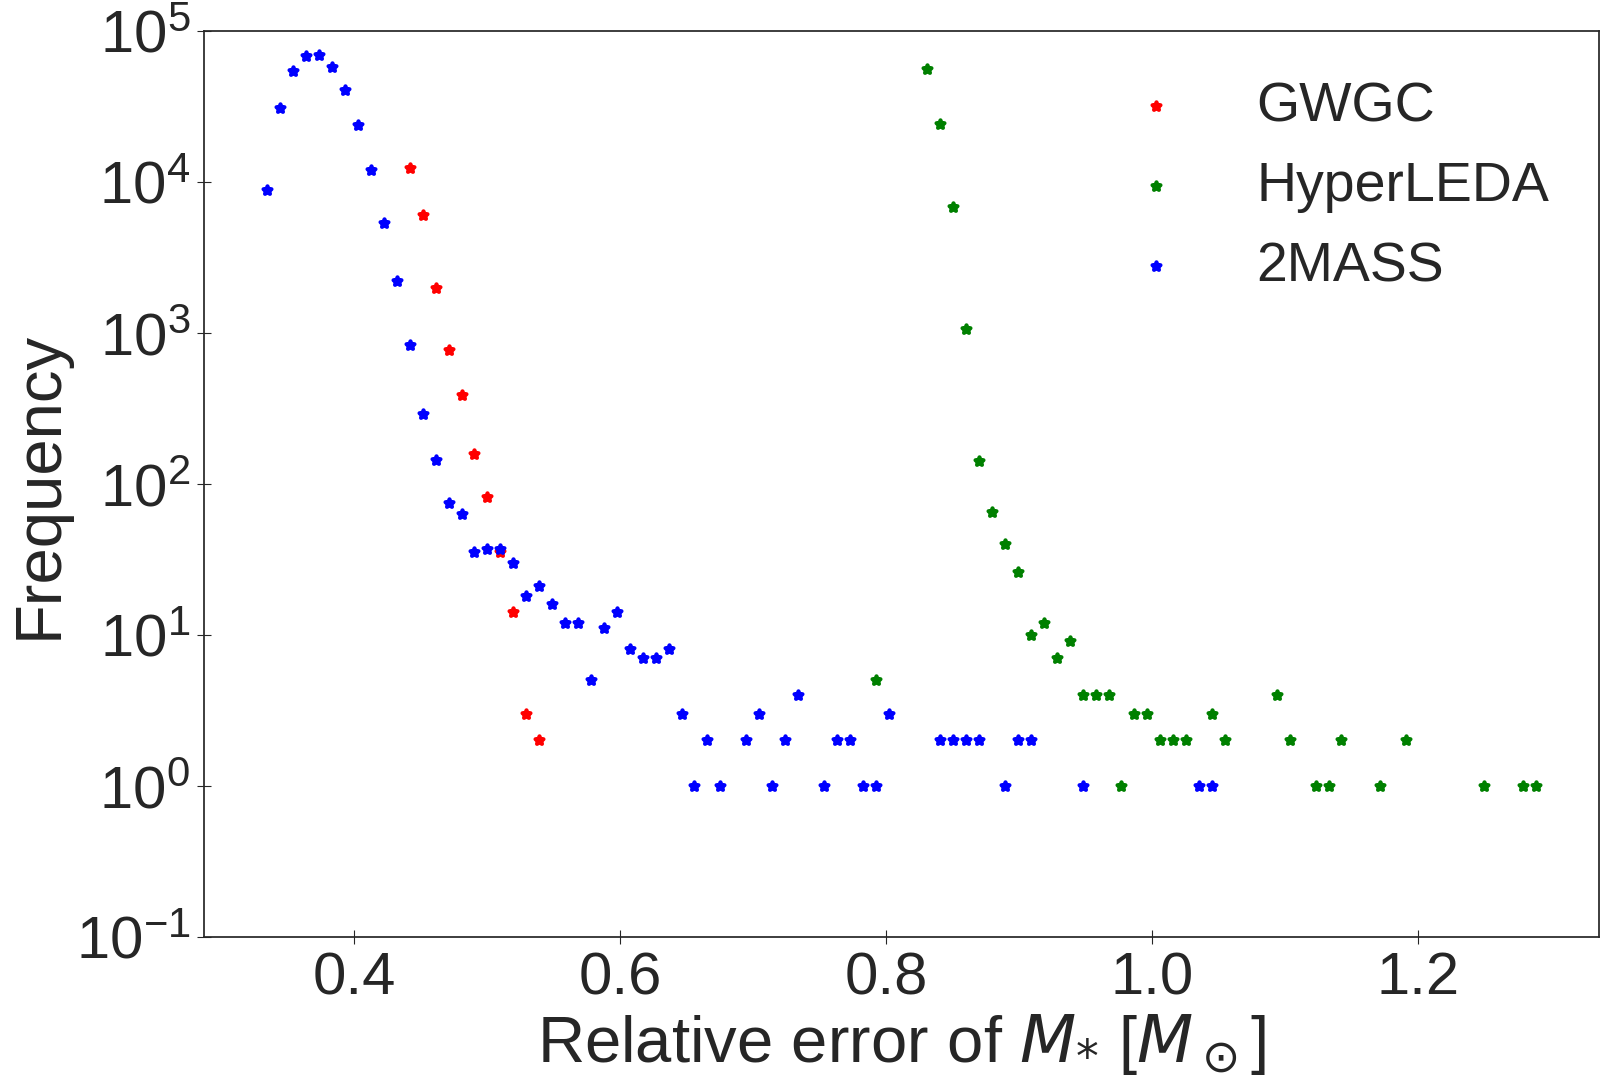

In [44]:
spec_bins = np.linspace(np.min(rel_err_M_Cappellari*np.log(10)),
                        np.max(rel_err_M_Cappellari*np.log(10)), 100 )
hist_form()
plt.xlabel( 'Relative error of $M_{*}$ [$M_\odot$]' )

freq, bins = np.histogram( rel_err_M_Cappellari[cat_flag_K == 1]*np.log(10),  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red',
            label = 'GWGC' )

freq, bins = np.histogram( rel_err_M_Cappellari[cat_flag_K == 2]*np.log(10),  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'green',
            label = 'HyperLEDA' )

freq, bins = np.histogram( rel_err_M_Cappellari[cat_flag_K == 3]*np.log(10),  bins=spec_bins )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'blue',
            label = '2MASS' )

plt.legend( fontsize = 40 ) # set legend

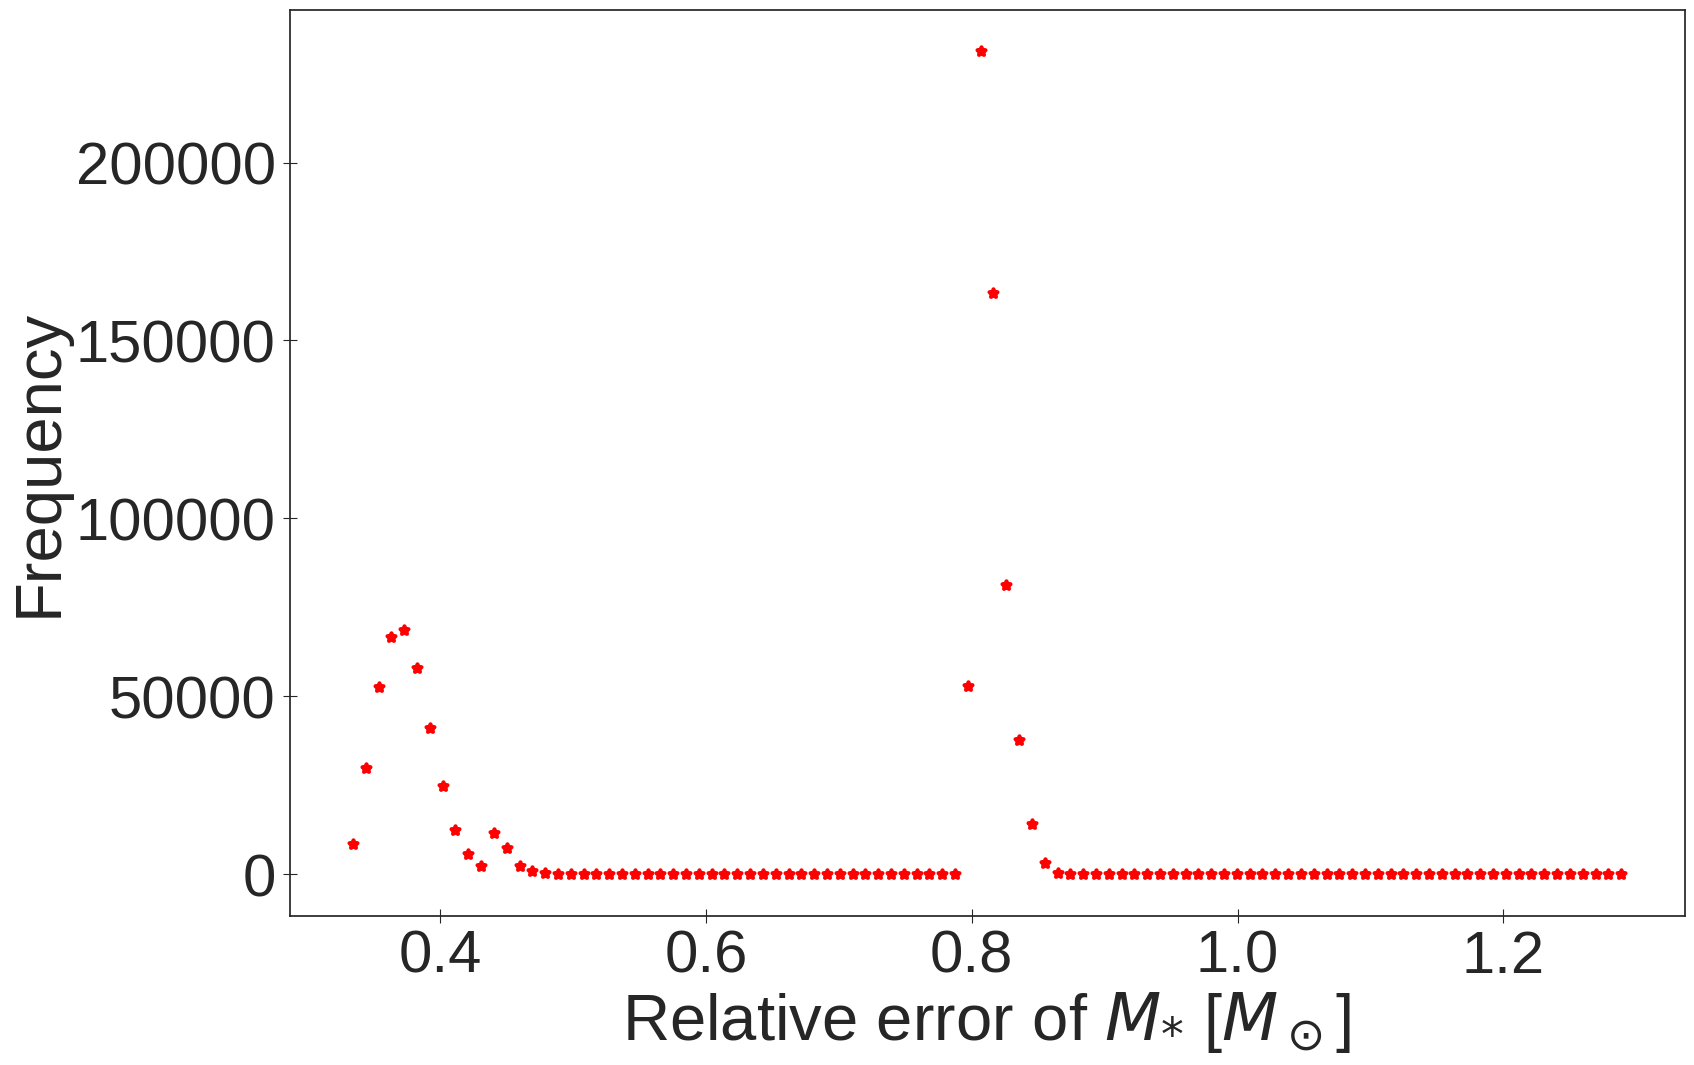

In [45]:
hist_form()
plt.xlabel( 'Relative error of $M_{*}$ [$M_\odot$]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( rel_err_M_Cappellari*np.log(10),  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

### Histogram of the contribution of the terms ($\sigma$-s)

$\mathbf{\sigma_a}$

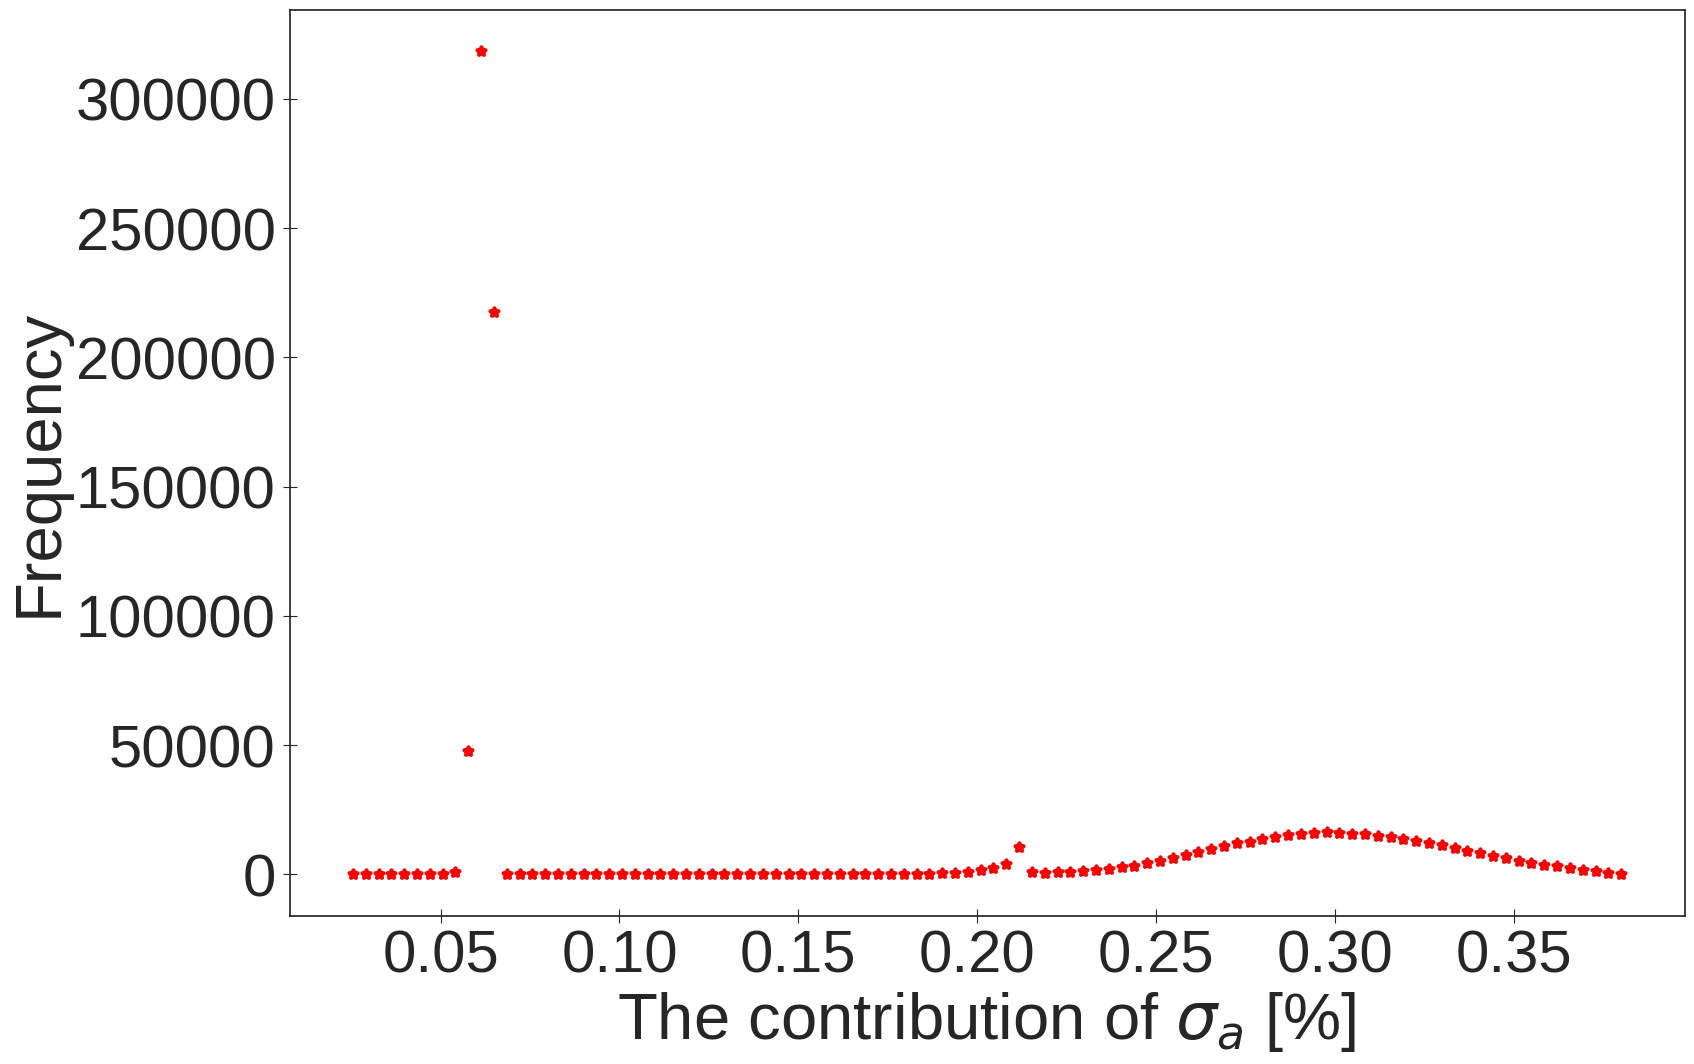

In [46]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_a$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_a/rel_err_M_Cappellari**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [47]:
np.mean( 100*sigma_a/rel_err_M_Cappellari**2 )

0.15784361553447343

$\mathbf{\sigma_b}$

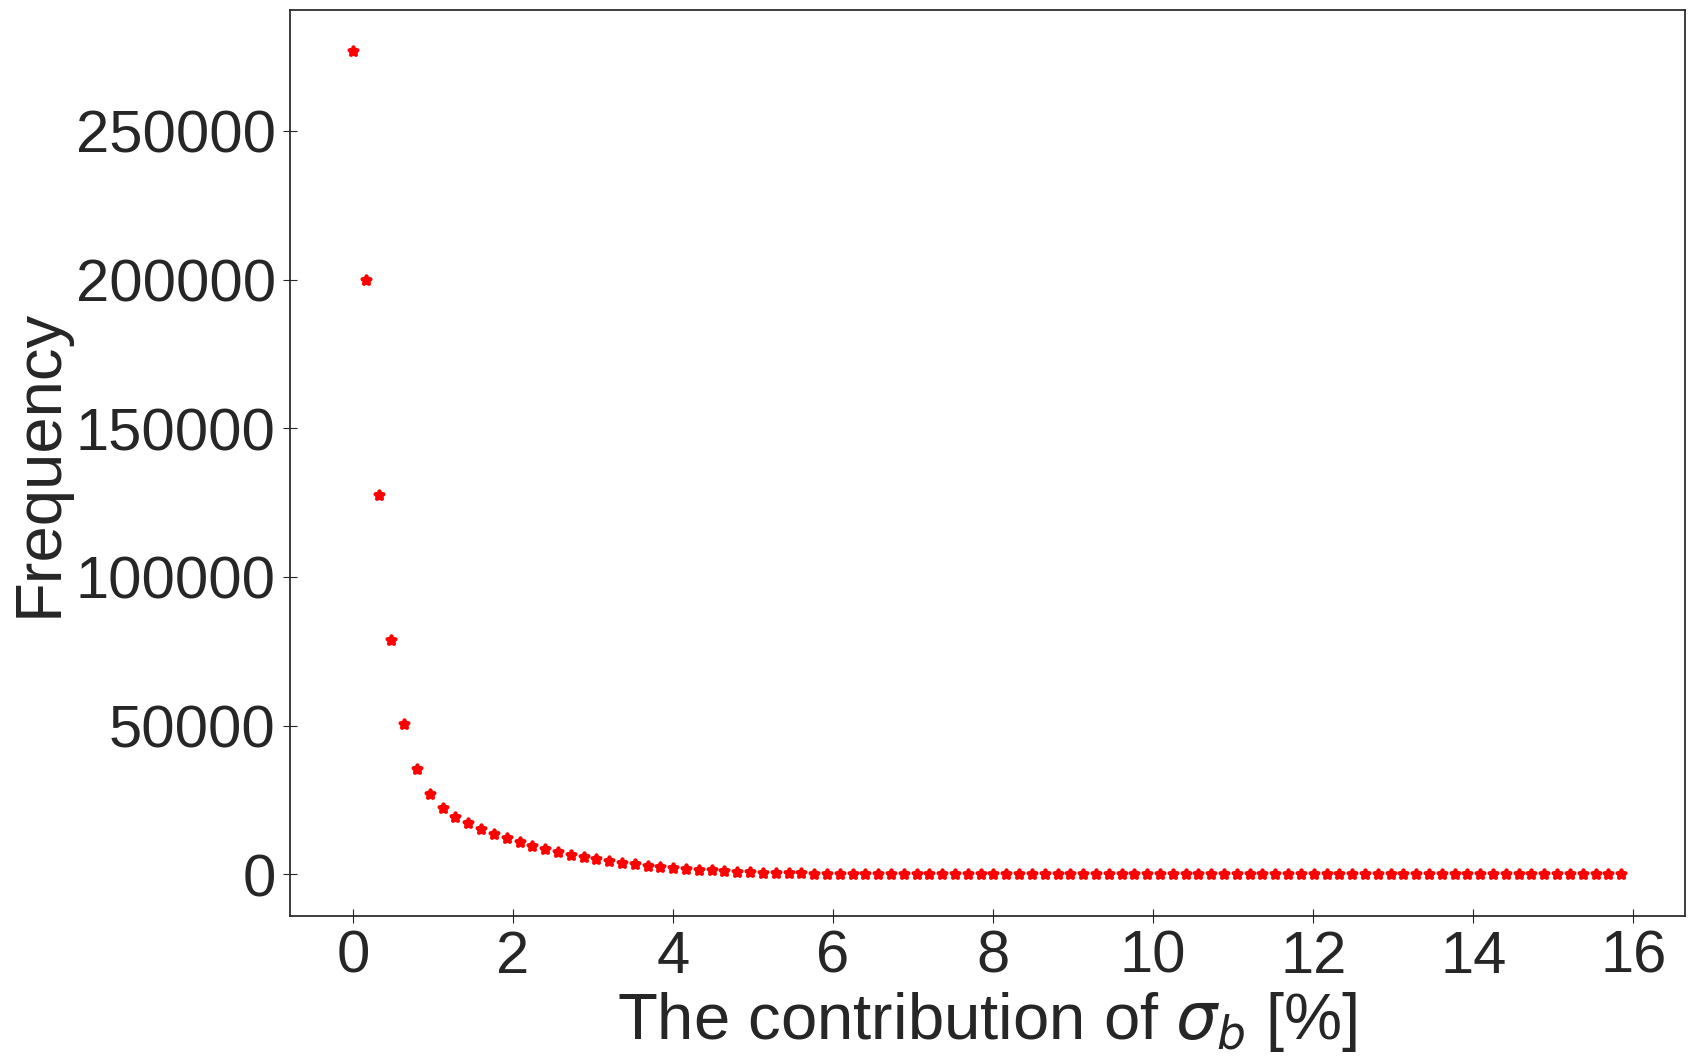

In [48]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_b$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_b/rel_err_M_Cappellari**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [49]:
np.mean( 100*sigma_b/rel_err_M_Cappellari**2 )

0.681195487528074

$\mathbf{\sigma_m}$

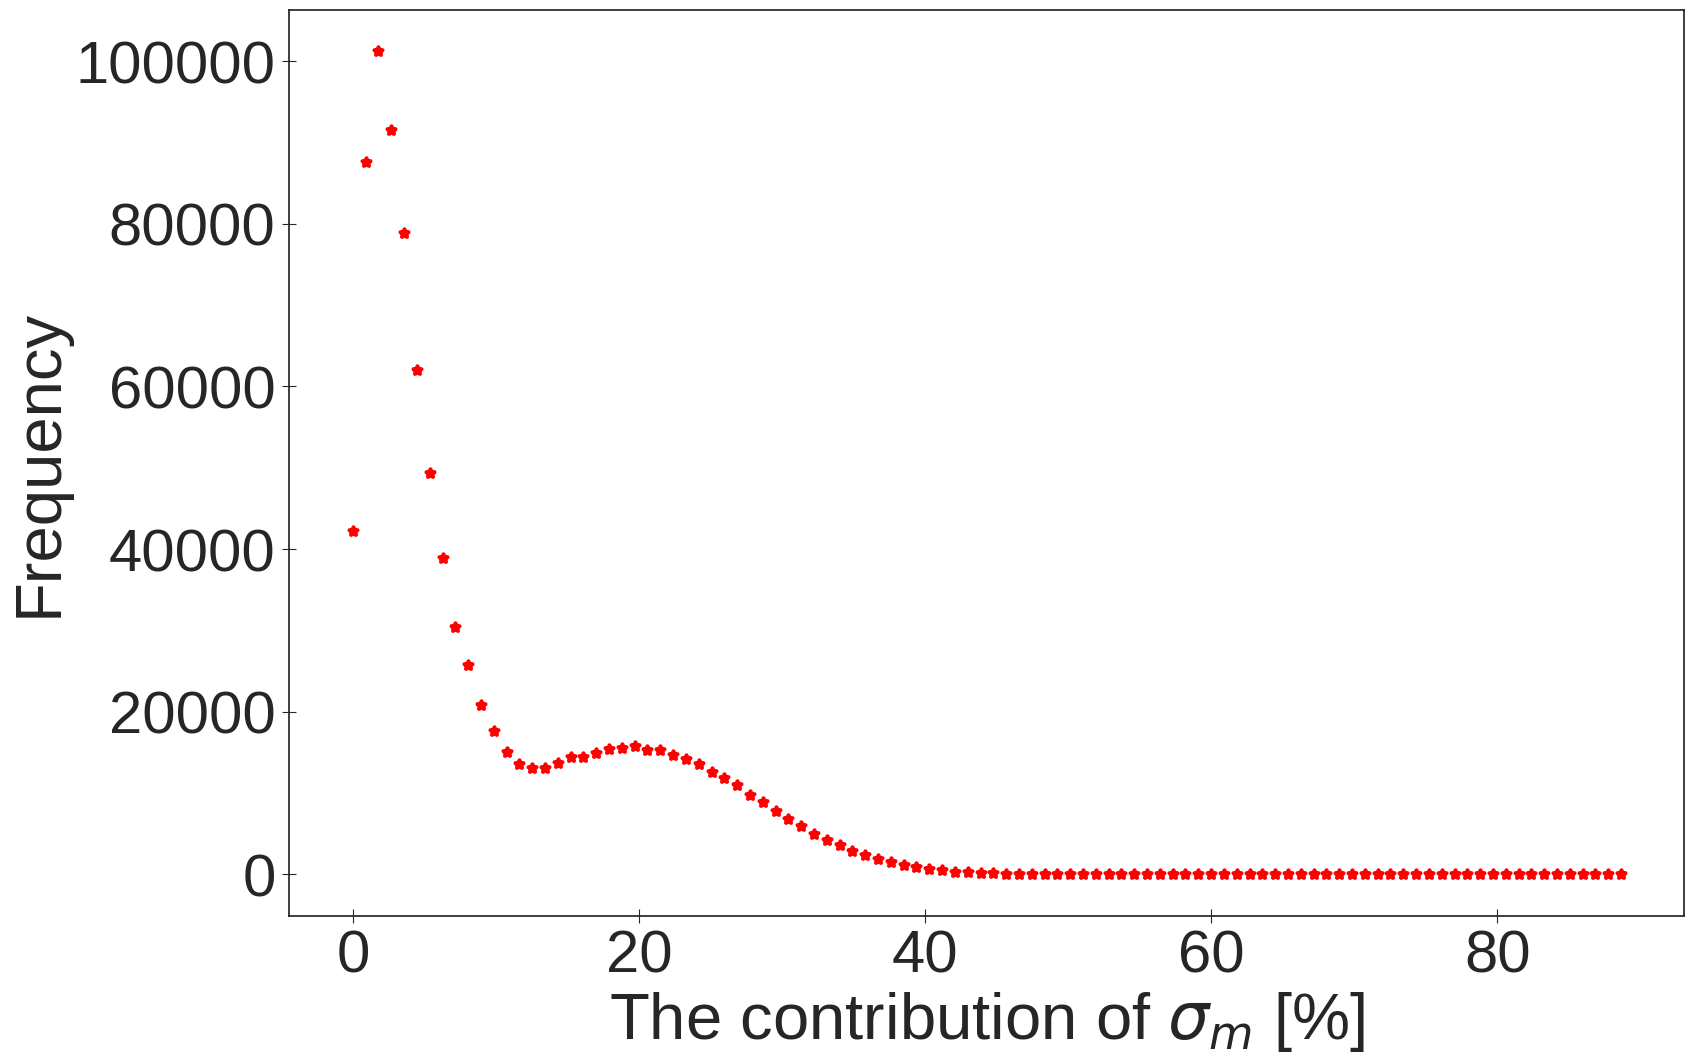

In [50]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_m$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_m/rel_err_M_Cappellari**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [51]:
np.mean( 100*sigma_m/rel_err_M_Cappellari**2 )

10.082010649458665

$\mathbf{\sigma_d}$

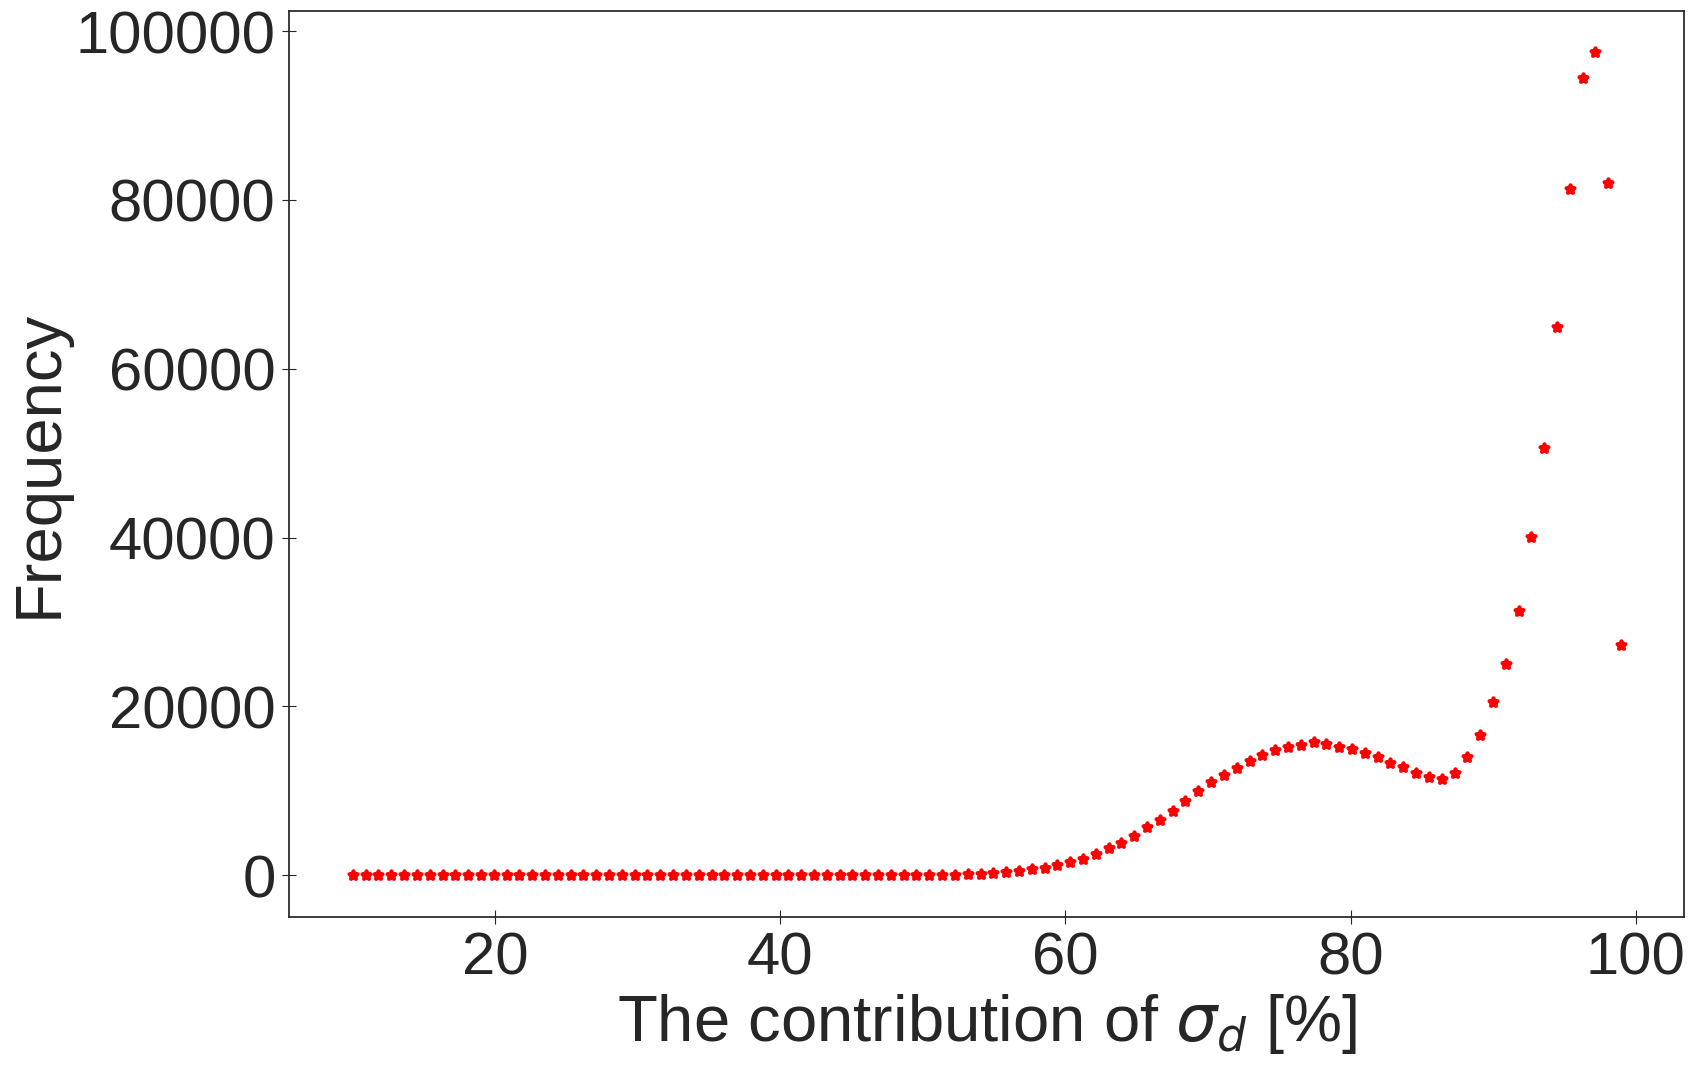

In [52]:
hist_form()
plt.xlabel( 'The contribution of $\sigma_d$ [%]' )
plt.yscale( 'linear' )
plt.autoscale()

freq, bins = np.histogram( 100*sigma_d/rel_err_M_Cappellari**2,  bins=100 )
plt.scatter( bins[:-1], freq,  marker = '*', lw = 3, color = 'red' )

The mean contribution:

In [53]:
np.mean( 100*sigma_d/rel_err_M_Cappellari**2 )

89.07895024748147

Checking the calculations:

In [54]:
( np.abs( (sigma_a + sigma_b + sigma_m + sigma_d)/rel_err_M_Cappellari**2 - 1 ) > 1e-13 ).sum()

0

**The mean of the error in the whole sample and in the different catalogs:**

In [55]:
print( np.mean( rel_err_M_Cappellari ),
      np.mean( rel_err_M_Cappellari[ cat_flag_K == 1] ), np.mean( rel_err_M_Cappellari[ cat_flag_K == 2] ),
      np.mean( rel_err_M_Cappellari[ cat_flag_K == 3] ), np.mean( rel_err_M_Cappellari[ cat_flag_K == 4] ) )

0.2794317494539189 0.19722944148565172 0.3557762433395095 0.1644710386475069 nan


The sum of the percental contribution (should be 100):

In [56]:
0.2+0.7+10.1+89.1

100.1

How many galaxies have stellar mass from this method?

In [57]:
len(M_Cappellari)

979322

### Histogram of the two methods

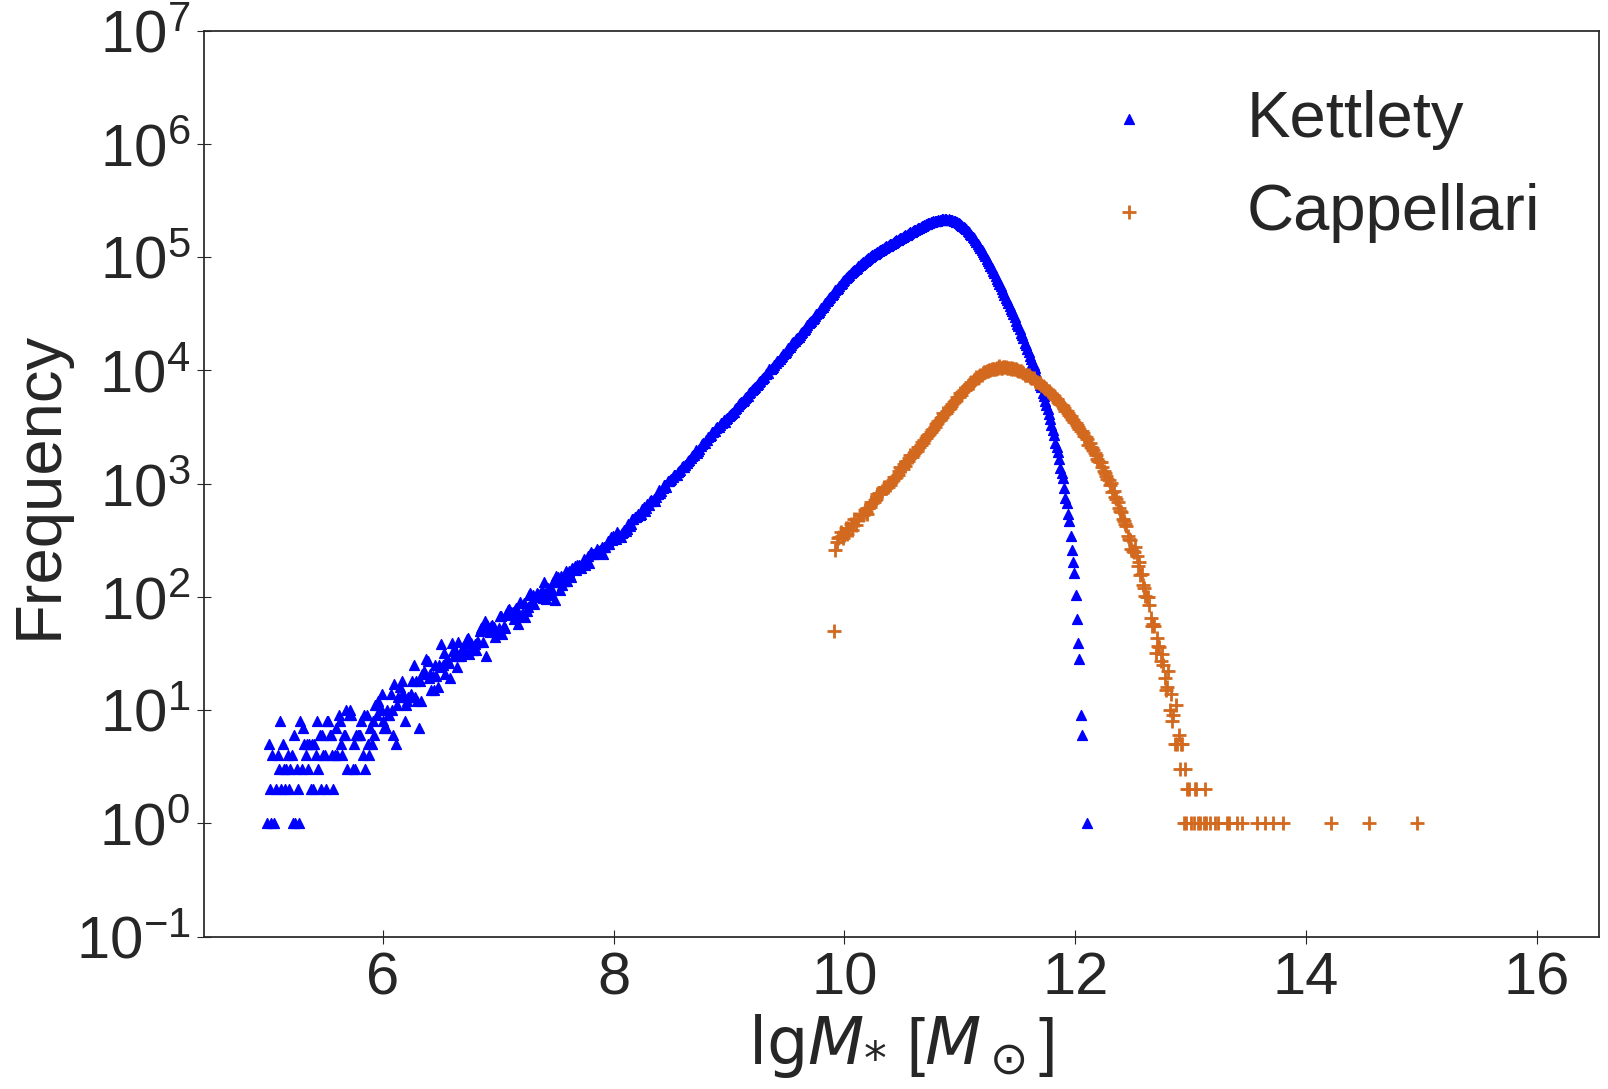

In [58]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(M_Kettlety), bins=np.linspace(5, 16, 1000) )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue',
            label = 'Kettlety' ) 

freq, bins = np.histogram( np.log10(M_Cappellari), bins=np.linspace(5, 16, 1000) )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 100, color = 'chocolate', 
            label = 'Cappellari' )

plt.legend( fontsize = 47 ) # set leged

## Writting the stellar masses to the dataframe

In [59]:
data['SMass_Kettlety'] = M_Kettlety
data['err_SMass_Kettlety'] = err_M_Kettlety
data['SMass_Cappellari'] =  M_Cappellari
data['err_SMass_Cappellari'] = err_M_Cappellari

print( 'Data with stellar masses:')
data

Data with stellar masses:


wiseX  w1mCorr  w1mCorrErr  fromAllSky     GWGC  \
0                         NaN      NaN         NaN         NaN  NGC4736   
1                         NaN      NaN         NaN         NaN  NGC4548   
2                         NaN      NaN         NaN         NaN  NGC6503   
3                         NaN      NaN         NaN         NaN  NGC4442   
4                         NaN      NaN         NaN         NaN  NGC4469   
...                       ...      ...         ...         ...      ...   
23181753  J235402.73+201302.6   14.902       0.034         0.0      NaN   
23181754  J235200.81+201806.7   14.153       0.029         0.0      NaN   
23181755  J235232.36+201806.2   14.678       0.033         0.0      NaN   
23181756  J235039.58+201425.6   14.686       0.032         0.0      NaN   
23181757  J235037.73+201957.3   15.094       0.037         0.0      NaN   

                              Hyp       designation type          ra  \
0                         NGC4736  12505314+4107125    G  192.721451   
1                         NGC4548  12352642+1429467    G  188.860123   
2                         NGC6503  17492651+7008396    G  267.360474   
3                         NGC4442  12280389+0948130    G  187.016220   
4                         NGC4469               NaN    G  187.367000   
...                           ...               ...  ...         ...   
23181753  SDSSJ235402.72+201302.6               NaN    G  358.511000   
23181754  SDSSJ235200.81+201806.7               NaN    G  358.003000   
23181755  SDSSJ235232.35+201806.5               NaN    G  358.135000   
23181756  SDSSJ235039.56+201426.0               NaN    G  357.665000   
23181757  SDSSJ235037.73+201957.3               NaN    G  357.657000   

                dec  ...      W2         z       lumdis  lumdis_err  k_m_ext  \
0         41.120152  ...     NaN  0.000991     4.392418         NaN    5.106   
1         14.496320  ...     NaN  0.004120    11.201905         NaN    7.115   
2         70.144341  ...     NaN  0.001000     9.020106         NaN    7.296   
3          9.803620  ...     NaN  0.003557     9.499651         NaN    7.294   
4          8.749890  ...     NaN  0.004139    10.817553         NaN      NaN   
...             ...  ...     ...       ...          ...         ...      ...   
23181753  20.217400  ...  14.744  0.308475  1654.841013         NaN      NaN   
23181754  20.301880  ...  13.819  0.200333  1014.188600         NaN      NaN   
23181755  20.301830  ...  14.284  0.201158  1018.845712         NaN      NaN   
23181756  20.240560  ...  14.440  0.356846  1959.611688         NaN      NaN   
23181757  20.332600  ...  14.811  0.397962  2226.809938         NaN      NaN   

          k_msig_ext  SMass_Kettlety  err_SMass_Kettlety  SMass_Cappellari  \
0              0.016             NaN                 NaN      4.262534e+10   
1              0.031             NaN                 NaN      4.394366e+10   
2              0.021             NaN                 NaN      2.267061e+10   
3              0.024             NaN                 NaN      2.538143e+10   
4                NaN             NaN                 NaN               NaN   
...              ...             ...                 ...               ...   
23181753         NaN    1.794782e+11        1.308541e+11               NaN   
23181754         NaN    1.716854e+11        1.251070e+11               NaN   
23181755         NaN    1.066267e+11        7.771431e+10               NaN   
23181756         NaN    2.769915e+11        2.019550e+11               NaN   
23181757         NaN    2.256694e+11        1.646004e+11               NaN   

          err_SMass_Cappellari  
0                 1.900195e+10  
1                 1.962626e+10  
2                 1.011397e+10  
3                 1.132613e+10  
4                          NaN  
...                        ...  
23181753                   NaN  
23181754                   NaN  
23181755                   NaN  
23181756                   NaN

In [60]:
# Filtration the galaxies which have stellar mass from both method:
M_Cappellari_frame = copy.deepcopy( data[ ~np.isnan(data.SMass_Cappellari) ] )
print('Galaxies with stellar mass from Cappelari\'s method:', M_Cappellari_frame.shape[0])
data_mass = M_Cappellari_frame[ ~np.isnan(M_Cappellari_frame.SMass_Kettlety) ]
print('Galaxies with stellar mass from both method:', data_mass.shape[0])

Galaxies with stellar mass from Cappelari's method: 979322
Galaxies with stellar mass from both method: 186367


## Calibration of stellar masses from Cappellari's method to Kettlety's method

Functions for the fitting:

In [61]:
# for the linear fitting
def linfit( x, a, b ):
    return a*x+b

In [62]:
def func(p, x):
    a, b = p
    return a * x + b

In [63]:
def method_comparison( first, second, first_err, second_err, ylim = [0,0.05], size = 0.01, errors = False ):
    # form the figure:
    fig = plt.figure( figsize = (9, 7), dpi = 100 )
    plt.xlabel( '$M_{*}$ from Cappellari\'s method [$M_\odot$]', fontsize = 20 )
    plt.ylabel( '$M_{*}$ from Kettlety\'s method [$M_\odot$]', fontsize = 20 )
    plt.xlim( [0,1.1] )
    plt.ylim( ylim )
    plt.xticks( fontsize = 15 )
    plt.yticks( fontsize = 15 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )
    
    
    # fit:
    plt.rcParams['agg.path.chunksize'] = 10000
    popt, pcov = curve_fit( linfit, first/np.max(first), second/np.max(first), p0 = [10, 10],
                           sigma = second_err/np.max(first) )
    plt.rcParams["font.size"] = 15
    plt.figtext( 0.25, 0.8,'a = '+ '{:.2e}'.format( popt[0] ) + '$\pm$' + '{:.2e}'.format( pcov[0,0] ) +
                ', b = '+ '{:.2e}'.format( popt[1] ) + '$\pm$'+'{:.2e}'.format( pcov[1,1] ) ) 
                #'a = '+ '{:.2e}'.format( popt[0] ) + ', b = '+
             #'{:.2e}'.format( popt[1] ) )
    
    # prepare confidence level curves
    perr = np.array( [ pcov[0,0], pcov[1,1] ] )
    nstd = 5. # to draw 5-sigma intervals
    popt_up = popt + nstd * perr
    popt_dw = popt - nstd * perr

    x_fit = np.linspace(min(first/np.max(first)), max(first/np.max(first)), 100)
    fit = func(popt, x_fit)
    fit_up = func(popt_up, x_fit)
    fit_dw= func(popt_dw, x_fit)
    
    #plot
    if errors == True:
        plt.errorbar(first/np.max(first), second/np.max(first), 
                     yerr=second_err/np.max(first), xerr=first_err/np.max(first), 
                     hold=True, ecolor='gray', fmt='none', elinewith = 0.1 )
    plt.scatter( first/np.max(first), second/np.max(first), s = size, c = 'magenta' )
    plt.plot(x_fit, fit, 'forestgreen', lw=1, label='best fit curve')
    plt.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label='5-sigma interval')
    
    # draw a 45 degree straight line:
    xval = np.linspace( min(first/np.max(first)), max(first/np.max(first)), len(first/np.max(first)) )
    plt.plot( xval, xval, c ='black', lw = 0.5)

    # print the number of stellar masses:
    plt.figtext( 0.25, 0.75, 'Number of galaxies: '+ '{:}'.format( len(first) ) )
    
    # giving the fitting parameters:
    return( popt[0], popt[1], pcov[0,0], pcov[1,1], np.max(first) )

Fitting to the whole sample:

(0.15910185219840595,
 0.00014795604117045025,
 3.192711491500217e-08,
 4.704377940824157e-13,
 38643325879760.516)

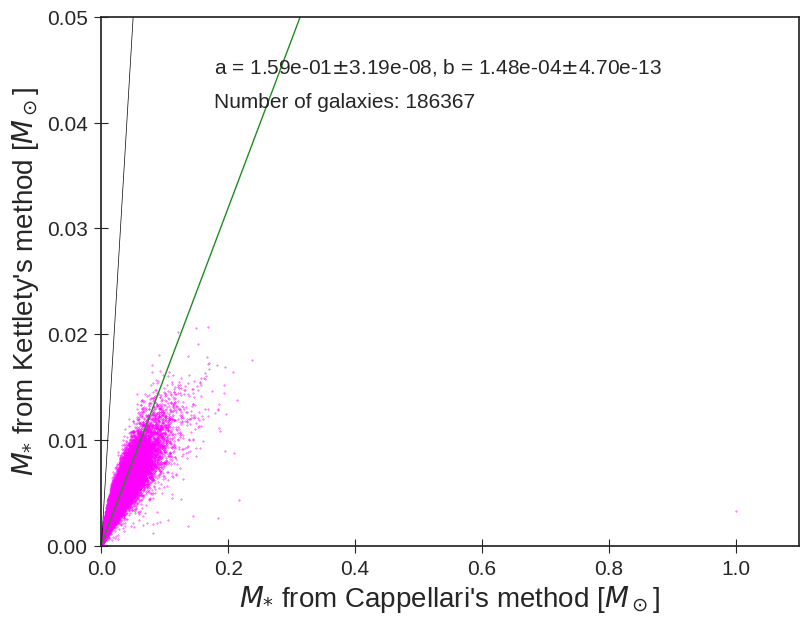

In [64]:
method_comparison( data_mass.SMass_Cappellari,
                  data_mass.SMass_Kettlety,
                  data_mass.err_SMass_Cappellari,
                  data_mass.err_SMass_Kettlety,
                  size = 0.1, errors = False )

(0.0, 0.03)

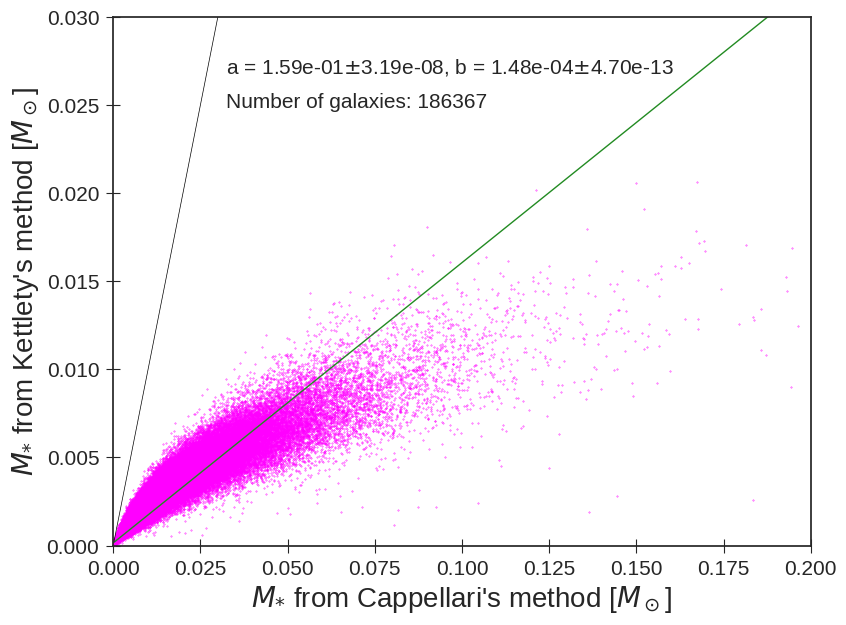

In [65]:
method_comparison( data_mass.SMass_Cappellari,
                  data_mass.SMass_Kettlety,
                  data_mass.err_SMass_Cappellari,
                  data_mass.err_SMass_Kettlety,
                  size = 0.1, errors = False )
plt.xlim( 0, 0.2 )
plt.ylim(0,0.03)

With error bars:

(0.15910185219840595,
 0.00014795604117045025,
 3.192711491500217e-08,
 4.704377940824157e-13,
 38643325879760.516)

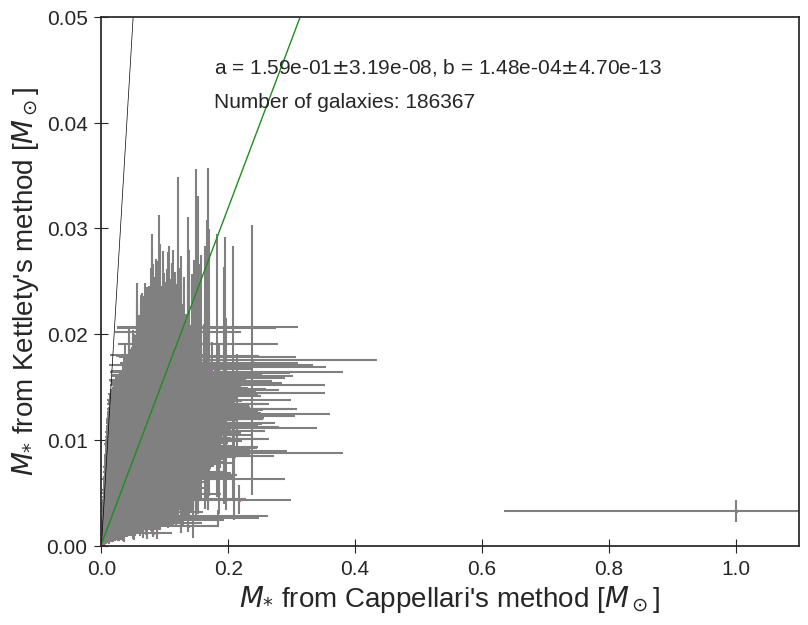

In [66]:
method_comparison( data_mass.SMass_Cappellari,
                  data_mass.SMass_Kettlety,
                  data_mass.err_SMass_Cappellari,
                  data_mass.err_SMass_Kettlety,
                  size = 2, errors = True )

Every 2000. pointswith error bars:

(0.0, 0.02)

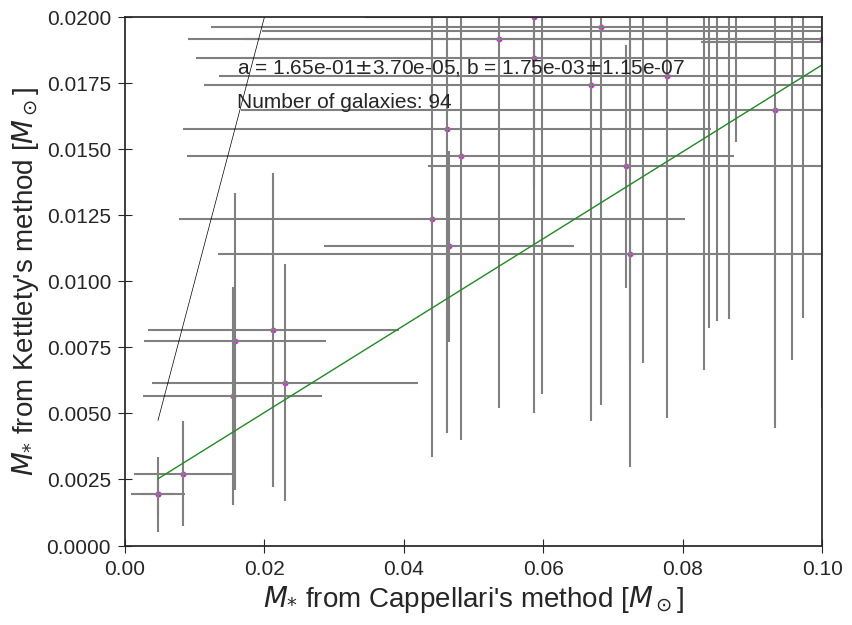

In [67]:
method_comparison( data_mass.SMass_Cappellari[::2000],
                  data_mass.SMass_Kettlety[::2000],
                  data_mass.err_SMass_Cappellari[::2000],
                  data_mass.err_SMass_Kettlety[::2000],
                  size = 10, errors = True )
plt.xlim( 0, 0.1 )
plt.ylim(0,0.02)

Drop out the outlier:

In [70]:
bin_num = 100

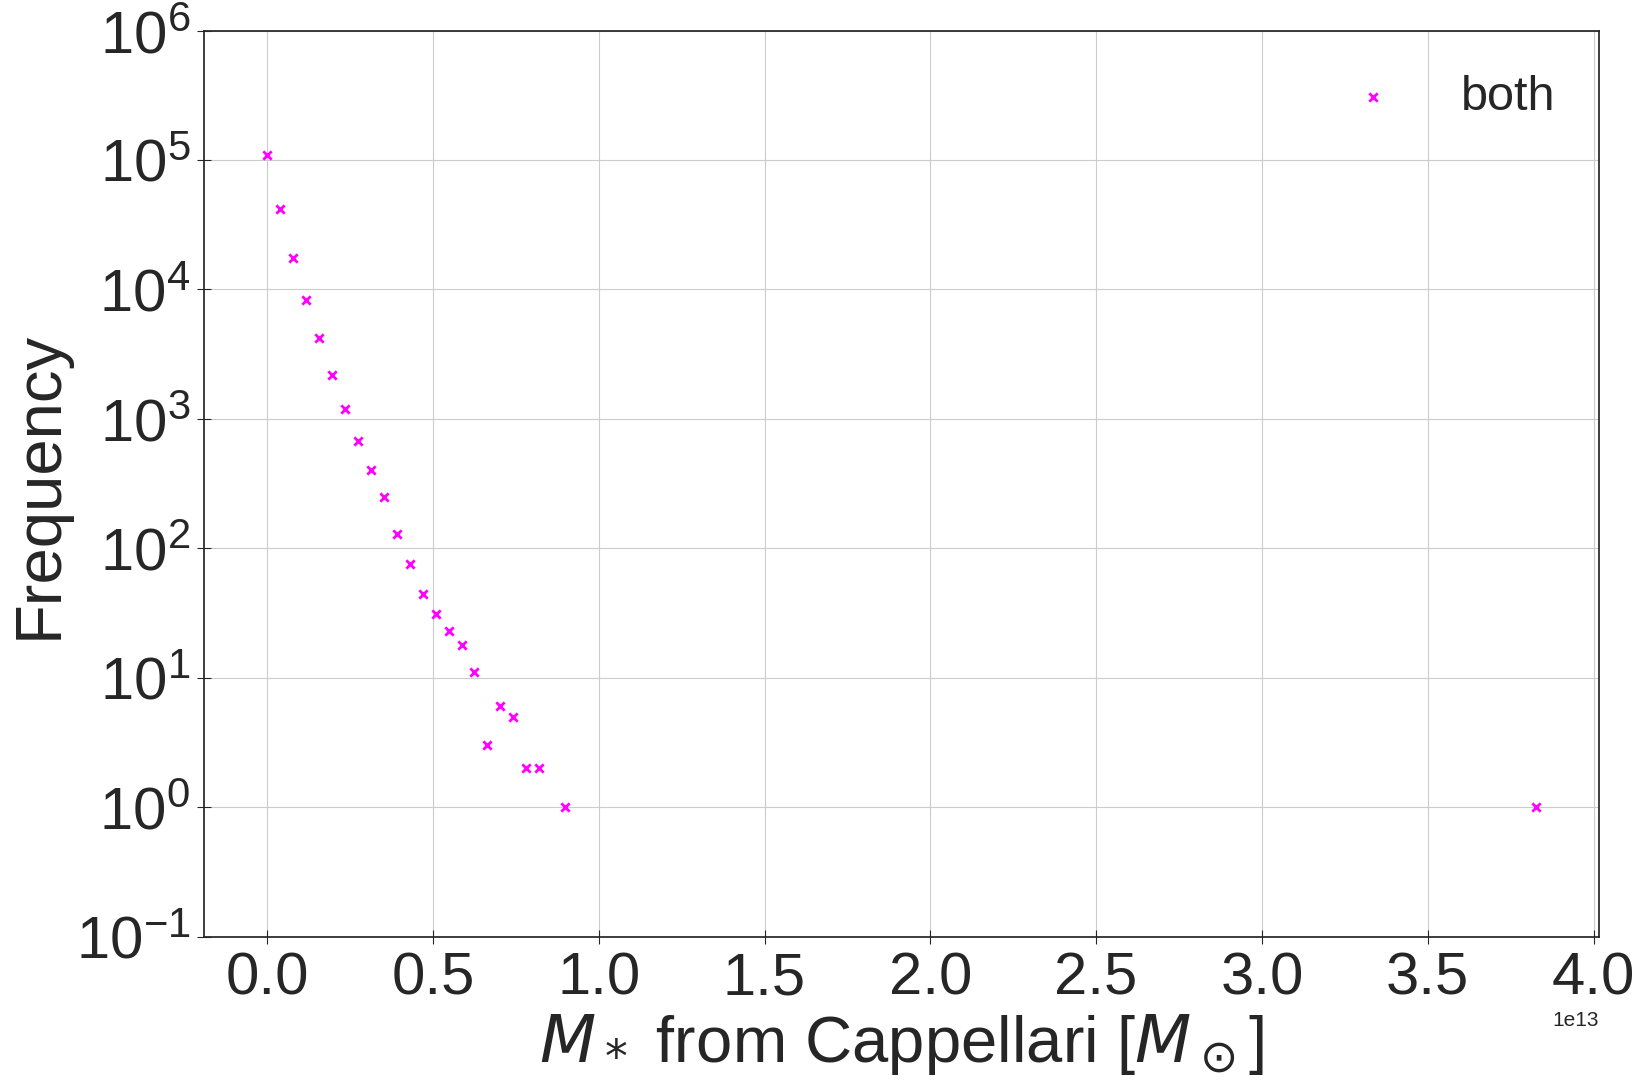

In [71]:
hist_form( '$M_*$ from Cappellari [$M_\odot$]', logscale=True )
#plt.xscale( 'log' )
plt.ylim(1e-1, 1e6)

freq2, bins2 = np.histogram( data_mass.SMass_Cappellari, 
                          bins = np.linspace( np.min(data_mass.SMass_Cappellari),
                                             np.max(data_mass.SMass_Cappellari), bin_num ) )
plt.scatter( bins2[:-1],freq2,  
            marker = 'x', lw = 2, color = 'magenta', label = 'both' )

plt.grid()
plt.legend( fontsize = 35 )

In [72]:
sm_filt = data_mass[ data_mass.SMass_Cappellari < 1e13 ]
len(sm_filt), len(data_mass) - len(sm_filt)

(186366, 1)

In [73]:
np.sum(M_Cappellari > 1e13)

26

There are only 26 galaxies having $M_* > 10^{13}$ from the original sample.

Looking at the histograms:

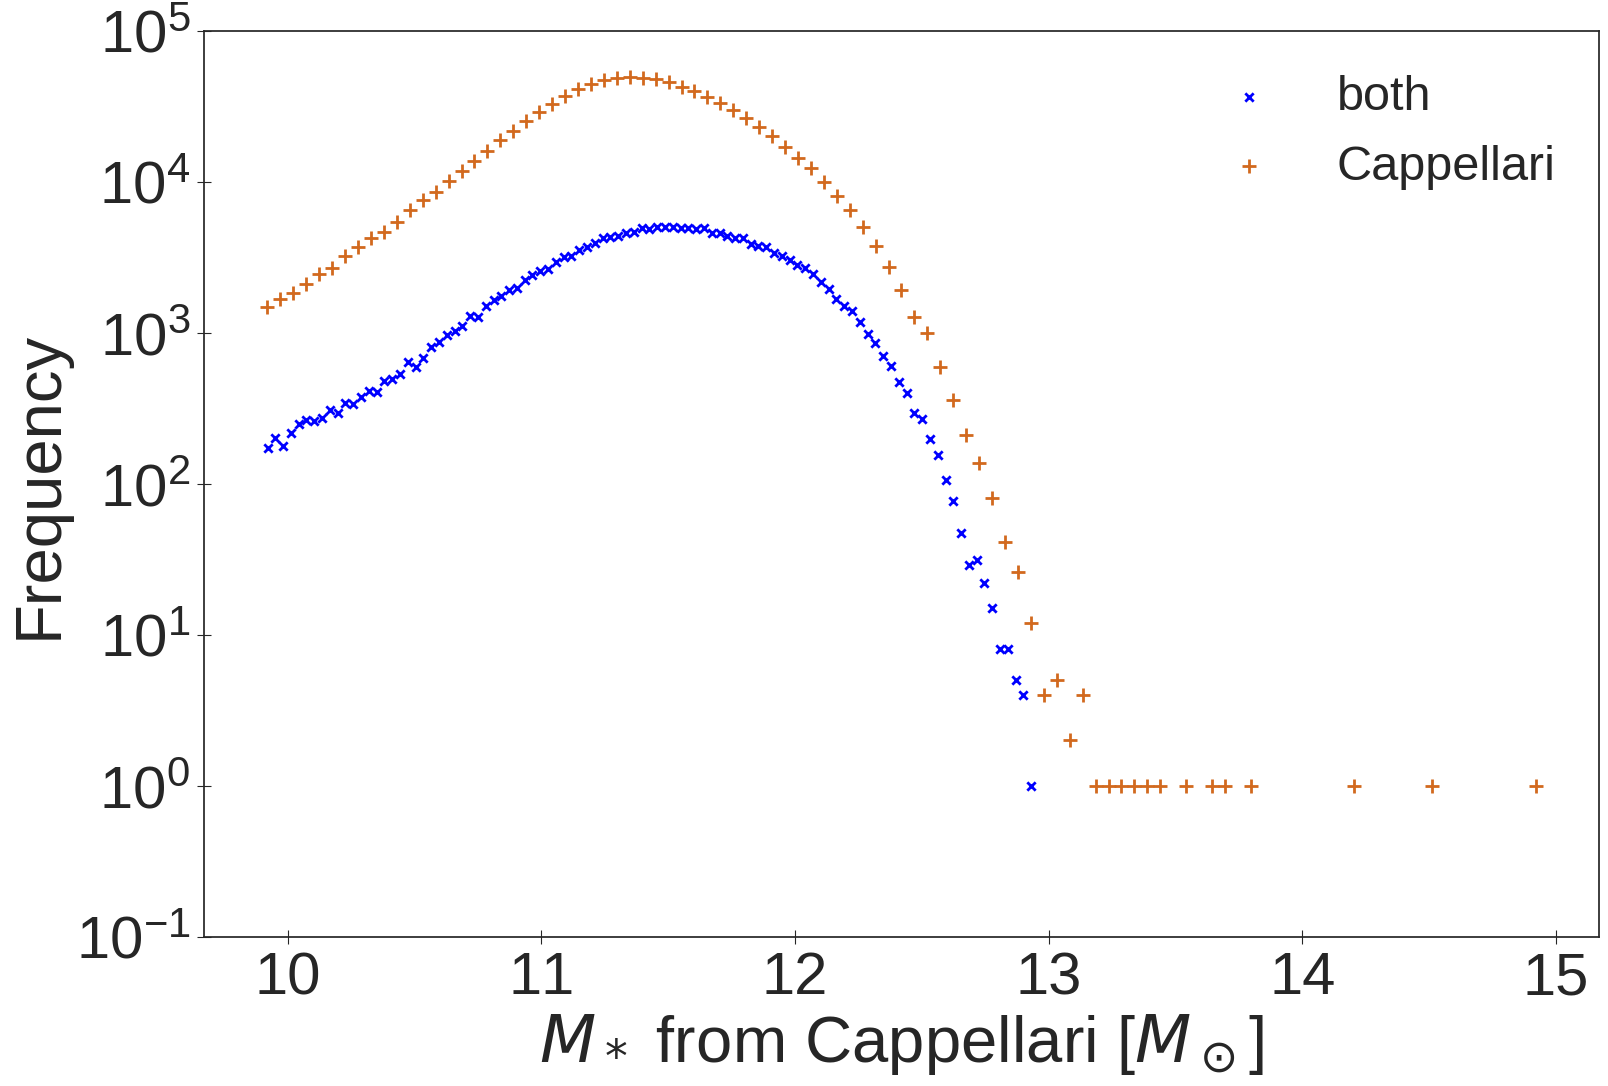

In [74]:
hist_form( '$M_*$ from Cappellari [$M_\odot$]' )
#plt.xscale( 'log' )
plt.ylim(1e-1, 1e5)

freq2, bins2 = np.histogram( np.log10(sm_filt.SMass_Cappellari), 
                          bins = np.linspace( np.min(np.log10(sm_filt.SMass_Cappellari)),
                                             np.max(np.log10(sm_filt.SMass_Cappellari)), bin_num ) )
plt.scatter( bins2[:-1],freq2, marker = 'x', lw = 2, color = 'blue', label = 'both' )

freq, bins = np.histogram( np.log10(M_Cappellari), 
                          bins=np.linspace( np.min(np.log10(M_Cappellari)), 
                                           np.max(np.log10(M_Cappellari)), bin_num) )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 100, color = 'chocolate', 
            label = 'Cappellari' )

#plt.vlines( np.max(sm_filt.SMass_Cappellari), 1e-1, 1e7, lw = 0.2, color = 'black')

plt.legend( fontsize = 35 )

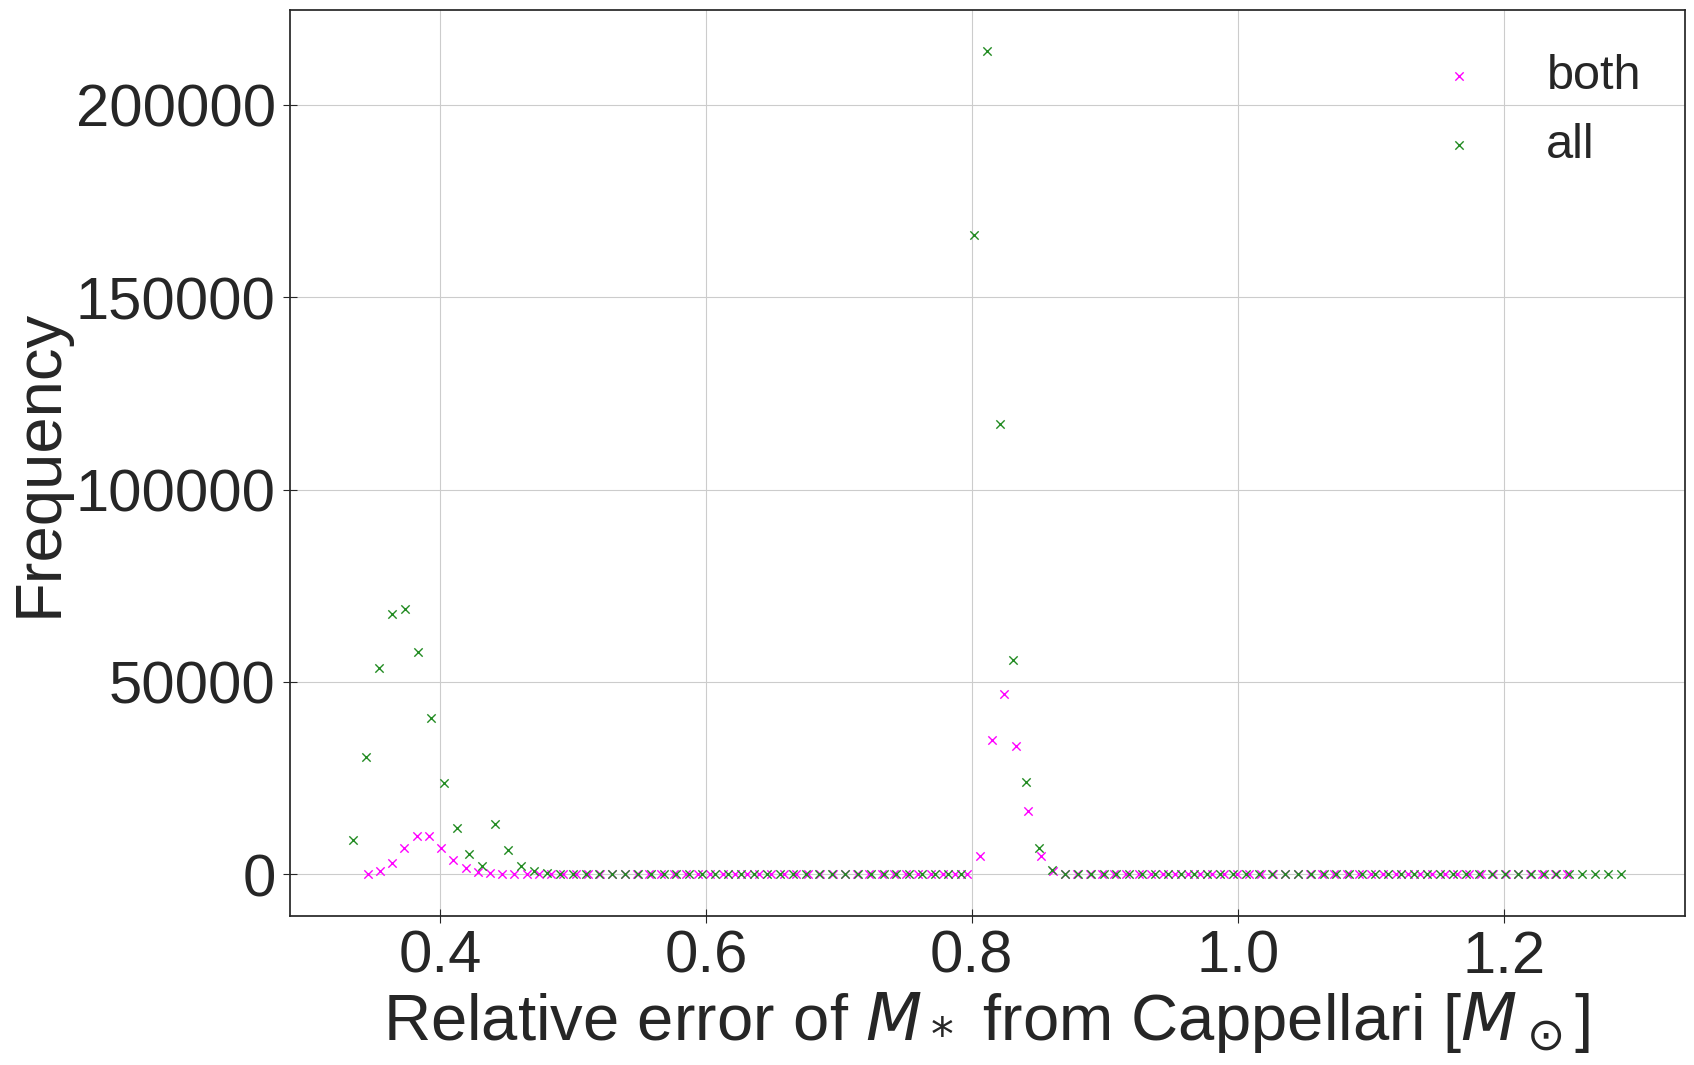

In [75]:
hist_form( 'Relative error of $M_*$ from Cappellari [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data_mass.err_SMass_Cappellari/data_mass.SMass_Cappellari
freq2, bins2 = np.histogram( x, 
                          bins = np.linspace( np.min(x), np.max(x), bin_num ) )
plt.scatter( bins2[:-1],freq2,  
            marker = 'x', lw = 1, color = 'magenta', label = 'both' )

x = M_Cappellari_frame.err_SMass_Cappellari/M_Cappellari_frame.SMass_Cappellari
freq2, bins2 = np.histogram( x, 
                          bins = np.linspace( np.min(x), np.max(x), bin_num ) )
plt.scatter( bins2[:-1],freq2,  
            marker = 'x', lw = 1, color = 'forestgreen', label = 'all' )

plt.grid()
plt.legend( fontsize = 35 )

#### Redshift bins

Let the number of galaxies are approximately same in the bins.

(array([53772, 64453, 38089, 21686]), array([0.05, 0.1 , 0.15, 0.2 , 0.45]))

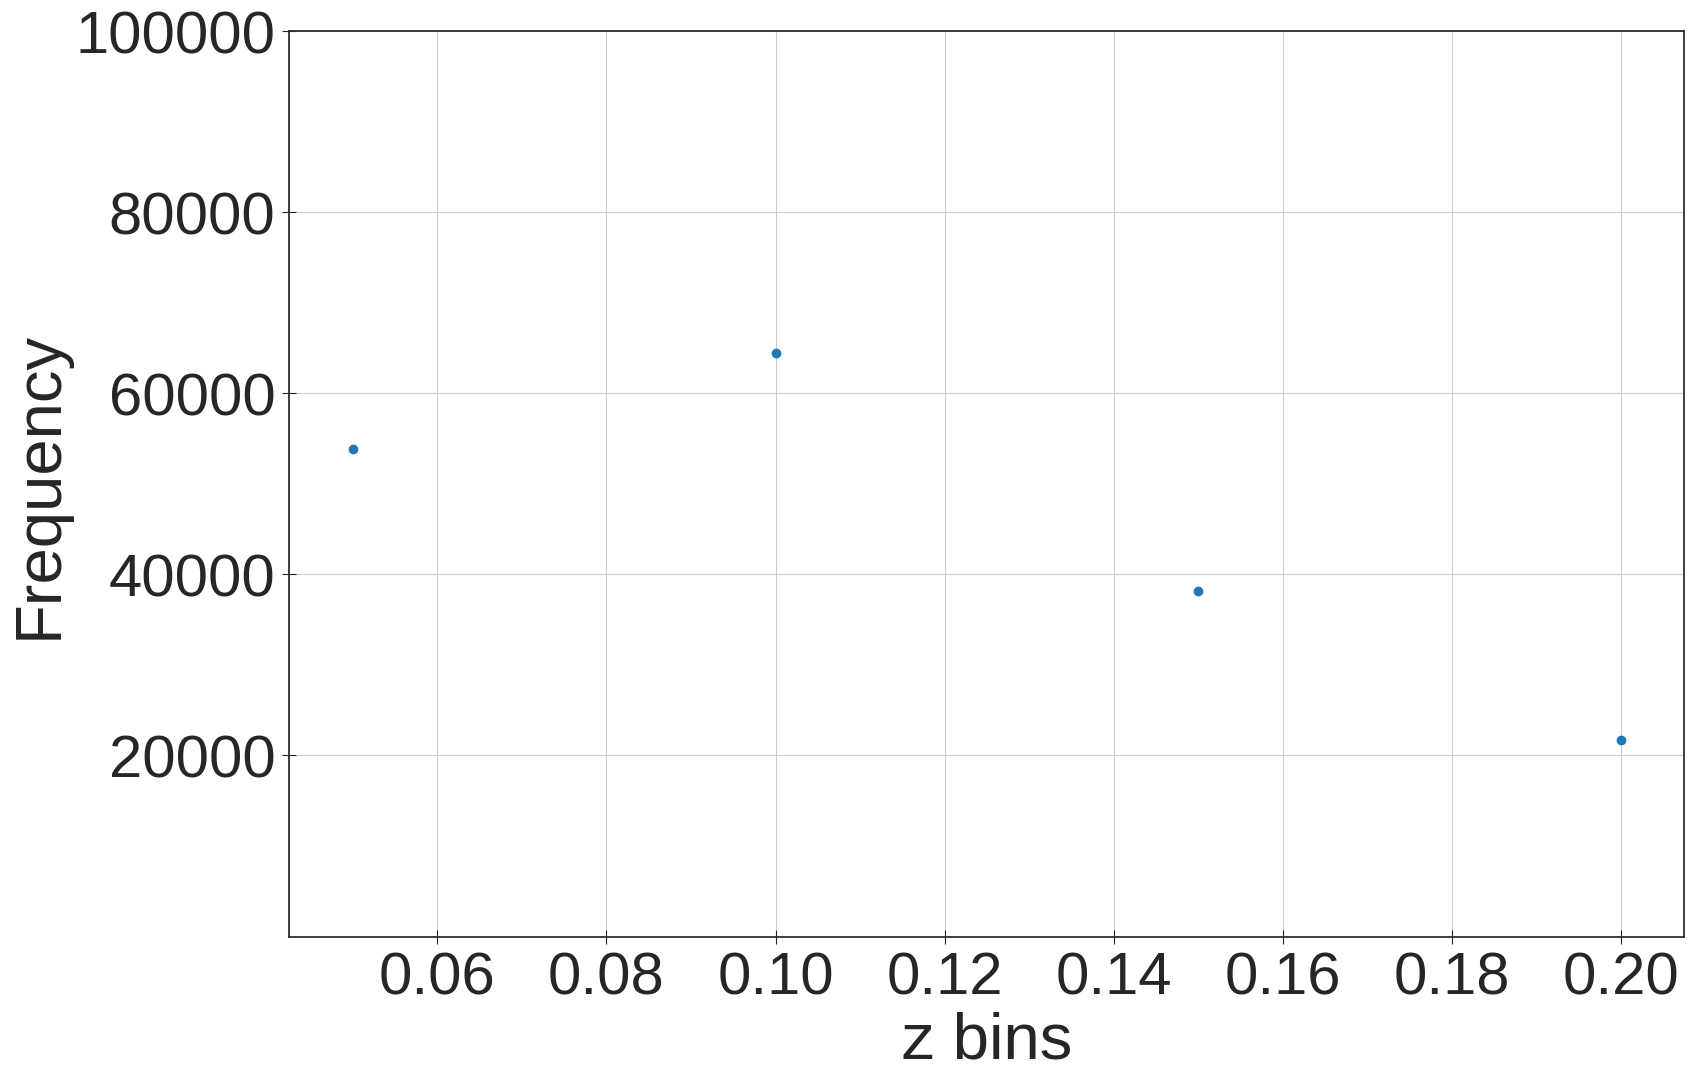

In [76]:
z_bins = [ 0.05, 0.1, 0.15, 0.2, 0.45 ]
freq, bins = np.histogram( sm_filt.z, bins=z_bins )

figsize_x = 12
figsize_y = 8

hist_form( 'z bins', logscale=True )
plt.yscale('linear')
plt.scatter( bins[:-1], freq )
plt.grid()

freq, bins

Ascendent ordering of the redshift:

In [77]:
sm_filt_sorted = sm_filt.sort_values( by = 'z' )

Creating the redshift limits -- one bin sould contain ~20 000 galaxies:

In [78]:
up_lim = 0
bin_width = 20000
lims =[]
while up_lim < len(sm_filt):
    down_lim = up_lim
    up_lim = down_lim + bin_width
    print( down_lim, up_lim )
    lims.append( down_lim )

0 20000
20000 40000
40000 60000
60000 80000
80000 100000
100000 120000
120000 140000
140000 160000
160000 180000
180000 200000


In [79]:
z_sorted = np.array( sm_filt_sorted.z )
z_lims = []
for i in range( len(lims)-1 ):
    z_lims.append( z_sorted[lims[i]]  )
z_lims

[0.01508,
 0.06601,
 0.082876,
 0.0982882391441,
 0.11284,
 0.127959,
 0.14418399999999998,
 0.164238562119,
 0.191468855734]

Fitting:

a:
 [0.24158984057937105, 0.08161956703177731, 0.08097319977507185, 0.06149918095907136, 0.06897263174536254, 0.04699366722673191, 0.050132956296739105, 0.05348368283080538]

b:
 [0.006313384738966587, 0.021555996515501337, 0.021983903300506136, 0.01774310587213683, 0.015732485003098762, 0.010363939423038152, 0.02593501848595814, 0.012606000164263763]

da:
 [7.726609149028745e-07, 9.937454229135633e-07, 1.0417590535117868e-06, 8.174878115836385e-07, 7.339035744099195e-07, 5.388149973487372e-07, 5.335592899761645e-07, 3.899034902454411e-07]

db:
 [1.574211063574885e-08, 1.465045936716765e-08, 1.8261016831617304e-08, 8.843042707363306e-09, 7.822781574951103e-09, 2.389403917660245e-09, 1.843709085673646e-08, 4.4104183695816585e-09]

max_mass:
 [223372880180.17307, 987736772380.7708, 1395703842657.6714, 2522002148012.6533, 3377149432443.7656, 7093163378319.193, 3390081099997.425, 8361502452480.923]


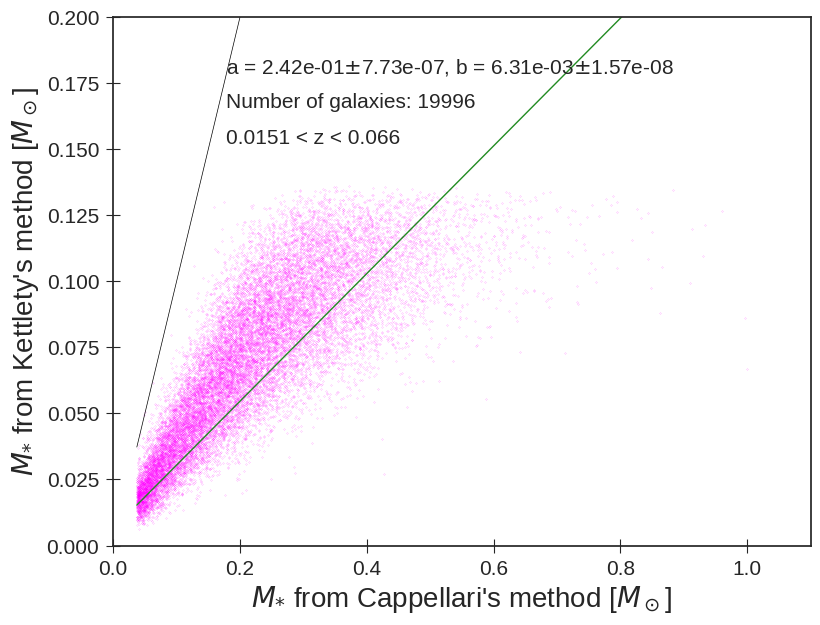

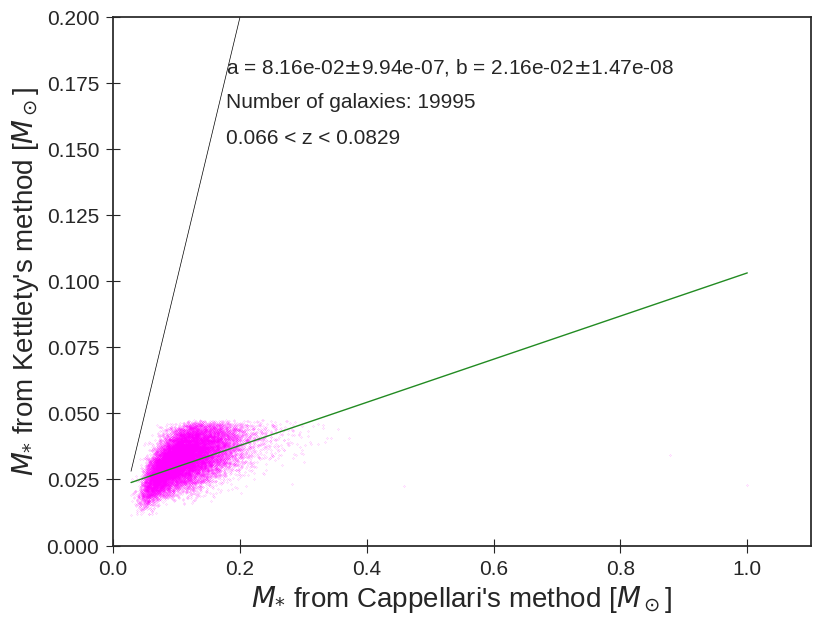

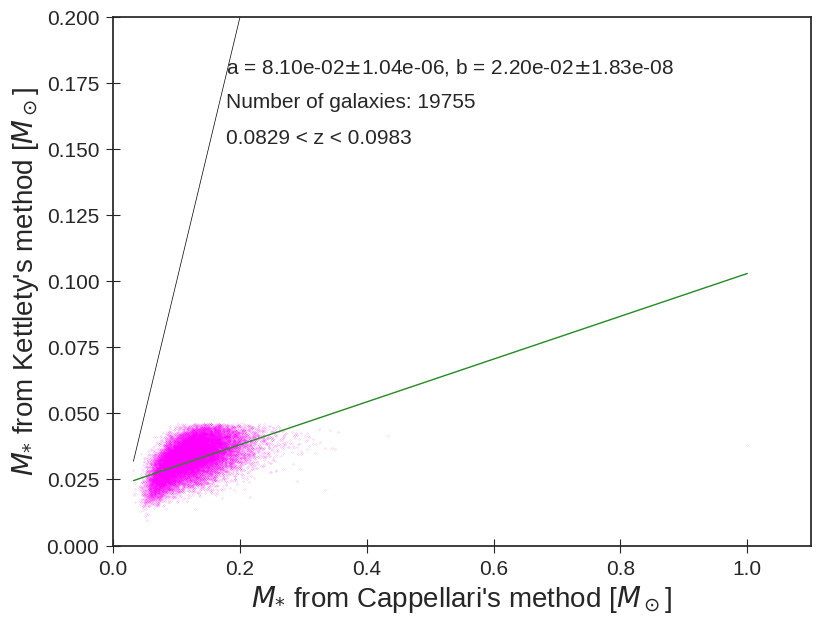

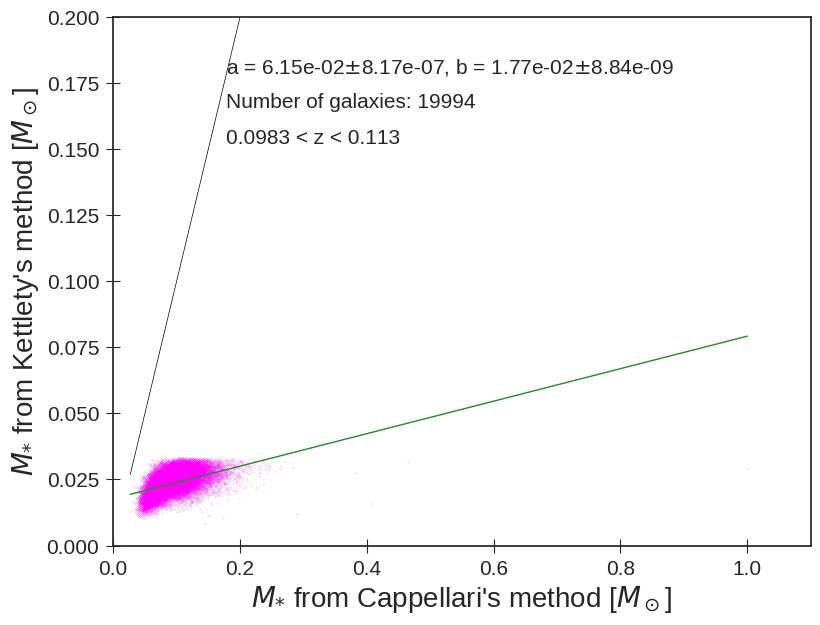

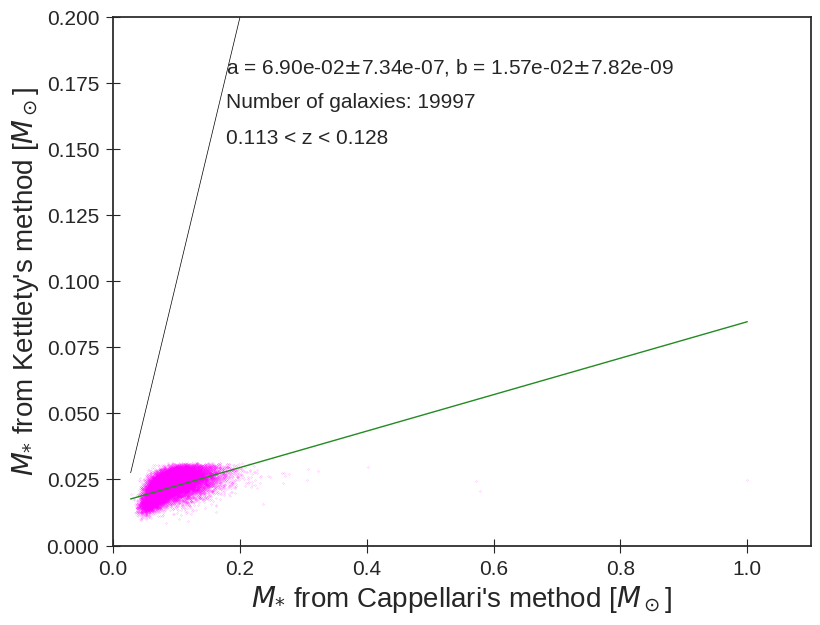

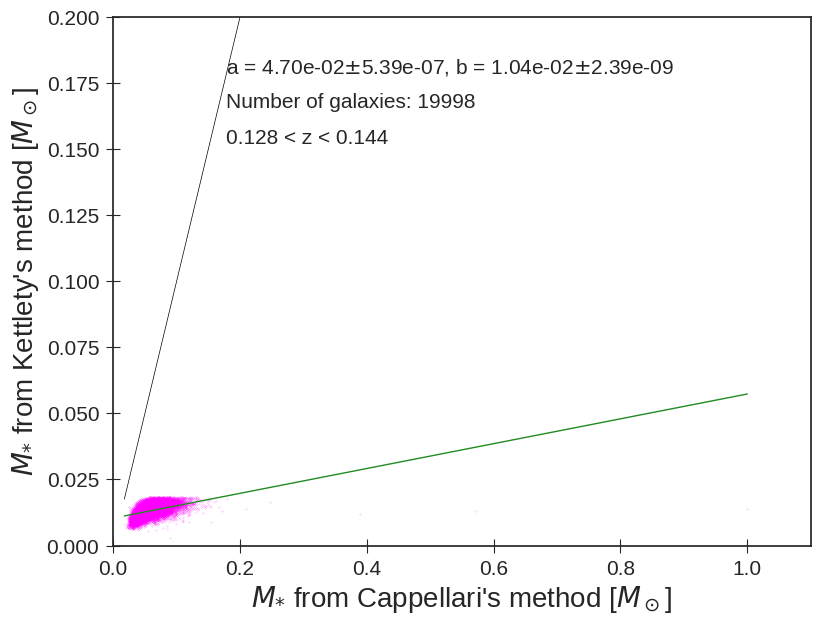

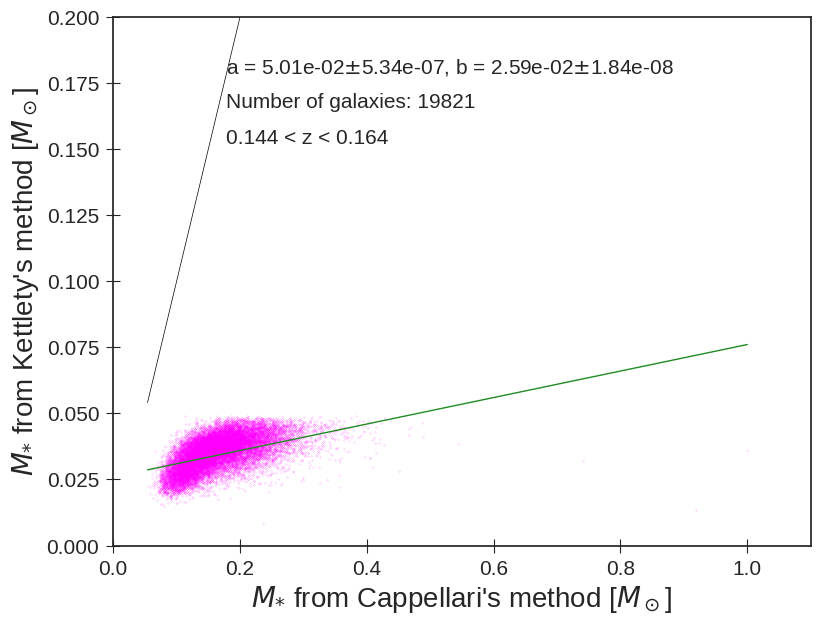

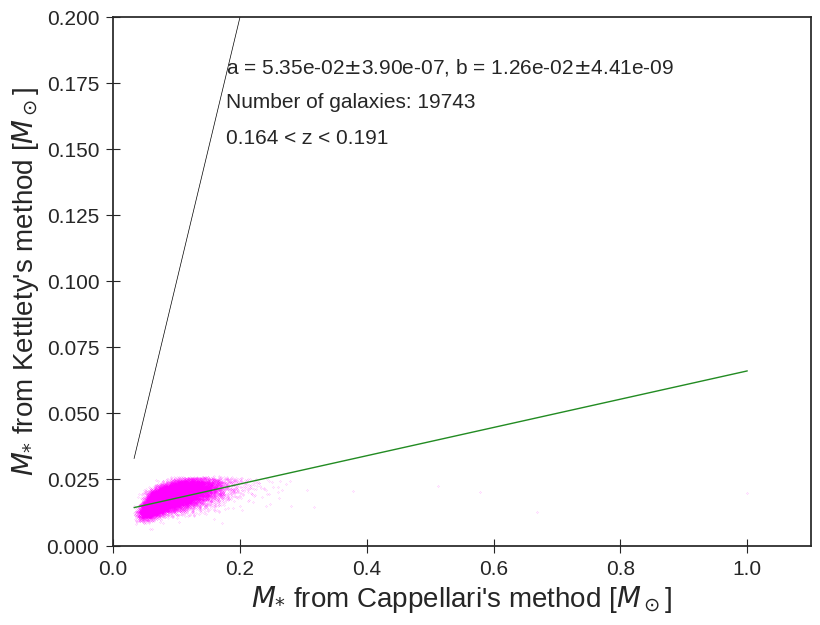

In [80]:
a_list = [] # list for the slopes
b_list = [] # list for the intercepts
da_list = [] # list for the error of slopes
db_list = [] # list for the error of intercepts
max_mass_list = [] # list for the maximum masses

for i in range( 0, len(z_lims)-1 ):
    filt = np.logical_and( sm_filt_sorted.z > z_lims[i], sm_filt_sorted.z < z_lims[i+1] )
    a, b, da, db, max_mass = method_comparison( sm_filt_sorted[filt].SMass_Cappellari, 
                             sm_filt_sorted[filt].SMass_Kettlety,
                             sm_filt_sorted[filt].err_SMass_Cappellari, 
                             sm_filt_sorted[filt].err_SMass_Kettlety, ylim = [ 0, 0.2 ] )
    plt.figtext( 0.25, 0.7,'{:.3}'.format( z_lims[i] ) + ' < z < ' 
                + '{:.3}'.format( z_lims[i+1] ) ) # rounded redshifts
    # saving the fitted parameters:
    a_list.append( a )
    b_list.append( b )
    da_list.append( da )
    db_list.append( db )
    max_mass_list.append( max_mass )

# the results:
print( 'a:\n', a_list )
print( '\nb:\n', b_list )  
print( '\nda:\n', da_list )
print( '\ndb:\n', db_list )
print( '\nmax_mass:\n', max_mass_list )

Fitting in the last bin:

a:
 [0.24158984057937105, 0.08161956703177731, 0.08097319977507185, 0.06149918095907136, 0.06897263174536254, 0.04699366722673191, 0.050132956296739105, 0.05348368283080538, 0.05941408242544853]

b:
 [0.006313384738966587, 0.021555996515501337, 0.021983903300506136, 0.01774310587213683, 0.015732485003098762, 0.010363939423038152, 0.02593501848595814, 0.012606000164263763, 0.013776054090438592]

da:
 [7.726609149028745e-07, 9.937454229135633e-07, 1.0417590535117868e-06, 8.174878115836385e-07, 7.339035744099195e-07, 5.388149973487372e-07, 5.335592899761645e-07, 3.899034902454411e-07, 1.6422186953158316e-07]

db:
 [1.574211063574885e-08, 1.465045936716765e-08, 1.8261016831617304e-08, 8.843042707363306e-09, 7.822781574951103e-09, 2.389403917660245e-09, 1.843709085673646e-08, 4.4104183695816585e-09, 4.85089990717881e-09]

max_mass:
 [223372880180.17307, 987736772380.7708, 1395703842657.6714, 2522002148012.6533, 3377149432443.7656, 7093163378319.193, 3390081099997.425, 8361502452480.923, 915

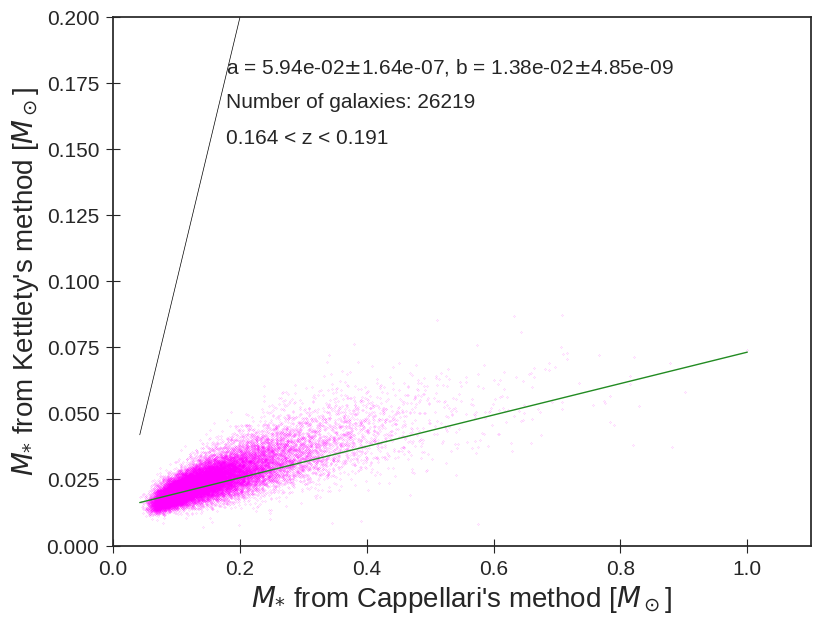

In [81]:
filt = sm_filt_sorted.z > z_lims[-1] 
a, b, da, db, max_mass = method_comparison( sm_filt_sorted[filt].SMass_Cappellari, 
                         sm_filt_sorted[filt].SMass_Kettlety,
                         sm_filt_sorted[filt].err_SMass_Cappellari, 
                         sm_filt_sorted[filt].err_SMass_Kettlety, ylim = [ 0, 0.2 ] )
plt.figtext( 0.25, 0.7,'{:.3}'.format( z_lims[i] ) + ' < z < ' 
            + '{:.3}'.format( z_lims[i+1] ) ) # rounded redshifts
# saving the fitted parameters:
a_list.append( a )
b_list.append( b )
da_list.append( da )
db_list.append( db )
max_mass_list.append( max_mass )

# the results:
print( 'a:\n', a_list )
print( '\nb:\n', b_list )  
print( '\nda:\n', da_list )
print( '\ndb:\n', db_list )
print( '\nmax_mass:\n', max_mass_list )

Filtrating the data (we can calibrate only those stellar masses which are the studied range):

In [82]:
original_len = len(M_Cappellari_frame)
M_Cappellari_frame = M_Cappellari_frame[M_Cappellari_frame.SMass_Cappellari < 1e13 ]
print( 'The loss because of M_* < 1e13:\t', original_len - len(M_Cappellari_frame) )
M_Cappellari_frame = M_Cappellari_frame[M_Cappellari_frame.z < np.max( sm_filt_sorted.z ) ]
print( 'The loss because of too small z:\t', original_len - len(M_Cappellari_frame) )
M_Cappellari_frame = M_Cappellari_frame[M_Cappellari_frame.z > np.min( sm_filt_sorted.z ) ]
print( 'The loss because of too large z:\t', original_len - len(M_Cappellari_frame) )
M_Cappellari_frame = M_Cappellari_frame[np.isnan(M_Cappellari_frame.SMass_Kettlety)]
print( 'Already having Kettlety\'s stellar mass:\t', original_len-len(M_Cappellari_frame) )

The loss because of M_* < 1e13:	 26
The loss because of too small z:	 30
The loss because of too large z:	 7062
Already having Kettlety's stellar mass:	 193426


Where do the galaxies come from?

In [83]:
GWGC_idx = np.argwhere( M_Cappellari_frame.GWGC.values.astype(str) != 'nan' ).flatten()
Hyp_idx = np.argwhere( M_Cappellari_frame.Hyp.values.astype(str) != 'nan' ).flatten()
twoMASS_idx = np.argwhere( M_Cappellari_frame.designation.values.astype(str) != 'nan' ).flatten()

cat_flag_c = np.zeros( len(M_Cappellari_frame), dtype = np.int8 )
cat_flag_c[twoMASS_idx] = 3
cat_flag_c[Hyp_idx] = 2
cat_flag_c[GWGC_idx] = 1

M_Cappellari_frame['cat_flag'] = cat_flag_c
M_Cappellari_frame.head()

wiseX  w1mCorr  w1mCorrErr  fromAllSky     GWGC      Hyp  \
292   NaN      NaN         NaN         NaN  NGC0741  NGC0741   
305   NaN      NaN         NaN         NaN  NGC0777  NGC0777   
309   NaN      NaN         NaN         NaN  NGC0410  NGC0410   
338   NaN      NaN         NaN         NaN  NGC6928  NGC6928   
342   NaN      NaN         NaN         NaN  NGC2256  NGC2256   

          designation type          ra        dec  ...         z     lumdis  \
292  01562095+0537437    G   29.087328   5.628824  ...  0.018130  87.529883   
305  02001493+3125457    G   30.062227  31.429384  ...  0.016524  81.917227   
309  01105887+3309072    G   17.745298  33.152027  ...  0.017291  87.036863   
338  20325022+0955351    G  308.209259   9.926430  ...  0.015664  73.859013   
342  06471396+7414114    G  101.808167  74.236511  ...  0.017146  79.268243   

     lumdis_err  k_m_ext  k_msig_ext  SMass_Kettlety  err_SMass_Kettlety  \
292         NaN    8.295       0.020             NaN                 NaN   
305         NaN    8.366       0.018             NaN                 NaN   
309         NaN    8.380       0.021             NaN                 NaN   
338         NaN    8.739       0.026             NaN                 NaN   
342         NaN    8.670       0.024             NaN                 NaN   

     SMass_Cappellari  err_SMass_Cappellari  cat_flag  
292      1.230020e+12          5.554621e+11         1  
305      9.875823e+11          4.452160e+11         1  
309      1.116668e+12          5.039841e+11         1  
338      5.491029e+11          2.468810e+11         1  
342      6.927762e+11          3.118141e+11         1  

[5 rows x 23 columns]

**Calibrating the stellar masses and calculating their errors:**

In [84]:
M_cal_vals = []
M_cal_errs = []
M_cal_idxs = []
M_cal_relerr = []
sigma_p1_arr = []
sigma_p2_arr = []
sigma_SM_arr = []
for i in range( 0, len(z_lims)-1 ):
    filt = np.logical_and( M_Cappellari_frame.z > z_lims[i], M_Cappellari_frame.z < z_lims[i+1] )
    M_cal = M_Cappellari_frame[filt].SMass_Cappellari*a_list[i] + b_list[i]*max_mass_list[i]
    
    sigma_p1 = (M_Cappellari_frame[filt].SMass_Cappellari*da_list[i])**2
    sigma_p2 = (db_list[i])**2
    sigma_SM = (a_list[i]*M_Cappellari_frame[filt].err_SMass_Cappellari)**2
    err_M_cal = np.sqrt( sigma_p1 + sigma_p2 + sigma_SM )
    
    M_cal_vals.append(M_cal.values)
    M_cal_idxs.append(M_cal.index)
    M_cal_errs.append(err_M_cal)
    M_cal_relerr.append( err_M_cal / M_cal)
    sigma_p1_arr.append( sigma_p1 )
    sigma_p2_arr.append( sigma_p2 )
    sigma_SM_arr.append( sigma_SM )

For the last bin:

In [85]:
filt = M_Cappellari_frame.z > z_lims[-1]
M_cal = M_Cappellari_frame[filt].SMass_Cappellari*a_list[-1] + b_list[i]*max_mass_list[-1]

sigma_p1 = (M_Cappellari_frame[filt].SMass_Cappellari*da_list[-1])**2
sigma_p2 = (db_list[-1])**2
sigma_SM = (a_list[-1]*M_Cappellari_frame[filt].err_SMass_Cappellari)**2

err_M_cal = np.sqrt( sigma_p1 + sigma_p2 + sigma_SM )
M_cal_vals.append(M_cal.values)
M_cal_idxs.append(M_cal.index)
M_cal_errs.append(err_M_cal)
M_cal_relerr.append( err_M_cal / M_cal)
sigma_p1_arr.append( sigma_p1 )
sigma_p2_arr.append( sigma_p2 )
sigma_SM_arr.append( sigma_SM )

Saving the calculated values to the dataframe:

In [86]:
M_calibrated = np.empty( len(data) )
err_M_calibrated = np.empty( len(data) )
rel_err_M_calibrated = np.empty( len(data) )
sigma_p1 = np.empty( len(data) )
sigma_p2 = np.empty( len(data) )
sigma_SM = np.empty( len(data) )
for i in range( len(M_cal_idxs) ):
    np.add.at( M_calibrated, M_cal_idxs[i], M_cal_vals[i] )
    np.add.at( err_M_calibrated, M_cal_idxs[i], M_cal_errs[i] )
    np.add.at( rel_err_M_calibrated, M_cal_idxs[i], M_cal_relerr[i] )
    np.add.at( sigma_p1, M_cal_idxs[i], sigma_p1_arr[i])
    np.add.at( sigma_p2, M_cal_idxs[i], sigma_p2_arr[i])
    np.add.at( sigma_SM, M_cal_idxs[i], sigma_SM_arr[i])
    
data['SMass_calibrated'] = M_calibrated
data['err_SMass_calibrated'] = err_M_calibrated
data['relerr_SMass_calibrated'] = rel_err_M_calibrated
data['sigma_p1'] = sigma_p1
data['sigma_p2'] = sigma_p2
data['sigma_SM'] = sigma_SM

data.SMass_calibrated.replace(0, np.nan, inplace=True)
data.err_SMass_calibrated.replace(0, np.nan, inplace=True)
data.relerr_SMass_calibrated.replace(0, np.nan, inplace=True)
data.sigma_p1.replace(0, np.nan, inplace=True)
data.sigma_p2.replace(0, np.nan, inplace=True)
data.sigma_SM.replace(0, np.nan, inplace=True)

#### Histogram of the relative error of the calibrated stellar masses

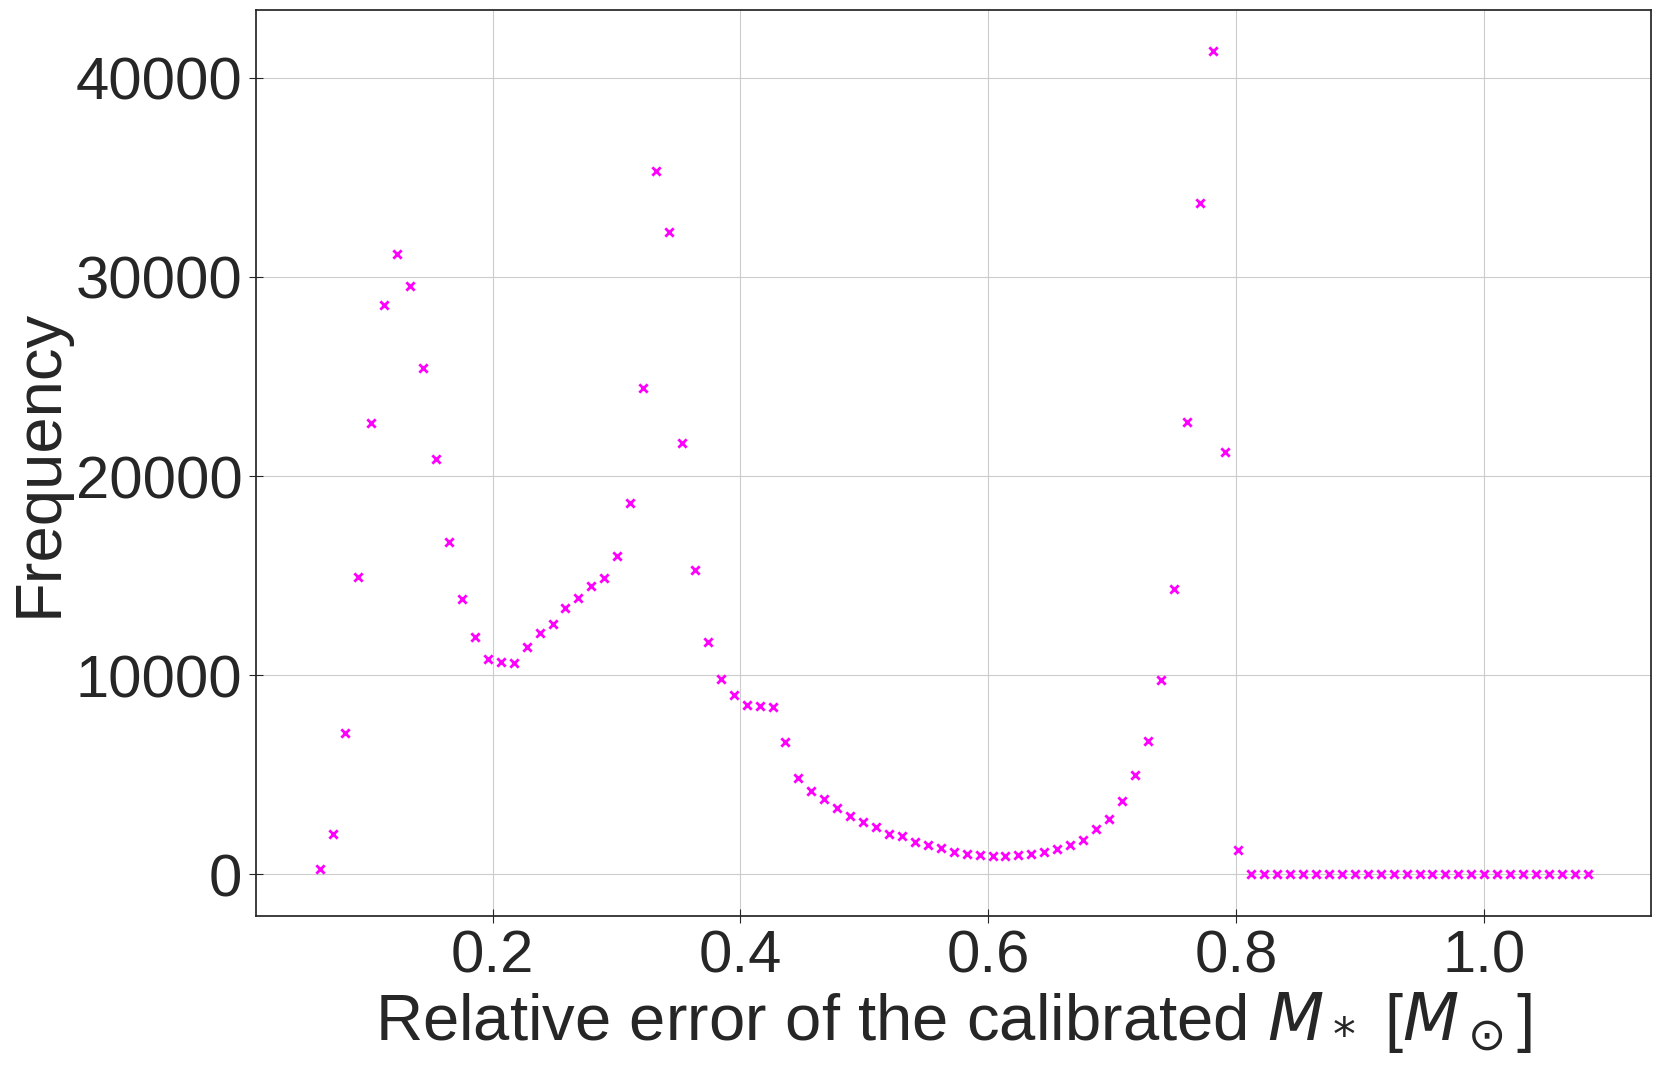

In [87]:
hist_form( 'Relative error of the calibrated $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.relerr_SMass_calibrated
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), bin_num ) )
plt.scatter( bins2[:-1],freq2,  
            marker = 'x', lw = 2, color = 'magenta', label = 'both' )

plt.grid()

Filtrating the calibrated stellar masses:

In [88]:
data_calib = data[~np.isnan(data.err_SMass_calibrated)]
len(data_calib)

785725

### The mean contribution of the terms ($\sigma$-s) to the error

$\mathbf{\sigma_{p1}}$

In [89]:
np.mean( 100*data_calib.sigma_p1/data_calib.err_SMass_calibrated**2 )

3.671308975618539e-08

$\mathbf{\sigma_{p2}}$

In [90]:
np.mean( 100*data_calib.sigma_p2/data_calib.err_SMass_calibrated**2 )

4.647169697007436e-34

$\mathbf{\sigma_{SM}}$

In [91]:
np.mean(100*data_calib.sigma_SM/data_calib.err_SMass_calibrated**2)

99.99999996371126

Minimum:

In [92]:
np.min(100*data_calib.sigma_SM/data_calib.err_SMass_calibrated**2)

99.99999984856154

Maximum:

In [93]:
np.max(100*data_calib.sigma_SM/data_calib.err_SMass_calibrated**2)

99.99999999941852

**The mean and median relative error of the calibrated stellar mass:**

In [94]:
np.mean(data_calib.relerr_SMass_calibrated)

0.37395953447633845

In [95]:
np.median(data_calib.relerr_SMass_calibrated)

0.32552162717579836

### The column of the final  stellar mass, its error, and the method flag

In [96]:
# The stellar mass estimation method flag:
SMass_flag = np.zeros(len(data),  dtype = np.int8 ) # 0 = no stellar mass, 1 = Kettlety, 2 = calibrated
np.add.at( SMass_flag, data[~np.isnan(data.SMass_Kettlety)].index, 1)
np.add.at( SMass_flag, data[~np.isnan(data.SMass_calibrated)].index, 2 )

# The stellar mass:
SMass = np.zeros(len(data))
np.add.at( SMass, data[~np.isnan(data.SMass_Kettlety)].index, 
          data[~np.isnan(data.SMass_Kettlety)].SMass_Kettlety )
np.add.at( SMass, data[~np.isnan(data.SMass_calibrated)].index, 
          data[~np.isnan(data.SMass_calibrated)].SMass_calibrated )

# The error of the stellar:
err_SMass = np.zeros(len(data)) 
np.add.at( err_SMass, data[~np.isnan(data.SMass_Kettlety)].index,
          data[~np.isnan(data.SMass_Kettlety)].err_SMass_Kettlety)
np.add.at( err_SMass, data[~np.isnan(data.SMass_calibrated)].index,
          data[~np.isnan(data.SMass_calibrated)].err_SMass_calibrated )

# writing the stellar mass data to the dataframe:
data['SMass'] = SMass
data['err_SMass'] = err_SMass
data['SMass_flag'] = SMass_flag

# replacing 0-s by NaNs:
data.SMass.replace(0, np.nan, inplace=True)
data.err_SMass.replace(0, np.nan, inplace=True)

### More histograms:

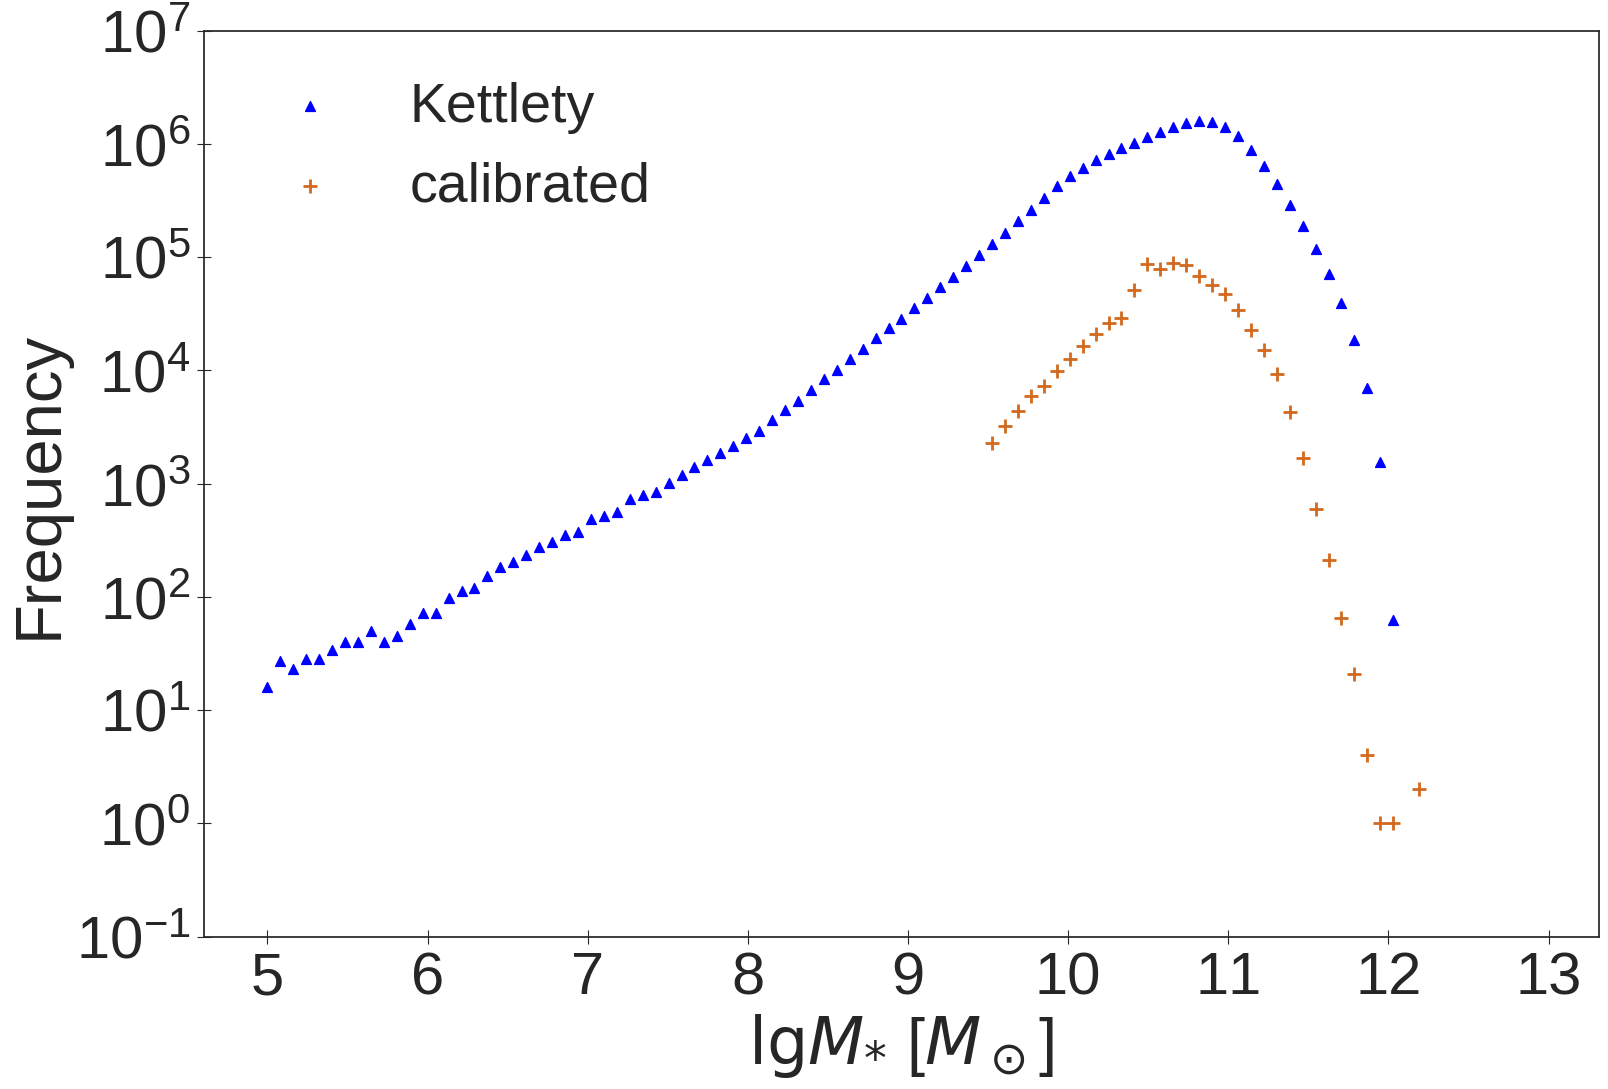

In [97]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_Kettlety), bins=np.linspace(5, 13, 100) )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue',
            label = 'Kettlety' ) 

freq, bins = np.histogram( np.log10(data.SMass_calibrated), bins=np.linspace(5, 13, 100) )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 100, color = 'chocolate', 
            label = 'calibrated' )

plt.legend( fontsize = 40, loc = 'upper left' ) # set legend

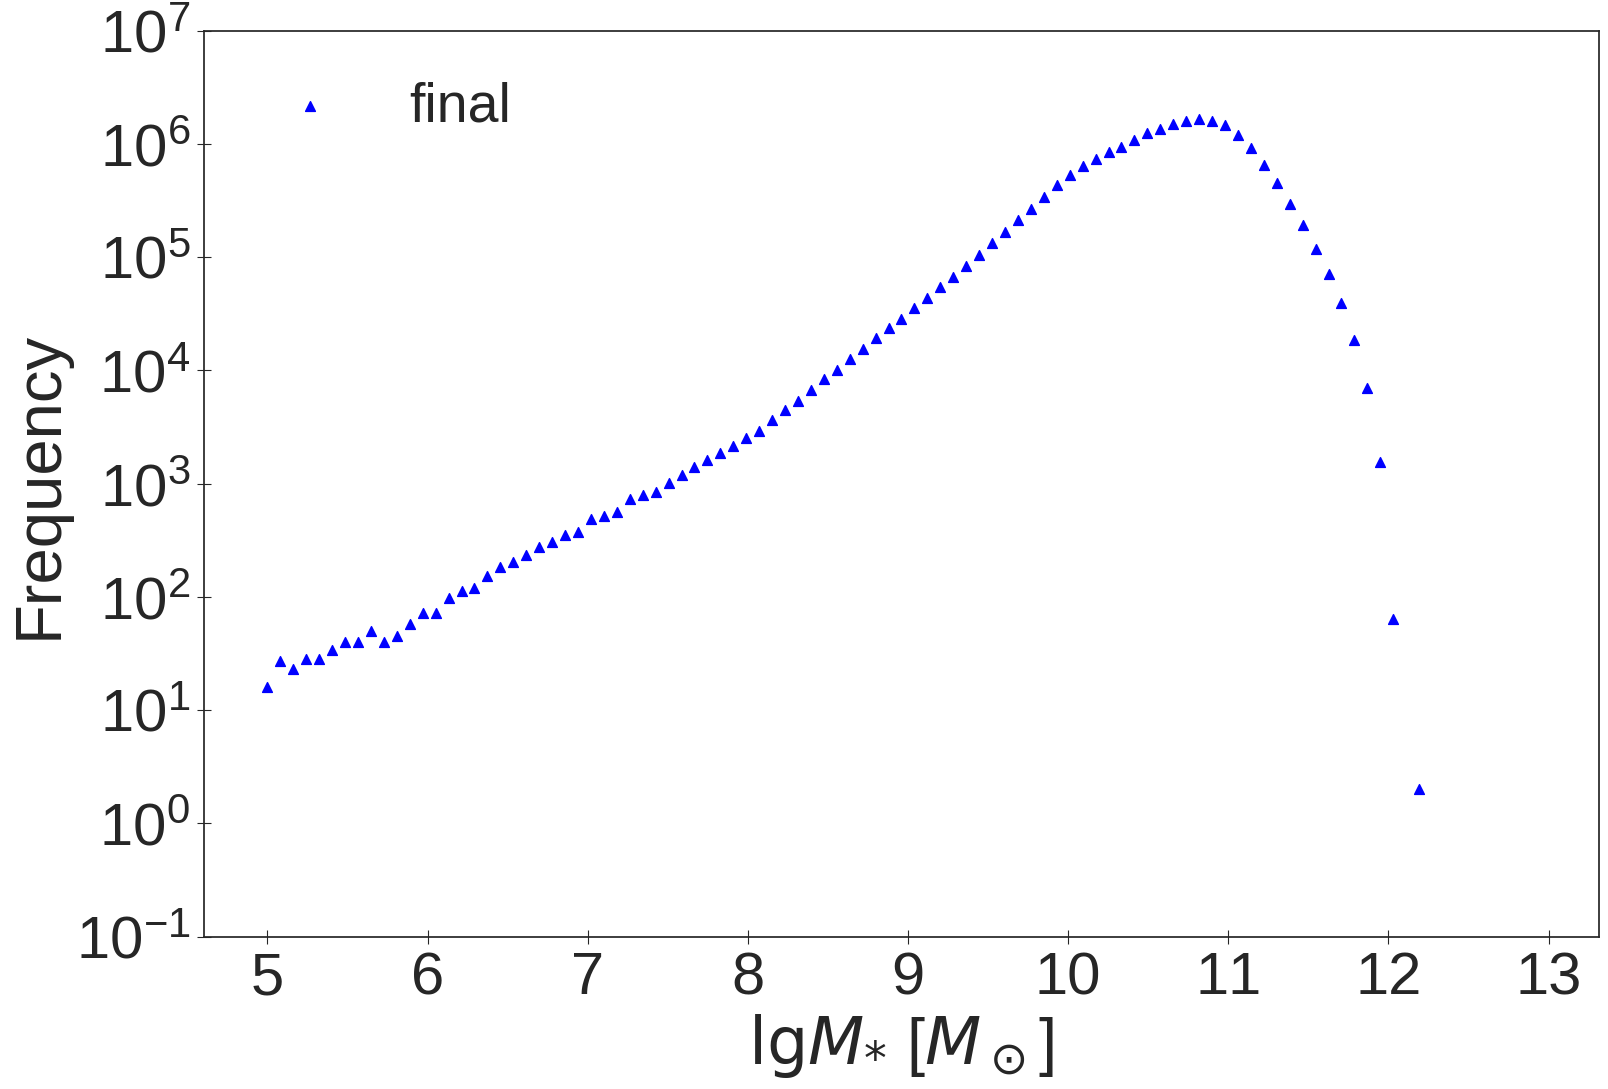

In [98]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass), bins=np.linspace(5, 13, 100) )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue',
            label = 'final' ) 

plt.legend( fontsize = 40, loc = 'upper left' ) # set legend

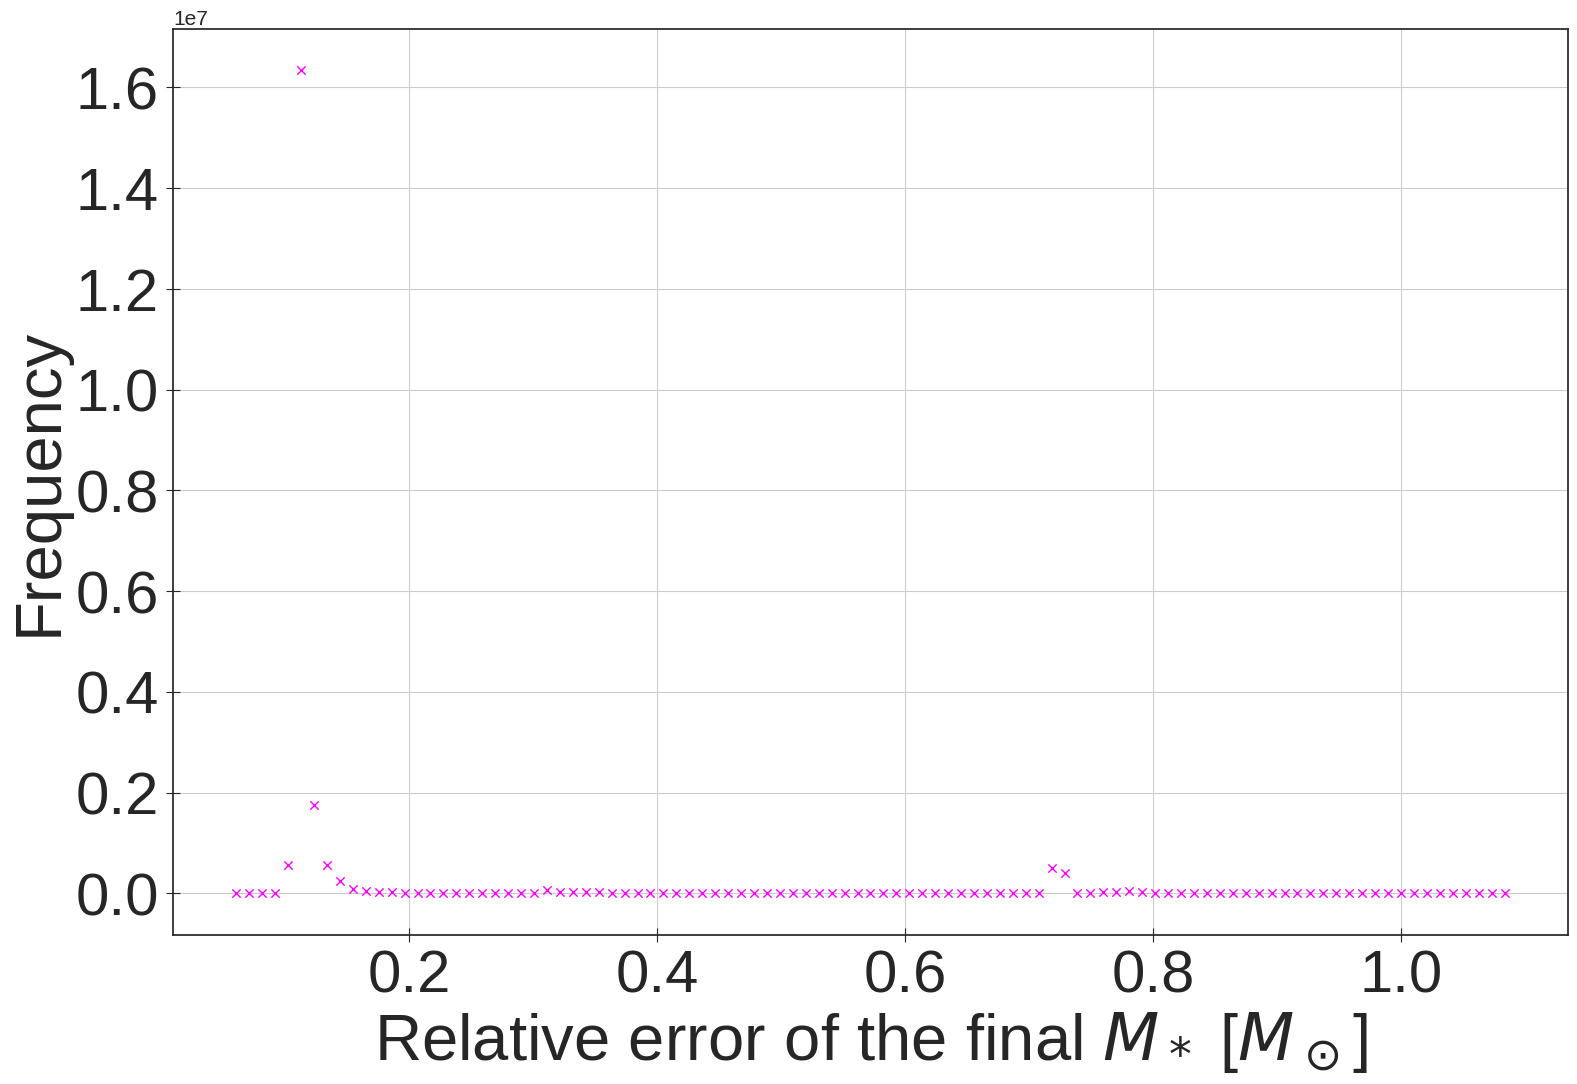

In [99]:
hist_form( 'Relative error of the final $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.err_SMass/data.SMass
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), bin_num ) )
plt.scatter( bins2[:-1],freq2,  
            marker = 'x', lw = 1, color = 'magenta', label = 'final' )

plt.grid()
#plt.legend( fontsize = 35 )

Filtrating the galaxies having 'final' stellar mass:

In [100]:
data_finalmass = data[~np.isnan(data.SMass)]

Number of galaxies with 'final' stellar mass:

In [102]:
len(data_finalmass)

21196020

The mean of the relative error of the 'final' stellar mass:

In [104]:
np.mean(data_finalmass.err_SMass/data_finalmass.SMass)

0.15403369767379937

The mean of the relative error of the 'final' stellar mass:

In [105]:
np.median(data_finalmass.err_SMass/data_finalmass.SMass)

0.1159408648907094

### Rounding the stellar masses

First we rounded the error of stellar masses, then according to this we rounded the values of stellar masses.

In [106]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

# finding the order of the errors:
order_of_err = np.array([ orderOfMagnitude(i) for i in data_finalmass.err_SMass.values ])

# rounding
vals = np.array( [ np.round( data_finalmass.SMass.values[i] / 10**order_of_err[i], 0 ) 
                  for i in range(data_finalmass.shape[0]) ] )
errs = np.array( [ np.round( data_finalmass.err_SMass.values[i] / 10**order_of_err[i], 0 )
                  for i in range(data_finalmass.shape[0]) ] )


# writing the results into the dataframe:
SMass_round = np.zeros( data.shape[0] )
np.add.at( SMass_round, data_finalmass.index, vals*10**order_of_err )

err_SMass_round = np.zeros( data.shape[0] )
np.add.at( err_SMass_round, data_finalmass.index, errs*10**order_of_err )

data['SMass_round'] = SMass_round
data['err_SMass_round'] = err_SMass_round

data.SMass_round.replace(0, np.nan, inplace=True)
data.err_SMass_round.replace(0, np.nan, inplace=True)

In [107]:
data[~np.isnan(data.SMass)]

wiseX  w1mCorr  w1mCorrErr  fromAllSky     GWGC  \
292                       NaN      NaN         NaN         NaN  NGC0741   
305                       NaN      NaN         NaN         NaN  NGC0777   
309                       NaN      NaN         NaN         NaN  NGC0410   
338                       NaN      NaN         NaN         NaN  NGC6928   
342                       NaN      NaN         NaN         NaN  NGC2256   
...                       ...      ...         ...         ...      ...   
23181753  J235402.73+201302.6   14.902       0.034         0.0      NaN   
23181754  J235200.81+201806.7   14.153       0.029         0.0      NaN   
23181755  J235232.36+201806.2   14.678       0.033         0.0      NaN   
23181756  J235039.58+201425.6   14.686       0.032         0.0      NaN   
23181757  J235037.73+201957.3   15.094       0.037         0.0      NaN   

                              Hyp       designation type          ra  \
292                       NGC0741  01562095+0537437    G   29.087328   
305                       NGC0777  02001493+3125457    G   30.062227   
309                       NGC0410  01105887+3309072    G   17.745298   
338                       NGC6928  20325022+0955351    G  308.209259   
342                       NGC2256  06471396+7414114    G  101.808167   
...                           ...               ...  ...         ...   
23181753  SDSSJ235402.72+201302.6               NaN    G  358.511000   
23181754  SDSSJ235200.81+201806.7               NaN    G  358.003000   
23181755  SDSSJ235232.35+201806.5               NaN    G  358.135000   
23181756  SDSSJ235039.56+201426.0               NaN    G  357.665000   
23181757  SDSSJ235037.73+201957.3               NaN    G  357.657000   

                dec  ...  err_SMass_calibrated  relerr_SMass_calibrated  \
292        5.628824  ...          1.341940e+11                 0.449455   
305       31.429384  ...          1.075597e+11                 0.448165   
309       33.152027  ...          1.217574e+11                 0.448981   
338        9.926430  ...          5.964394e+10                 0.444879   
342       74.236511  ...          7.533112e+10                 0.446333   
...             ...  ...                   ...                      ...   
23181753  20.217400  ...                   NaN                      NaN   
23181754  20.301880  ...                   NaN                      NaN   
23181755  20.301830  ...                   NaN                      NaN   
23181756  20.240560  ...                   NaN                      NaN   
23181757  20.332600  ...                   NaN                      NaN   

              sigma_p1      sigma_p2      sigma_SM         SMass  \
292       9.032378e+11  2.478140e-16  1.800803e+22  2.985705e+11   
305       5.822700e+11  2.478140e-16  1.156908e+22  2.400001e+11   
309       7.444340e+11  2.478140e-16  1.482487e+22  2.711859e+11   
338       1.800053e+11  2.478140e-16  3.557400e+21  1.340679e+11   
342       2.865258e+11  2.478140e-16  5.674777e+21  1.687779e+11   
...                ...           ...           ...           ...   
23181753           NaN           NaN           NaN  1.794782e+11   
23181754           NaN           NaN           NaN  1.716854e+11   
23181755           NaN           NaN           NaN  1.066267e+11   
23181756           NaN           NaN           NaN  2.769915e+11   
23181757           NaN           NaN           NaN  2.256694e+11   

             err_SMass  SMass_flag   SMass_round  err_SMass_round  
292       1.341940e+11           2  3.000000e+11     1.000000e+11  
305       1.075597e+11           2  2.000000e+11     1.000000e+11  
309       1.217574e+11           2  3.000000e+11     1.000000e+11  
338       5.964394e+10           2  1.300000e+11     6.000000e+10  
342       7.533112e+10           2  1.700000e+11     8.000000e+10  
...                ...         ...           ...              ...  
23181753  1.308541e+11           1  2.000000e+11     1.000000e+1

### The final form of the stellar mass:

The unit of stellar masses will be $10^{10} ~ M_\odot$.

In [120]:
data['SMass_final'] = data.SMass_round/1e10
data['err_SMass_final'] = data.err_SMass_round/1e10

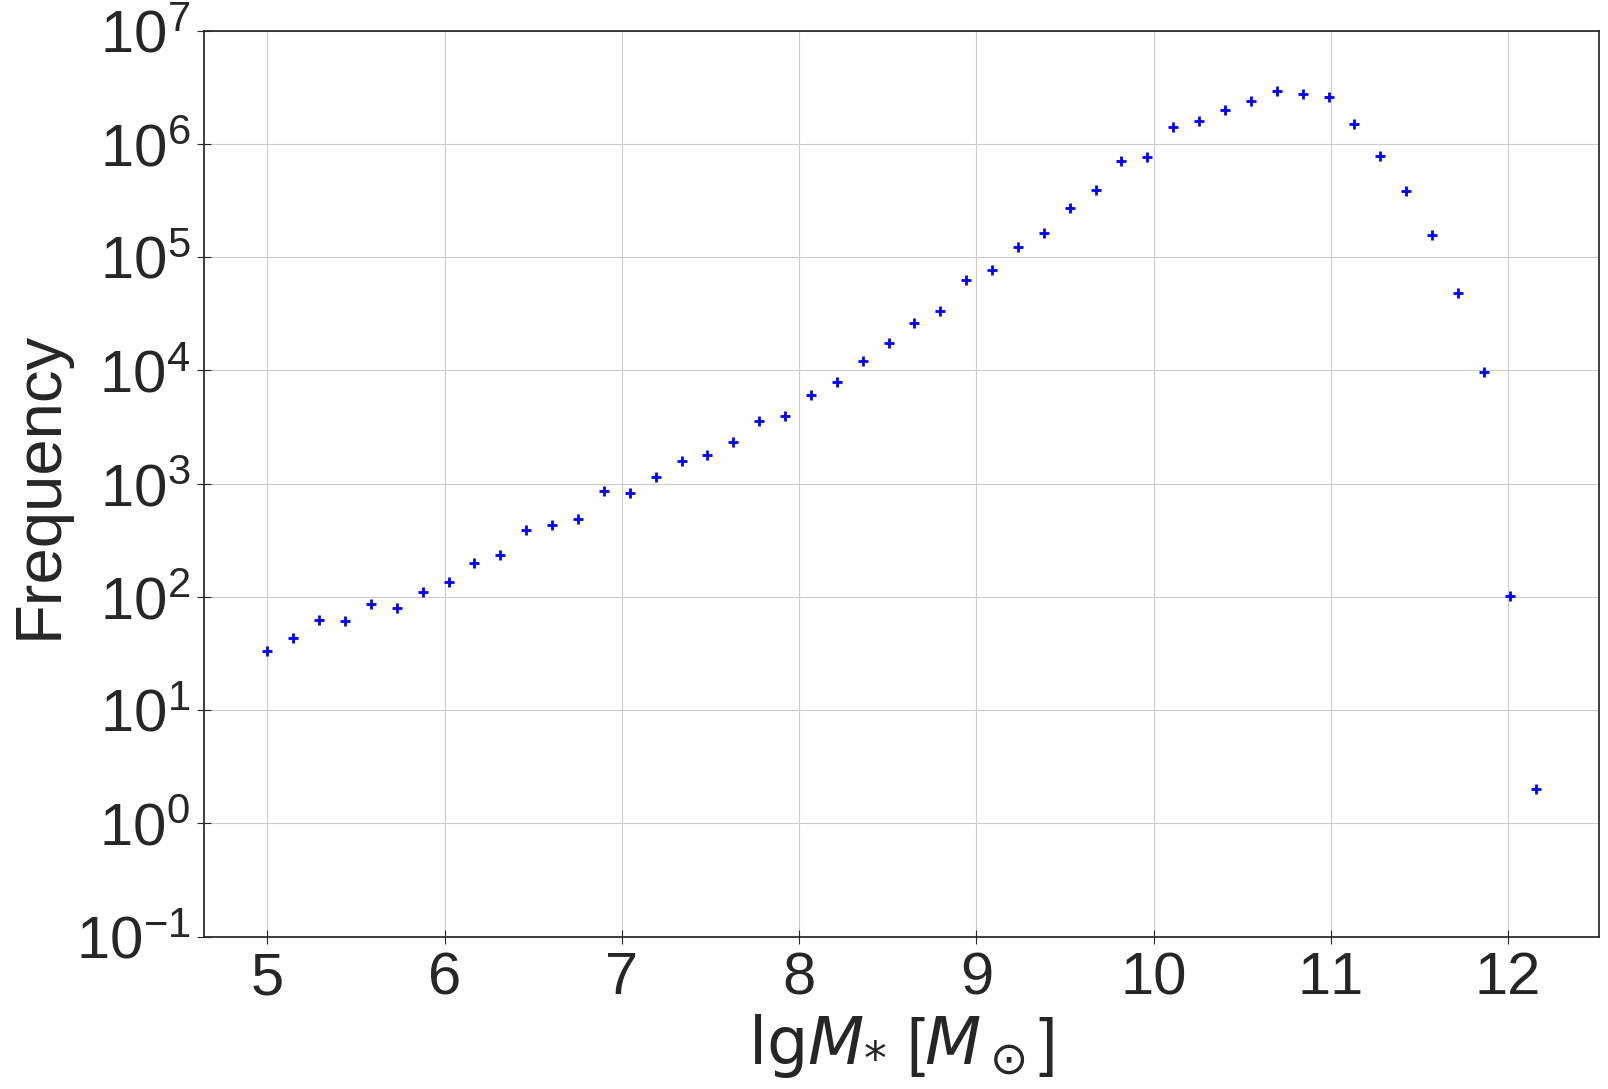

In [122]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=50 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 50, color = 'blue' ) 
plt.grid()
plt.savefig( 'sm_hist.eps', format = 'eps' ) #save the figure

The effect of the rounding:

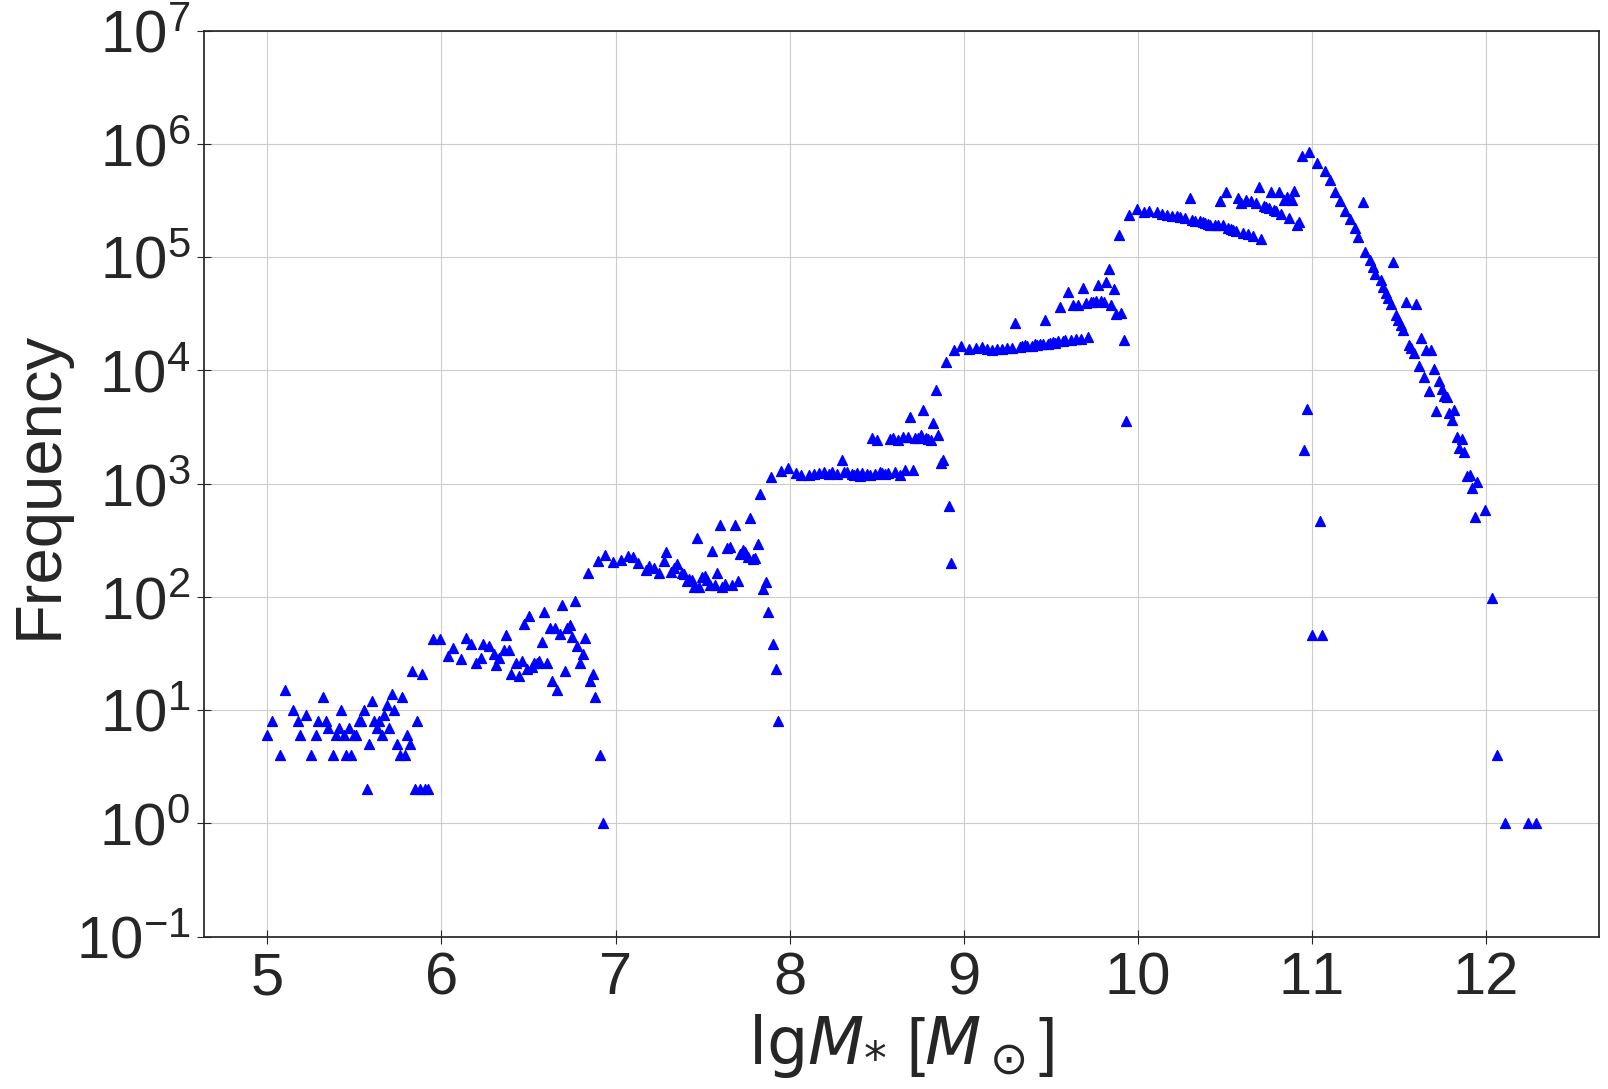

In [127]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=500 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

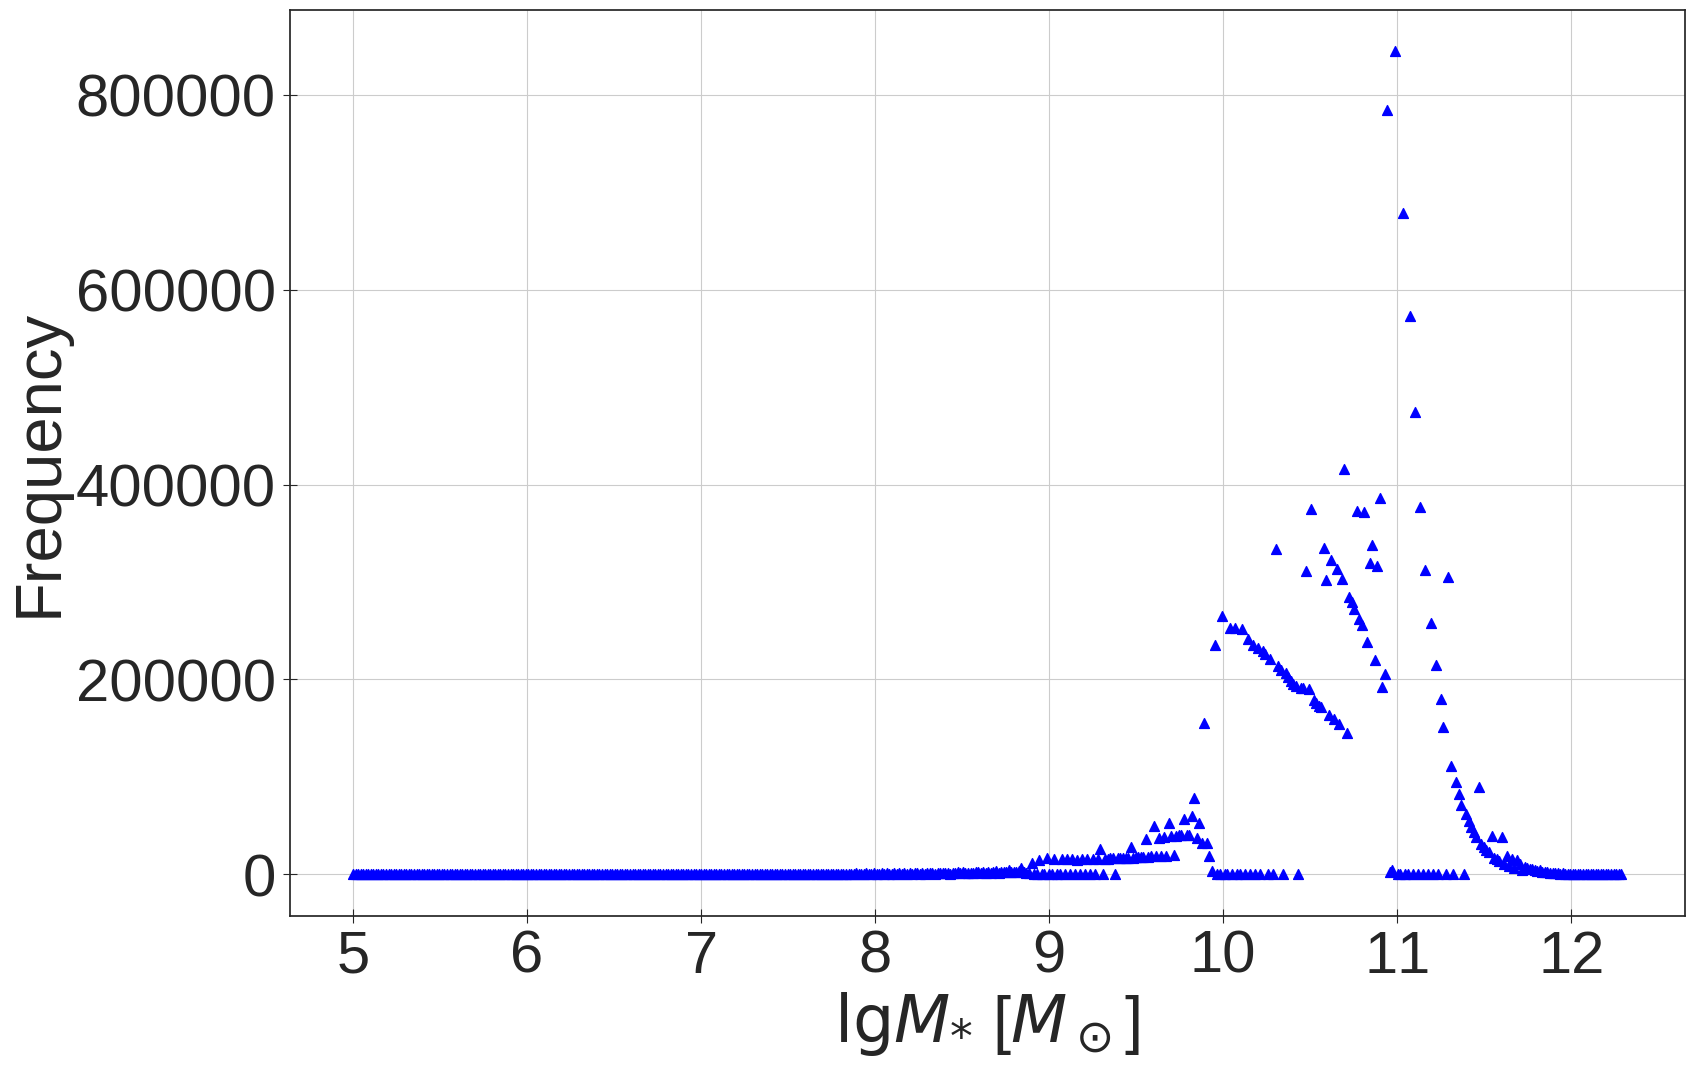

In [139]:
# form the figure:
hist_form()
plt.yscale( 'linear' )
plt.autoscale()

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=500 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

Histogram of the relative error:

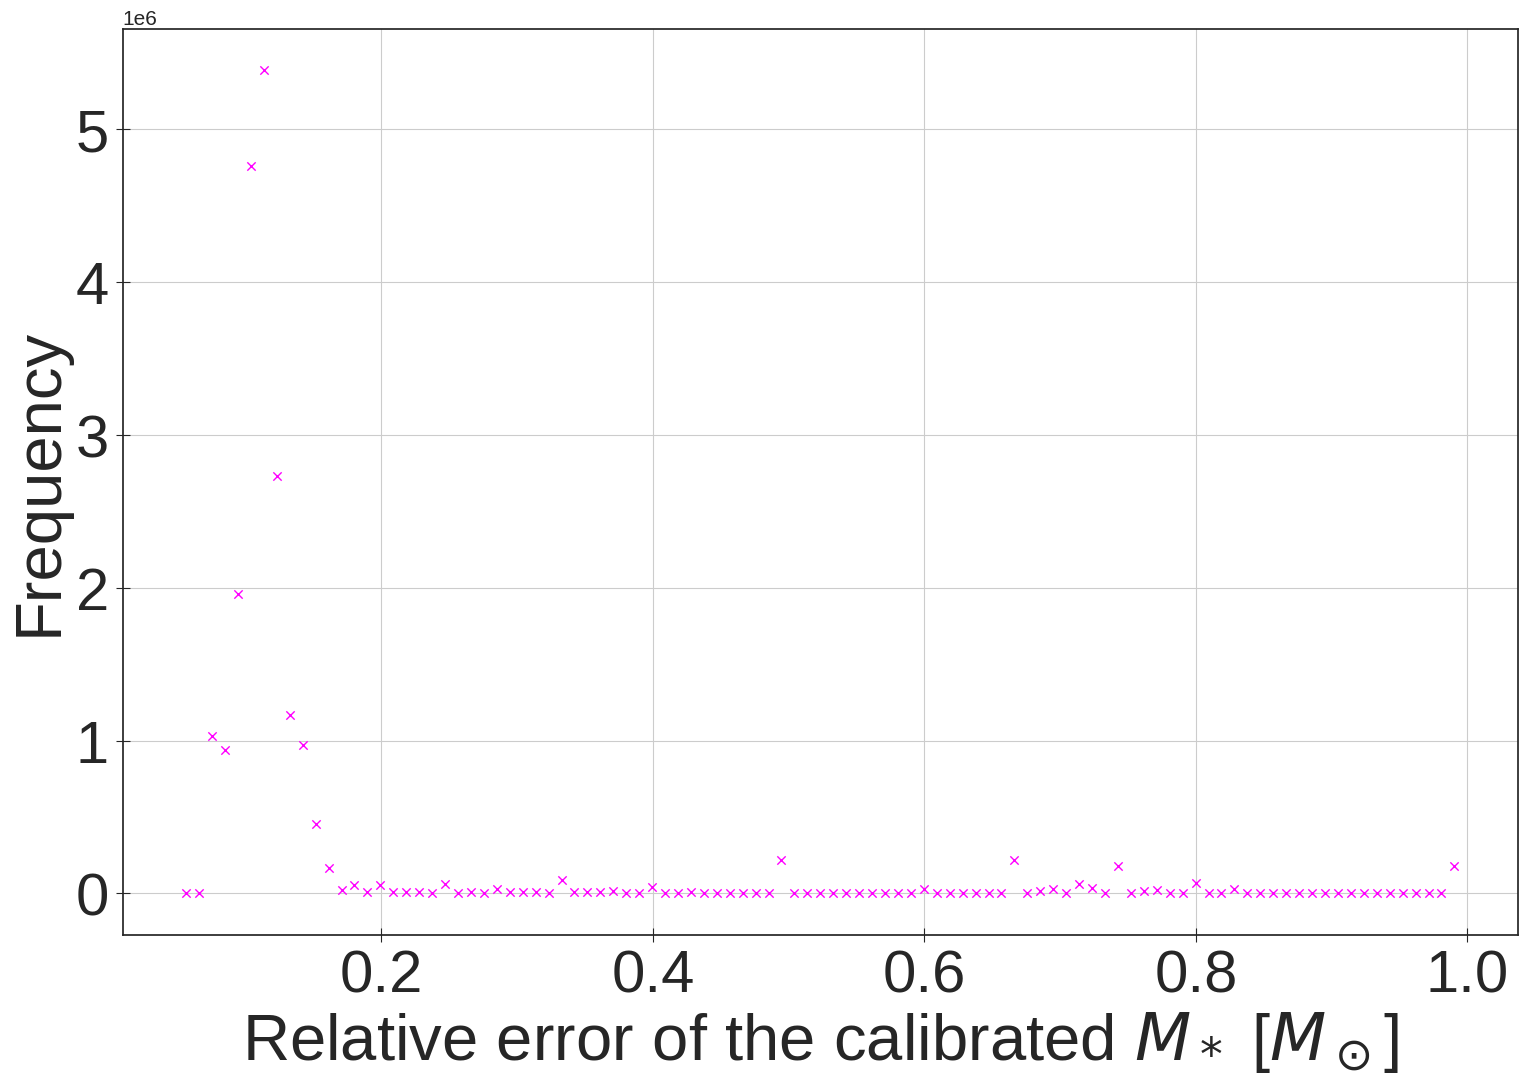

In [138]:
hist_form( 'Relative error of the calibrated $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.err_SMass_final/data.SMass_final
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), bin_num ) )
plt.scatter( bins2[:-1],freq2, marker = 'x', lw = 1, color = 'magenta' )

plt.grid()

## Merger rates:

In the following section I give the merger rates of galaxies in three different scenario: the event of 2 black holes (DBH), two neutron stars (DNS) and a black hole and a neutron star (BHNS).

I use the results of Artale et al. MNRAS 487, 1675–1688 (2019)
 (Host galaxies of merging compact objects: mass, star
formation rate, metallicity and colours):

DNS: $$ \lg(n_{GW}/\text{Gyr}) = ( 1.15 \pm 0.08 ) \lg(M_*[M_{Sun}]) - ( 7.22 \pm 0.22 ), $$

DBH: $$ \lg(n_{GW}/\text{Gyr}) = ( 0.80 \pm 0.07 ) \lg(M_*[M_{Sun}]) - ( 4.14 \pm 0.19 ), $$

BHNS: $$ \lg(n_{GW}/\text{Gyr}) = ( 0.87 \pm 0.08 ) \lg(M_*[M_{Sun}]) - ( 4.99 \pm 0.22 ). $$

They studied the galaxies having stellar mass $M_* > 10^7 ~ M_\odot$ in the local universe $ z \leq 1$.

In [109]:
# find the data whose merger rate can be calculated:
print( 'We need the galaxies which have stellar masses larger than 10^7 and z <= 0.1' )
print('Shape before filtrations:', data.shape)
data_merger =  copy.deepcopy( data[ data.SMass > 10**7 ] )
print( 'Shape with stellar mass > 1e7:', data_merger.shape )
data_merger =  data_merger[ data_merger.SMass < 10**13 ] 
print( 'Shape with stellar mass < 1e13:', data_merger.shape )
data_merger = data_merger[ ~np.isnan(data_merger.z) ]  
print('Shape with known redshift:', data_merger.shape)
data_merger = data_merger[ data_merger.z <= 0.1 ]
print('Shape after redshift filtration:', data_merger.shape)
print( 'The shape of dataframe to which we can associate merger rates:' )
print( data_merger.shape )

# merger rate of BNS:
dns = 1.15 * np.log10( data_merger.SMass ) - 7.22
# error of merger rate of BNS:
err_dns = np.sqrt( ( np.log10(data_merger.SMass)*0.08 )**2 + 
                   ( 1.15*data_merger.err_SMass/(data_merger.SMass*np.log(10)) )**2 +
                   0.22**2 )

We need the galaxies which have stellar masses larger than 10^7 and z <= 0.1
Shape before filtrations: (23181758, 33)
Shape with stellar mass > 1e7: (21193129, 33)
Shape with stellar mass < 1e13: (21193129, 33)
Shape with known redshift: (21193129, 33)
Shape after redshift filtration: (3083920, 33)
The shape of dataframe to which we can associate merger rates:
(3083920, 33)


In [110]:
dns[:5], err_dns[:5]

(292    5.976304
 305    5.867243
 309    5.928257
 338    5.576424
 342    5.691413
 Name: SMass, dtype: float64,
 292    0.970320
 305    0.962995
 309    0.967103
 338    0.943504
 342    0.951225
 dtype: float64)

Writing to the dataframe:

In [111]:
data['bns_rate'] = dns
data['err_dns_rate'] = err_dns

### Histograms of the merger rate (and comparision with the stellar mass):

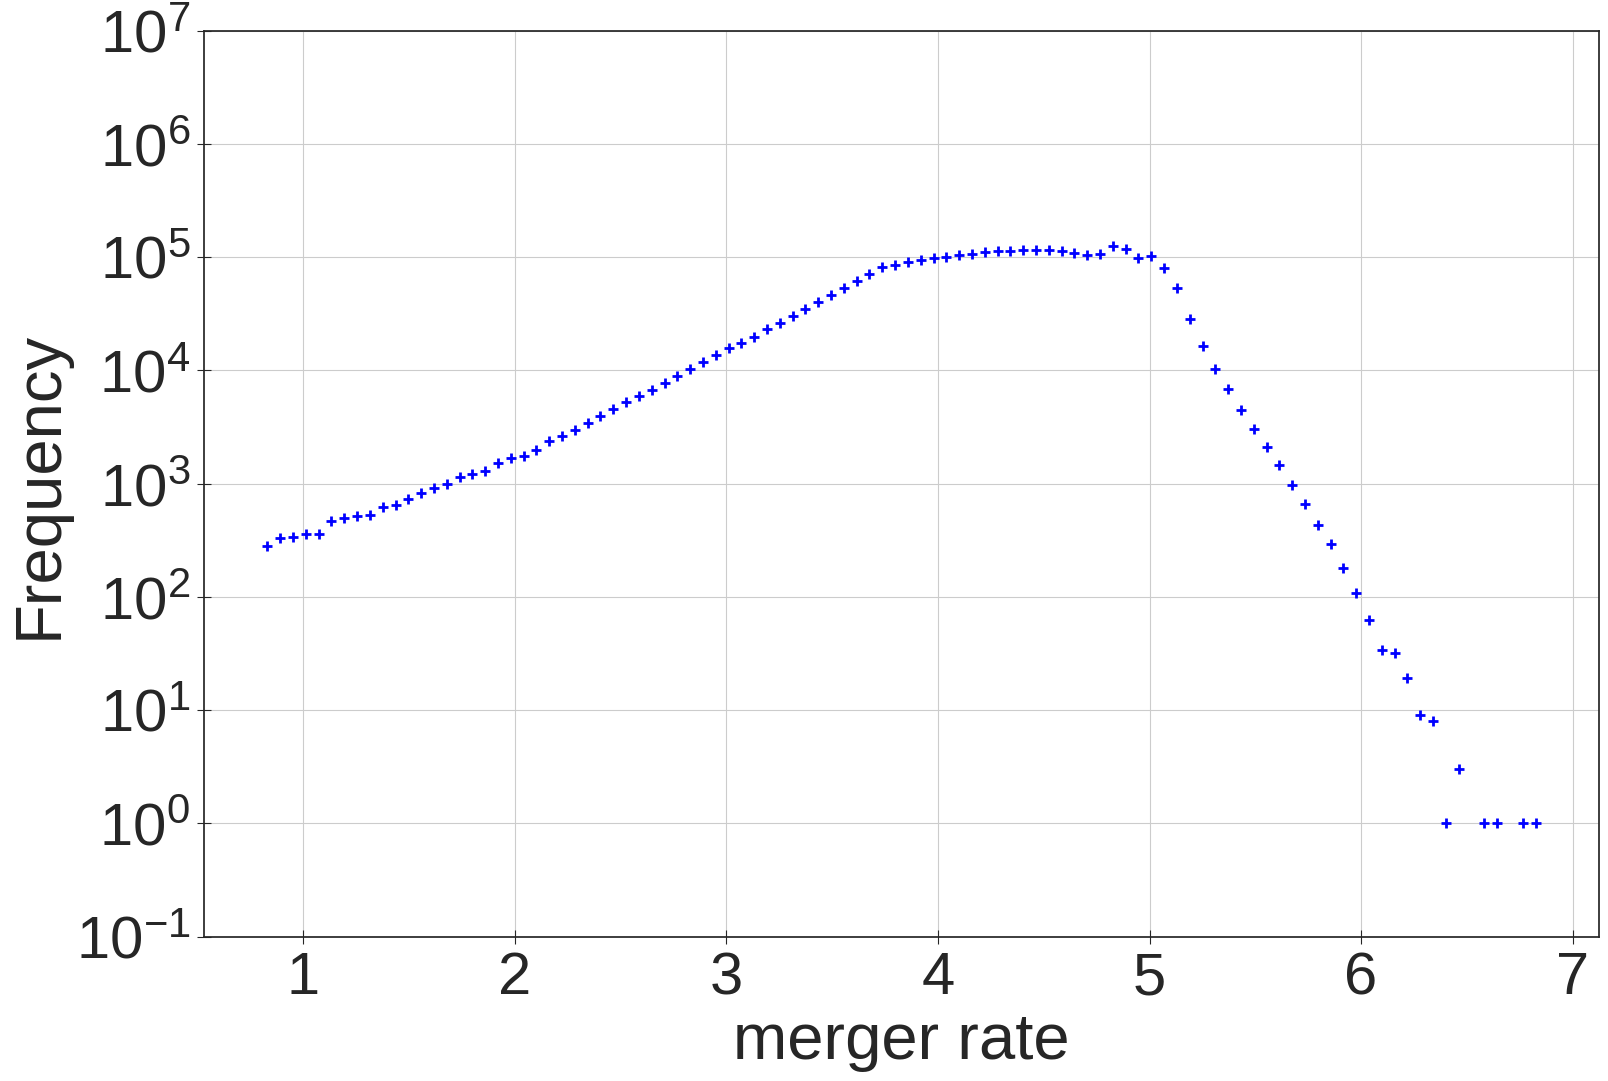

In [114]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)
plt.xlabel('merger rate')

# make and plot histograms:
freq, bins = np.histogram( dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 50, color = 'blue' ) 

plt.grid()

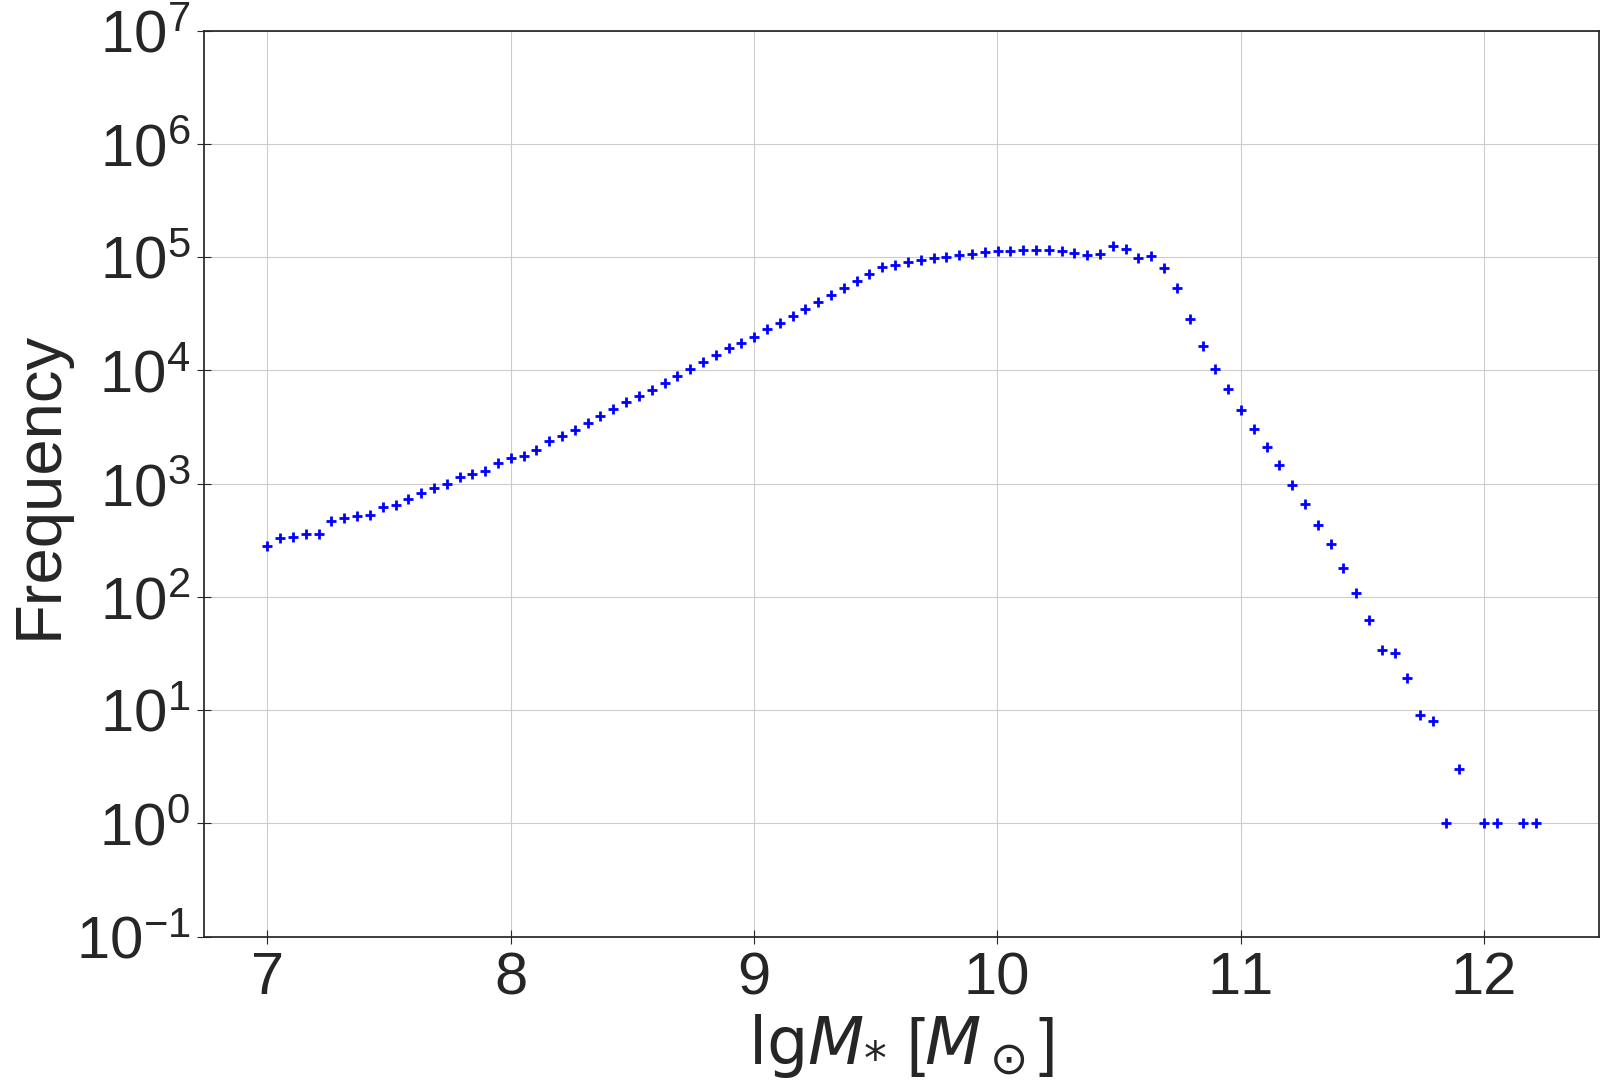

In [112]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data_merger.SMass), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 50, color = 'blue' ) 

plt.grid()

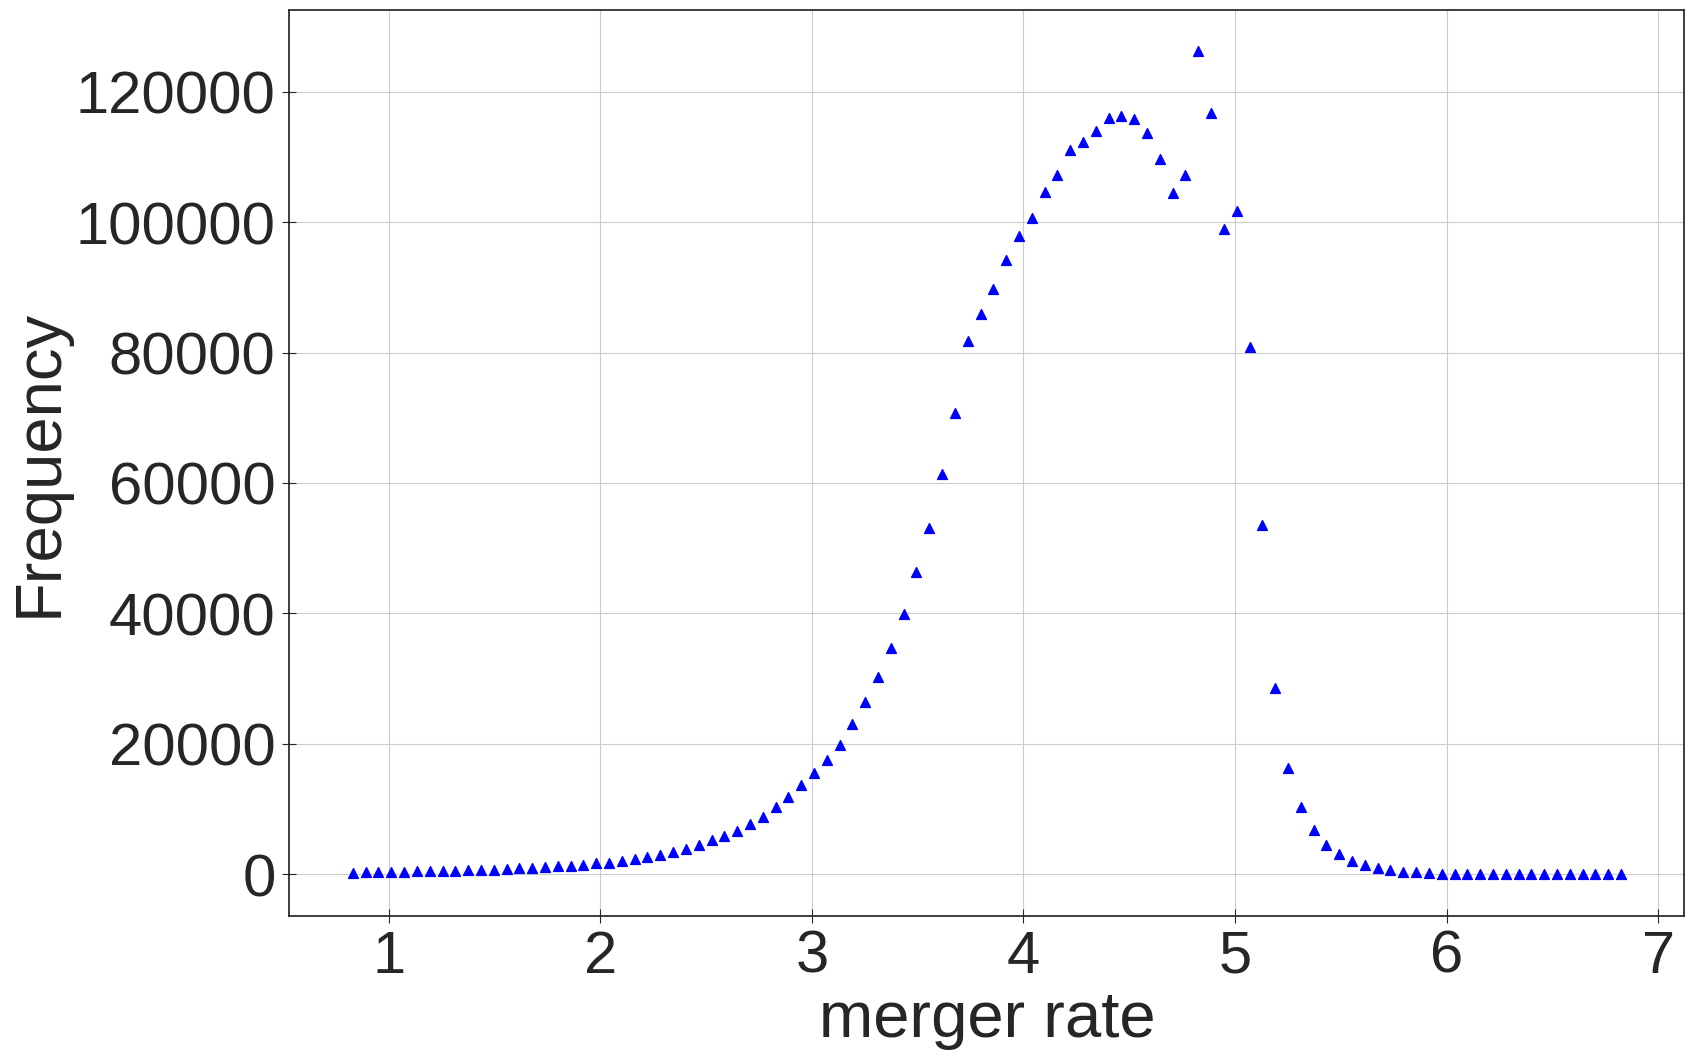

In [116]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()
plt.xlabel('merger rate')

# make and plot histograms:
freq, bins = np.histogram( dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

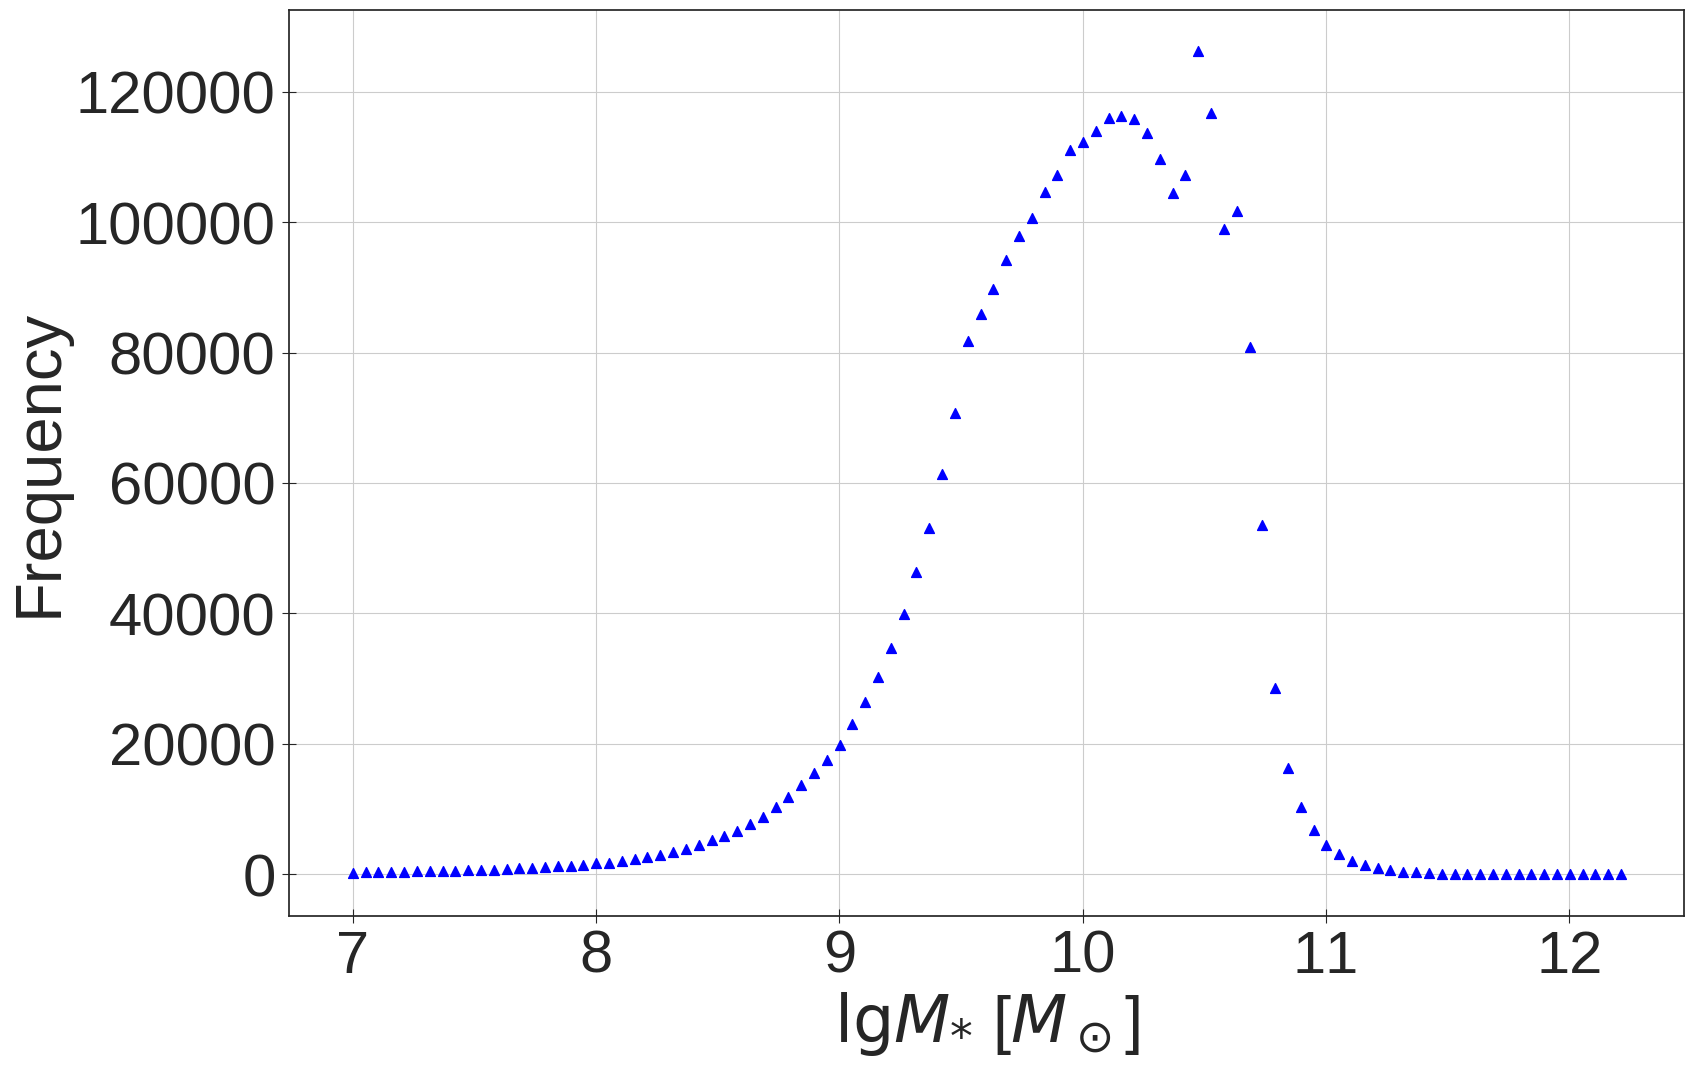

In [117]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()

# make and plot histograms:
freq, bins = np.histogram( np.log10(data_merger.SMass), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

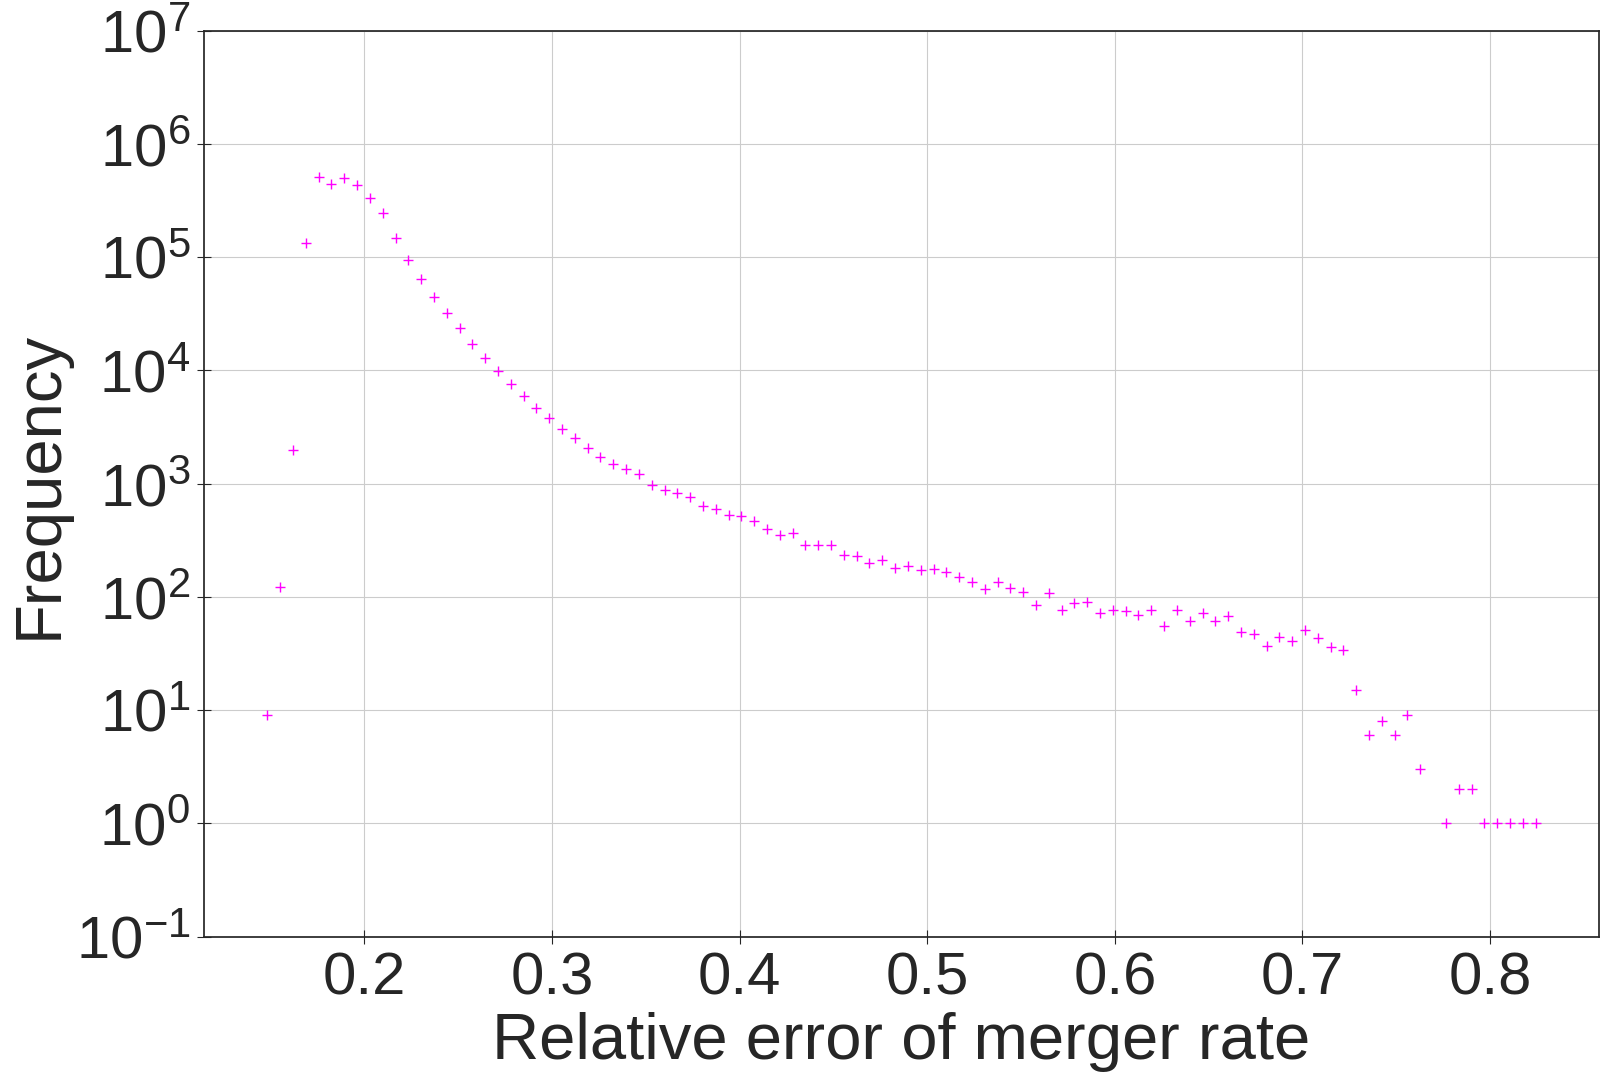

In [118]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)
plt.xlabel('Relative error of merger rate')

# make and plot histograms:
freq, bins = np.histogram( err_dns/dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'magenta' ) 

plt.grid()

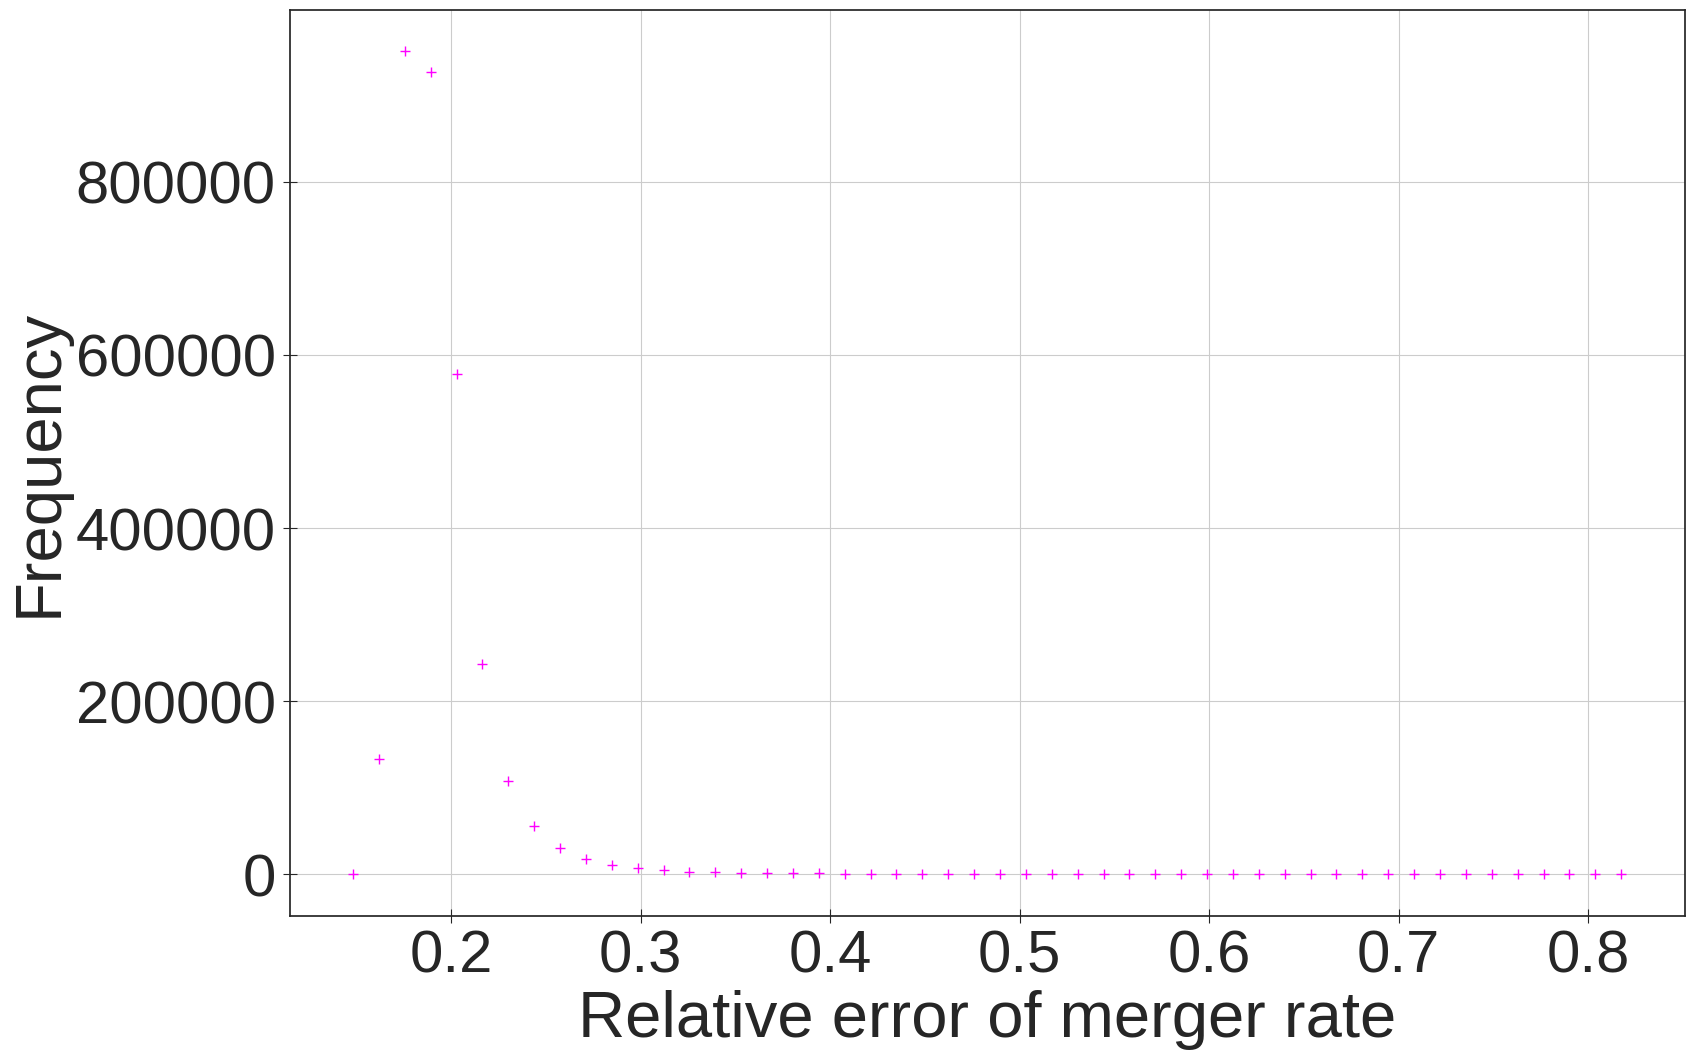

In [119]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()
plt.xlabel('Relative error of merger rate')


# make and plot histograms:
freq, bins = np.histogram( err_dns/dns, bins=50 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'magenta' ) 

plt.grid()

### Writing data to csv:

In [141]:
data.to_csv( 'original_columns.txt',
            columns = [ 'SMass', 'err_SMass', 
                       'bns_rate', 'err_dns_rate', 'SMass_flag'],
            header=False, index=False )

Rounding the merger rate:

In [145]:
data['bns_rate_rounded'] = np.round(data.bns_rate, 1)
data['err_bns_rate_rounded'] = np.round(data.err_dns_rate, 1)

In [148]:
data.to_csv( 'to_GLADE_columns.txt',
            columns = [ 'SMass_final', 'err_SMass_final', 
                       'bns_rate_rounded', 'err_bns_rate_rounded', 'SMass_flag'],
            header=False, index=False )

---

**Note**. Why should we divide the stellar masses with the maximum, when we do the calibration? The values are very big number, therefore the fitting method does not work:

In [225]:
def method_comparison_o( first, second, first_err, second_err, size = 0.01, errors = False, ylim = [0,0.05]):
    # form the figure:
    fig = plt.figure( figsize = (9, 7), dpi = 100 )
    plt.xlabel( '$M_{*}$ from Cappellari\'s method [$M_\odot$]', fontsize = 20 )
    plt.ylabel( '$M_{*}$ from Kettlety\'s method [$M_\odot$]', fontsize = 20 )
    plt.xlim( [0,0.2e13] )
    plt.ylim( ylim )
    plt.xticks( fontsize = 15 )
    plt.yticks( fontsize = 15 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )
    
    # plot the data:
    plt.scatter( first, second, s = size, c = 'magenta' )
    
    
    # fit:
    plt.rcParams['agg.path.chunksize'] = 10000
    popt, pcov = curve_fit( linfit, first, second, p0 = [10, 10],
                           sigma = second_err )
    plt.rcParams["font.size"] = 15
    plt.figtext( 0.25, 0.8, 'a = '+ '{:.2e}'.format( popt[0] ) + '$\pm$' + '{:.2e}'.format( pcov[0,0] ) +
                ', b = '+ '{:.2e}'.format( popt[1] ) + '$\pm$'+'{:.2e}'.format( pcov[1,1] )  )
    
    # prepare confidence level curves
    perr = np.array( [ pcov[0,0], pcov[1,1] ] )
    nstd = 5. # to draw 5-sigma intervals
    popt_up = popt + nstd * perr
    popt_dw = popt - nstd * perr

    x_fit = np.linspace(min(first), max(first), 100)
    fit = func(popt, x_fit)
    fit_up = func(popt_up, x_fit)
    fit_dw= func(popt_dw, x_fit)
    #print(fit_dw, fit_up)
    #print(x_fit)
    
    #plot
    if errors == True:
        plt.errorbar(first, second, 
                     yerr=second_err, xerr=first_err, 
                     hold=True, ecolor='gray', fmt='none' )
    plt.plot(x_fit, fit, 'forestgreen', lw=1, label='best fit curve')
    plt.fill_between(x_fit, fit_up, fit_dw, alpha=.25, label='5-sigma interval')
    
    # draw a 45 degree straight line:
    xval = np.linspace( min(first), max(first), len(first) )
    plt.plot( xval, xval, c ='black', lw = 0.5)

    # print the number of stellar masses:
    plt.figtext( 0.25, 0.75, 'Number of galaxies: '+ '{:}'.format( len(first) ) )
    
    # giving the fitting parameters:
    return( popt[0], popt[1], pcov[0,0], pcov[1,1] )

/home/marika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/marika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/marika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/marika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/marika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/marika/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parame

a:
 [0.2753005269250721, 0.2485205698789219, 0.23991970436985355, 0.22432552504392095, 0.21524889091431731, 0.19404516313866793, 0.1828635174246429, 0.16673706112662742]

b:
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

da:
 [0.2753005269250721, 0.2485205698789219, 0.23991970436985355, 0.22432552504392095, 0.21524889091431731, 0.19404516313866793, 0.1828635174246429, 0.16673706112662742]

db:
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]


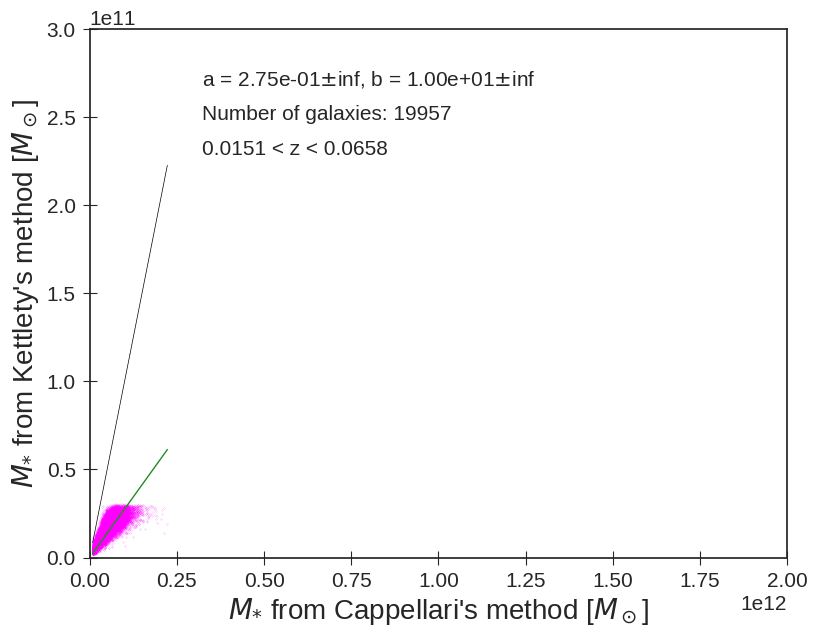

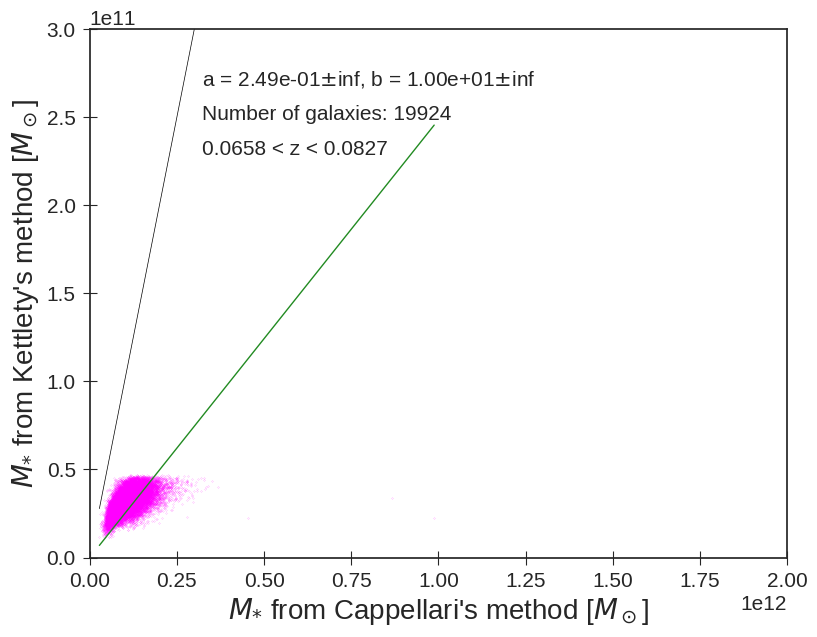

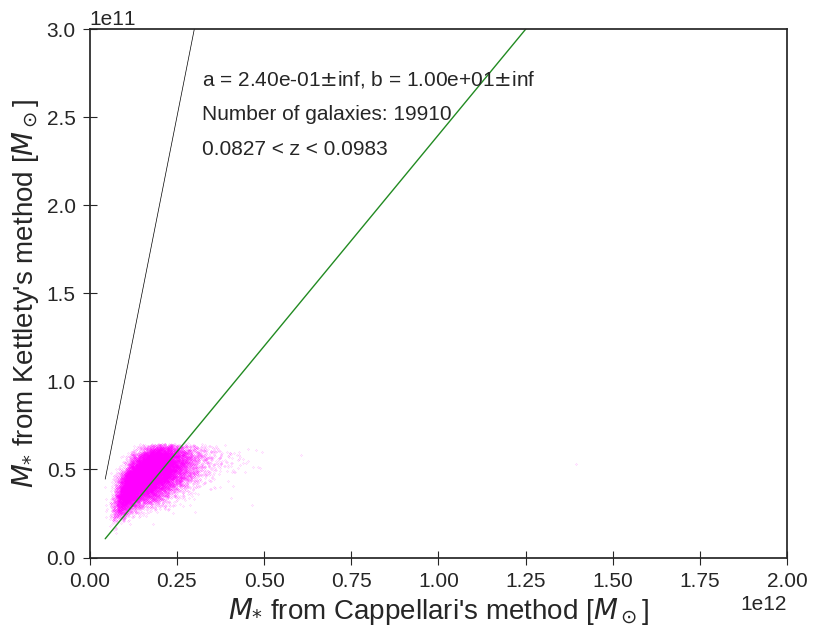

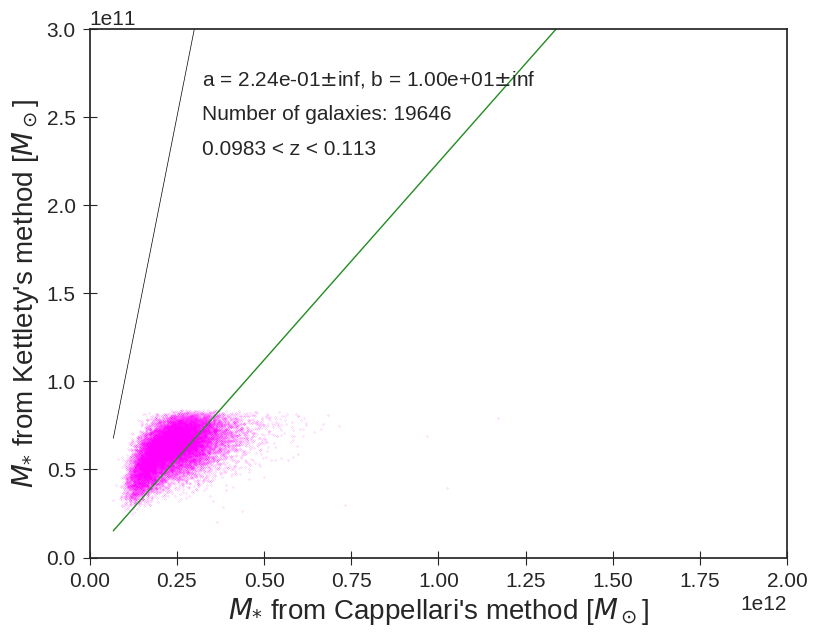

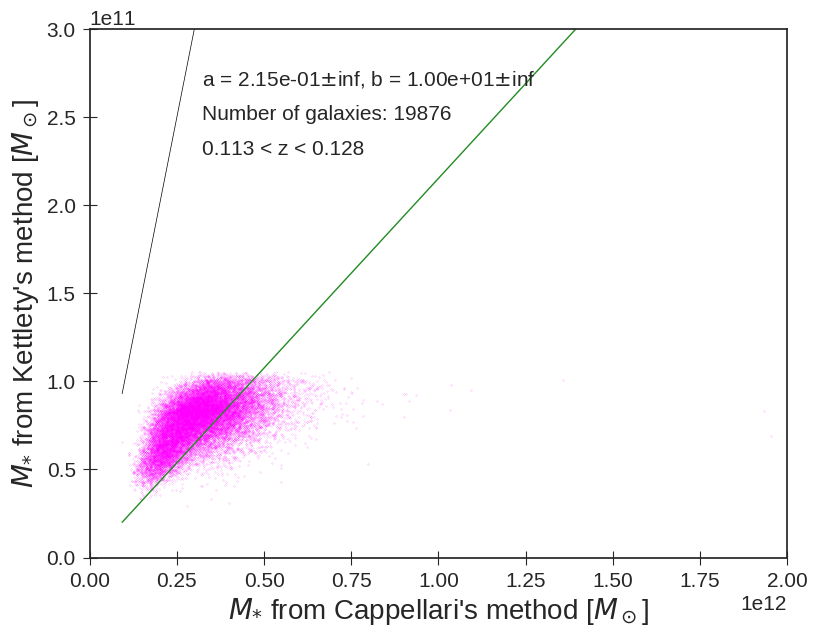

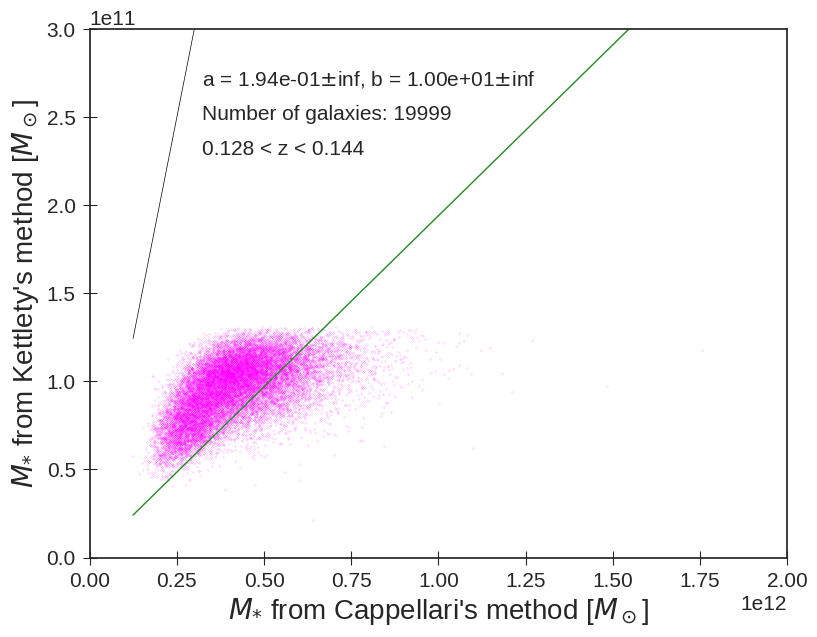

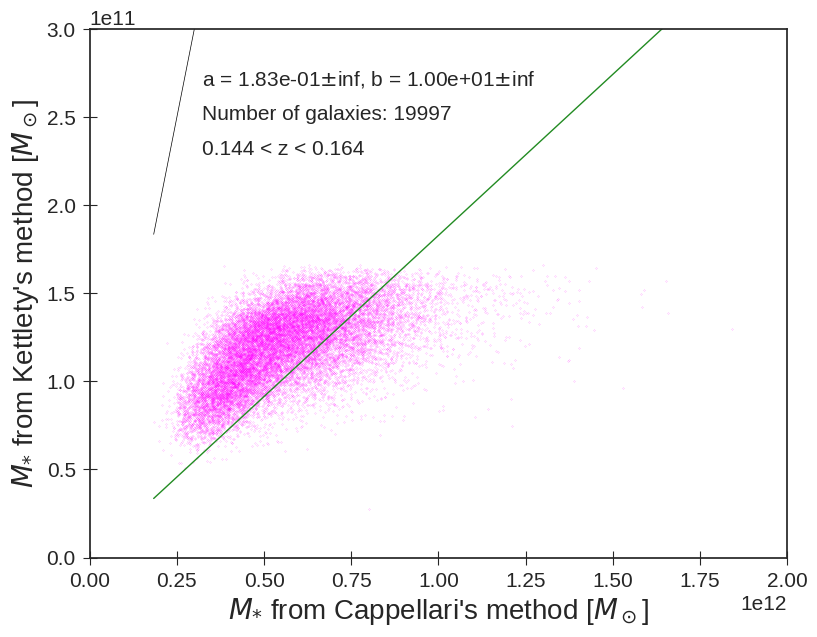

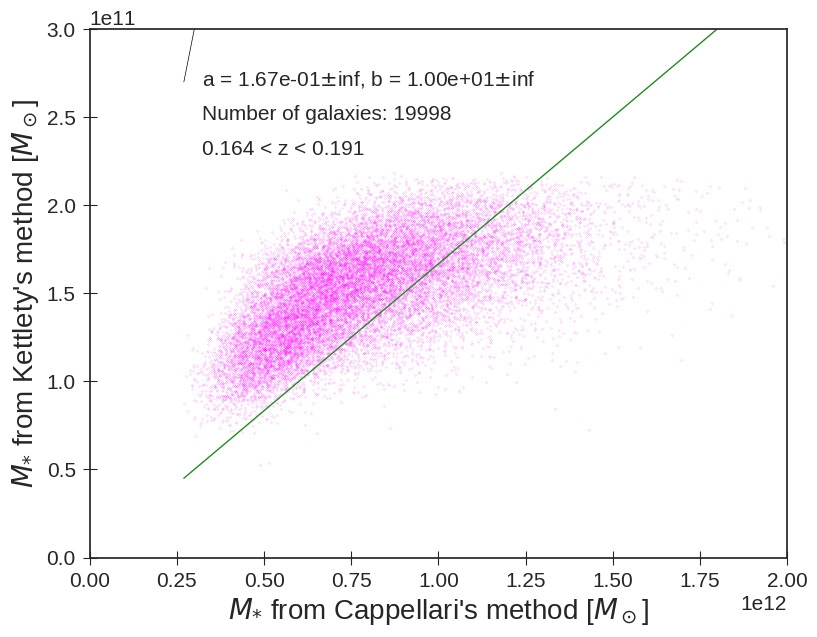

In [226]:
#import matplotlib
#matplotlib.use('Agg') # not showing the figures
#plt.rcParams.update({'figure.max_open_warning': 0})

a_list = [] # list for the slopes
b_list = [] # list for the intercepts
da_list = []
db_list = []

for i in range( 0, len(z_lims)-1 ):
    filt = np.logical_and( sm_filt_sorted.z > z_lims[i], sm_filt_sorted.z < z_lims[i+1] )
    a, b, da, db = method_comparison_o( sm_filt_sorted[filt].SMass_Cappellari, 
                             sm_filt_sorted[filt].SMass_Kettlety,
                             sm_filt_sorted[filt].err_SMass_Cappellari, 
                             sm_filt_sorted[filt].err_SMass_Kettlety, ylim = [ 0, 3e11 ] )
    plt.figtext( 0.25, 0.7,'{:.3}'.format( z_lims[i] ) + ' < z < ' 
                + '{:.3}'.format( z_lims[i+1] ) ) # rounded redshifts
    # saving the figure:
    #plt.savefig( './Pictures/z_comp_lin_'+str(i)+'.eps', format = 'eps' )
    # saving the fitted parameters:
    a_list.append( a )
    b_list.append( b )

# the results:
# the results:
print( 'a:\n', a_list )
print( '\nb:\n', b_list )  
print( '\nda:\n', da_list )
print( '\ndb:\n', db_list ) 